# Methods for Data Science: Course Work 1

### CID: 01843211

# Table of contents
- [1 Regression](#1)
    - [1.1 Linear regression](#1.1)
        - [1.1.1](#1.1.1)
        - [1.1.2](#1.1.2)
    - [1.2 Lasso regression](#1.2)
        - [1.2.1](#1.2.1)
        - [1.2.2](#1.2.2)
        - [1.2.3](#1.2.3)
    - [1.3 Elastic Net](#1.3)
        - [1.3.1](#1.3.1)
        - [1.3.2](#1.3.2)
        - [1.3.3](#1.3.3)
    - [1.4 kNN regression](#1.4)
        - [1.4.1](#1.4.1)
        - [1.4.2](#1.4.2)
- [2 Classification](#2)
    - [2.1 Random Forests](#2.1)
        - [2.1.1](#2.1.1)
        - [2.1.2](#2.1.2)
        - [2.1.3](#2.1.3)
    - [2.2 Support Vector Machine](#2.2)
        - [2.2.1](#2.2.1)
        - [2.2.2](#2.2.2)
        - [2.2.3](#2.2.3)
        - [2.2.4](#2.2.4)
        - [2.2.5](#2.2.5)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

<div id="1"/>

# Task 1:  Regression (50 marks)


<div id="1.1"/>

## 1.1 Linear regression (8 marks)  

We begin by exploring our data, to ensure there are no discrepancies which will affect the performance of our regression models.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

airfoil_noise_samples = pd.read_csv('airfoil_noise_samples.csv')
airfoil_noise_test = pd.read_csv('airfoil_noise_test.csv')
airfoil_noise_samples.head()

,Frequency,Angle,Displacement,Chord length,Velocity,Thickness,Sound Pressure
0,2175.611424,15.138865,21.075119,0.088194,66.764401,0.044771,122.365215
1,2962.923620,13.400893,13.200889,0.048462,78.221903,0.011041,129.296236
2,4430.810843,2.164599,13.959536,0.226743,57.053201,0.011499,121.827380
3,4939.695645,13.857682,18.203793,0.021705,23.896377,0.021475,114.998132
4,2193.979785,9.298757,11.007713,0.052737,38.917034,0.001741,125.639641


In [3]:
print(f"Number of null values = {airfoil_noise_samples.isnull().sum().sum()}")

Number of null values = 0


In [4]:
print(f"Duplicates in training data = {airfoil_noise_samples.duplicated().sum()}")
print(f"Duplicates in test data = {airfoil_noise_test.duplicated().sum()}")
print(f"Duplicates across all data = {pd.concat([airfoil_noise_samples, airfoil_noise_test]).duplicated().sum()}")

Duplicates in training data = 0
Duplicates in test data = 0
Duplicates across all data = 0


In [5]:
mean_sp = np.mean(airfoil_noise_samples['Sound Pressure'])
sd_sp = np.std(airfoil_noise_samples['Sound Pressure'])
print(f"Mean sound pressure = {mean_sp:.2f}")
print(f"Standard deviation of sound pressure = {sd_sp:.2f}")

Mean sound pressure = 123.97
Standard deviation of sound pressure = 4.77


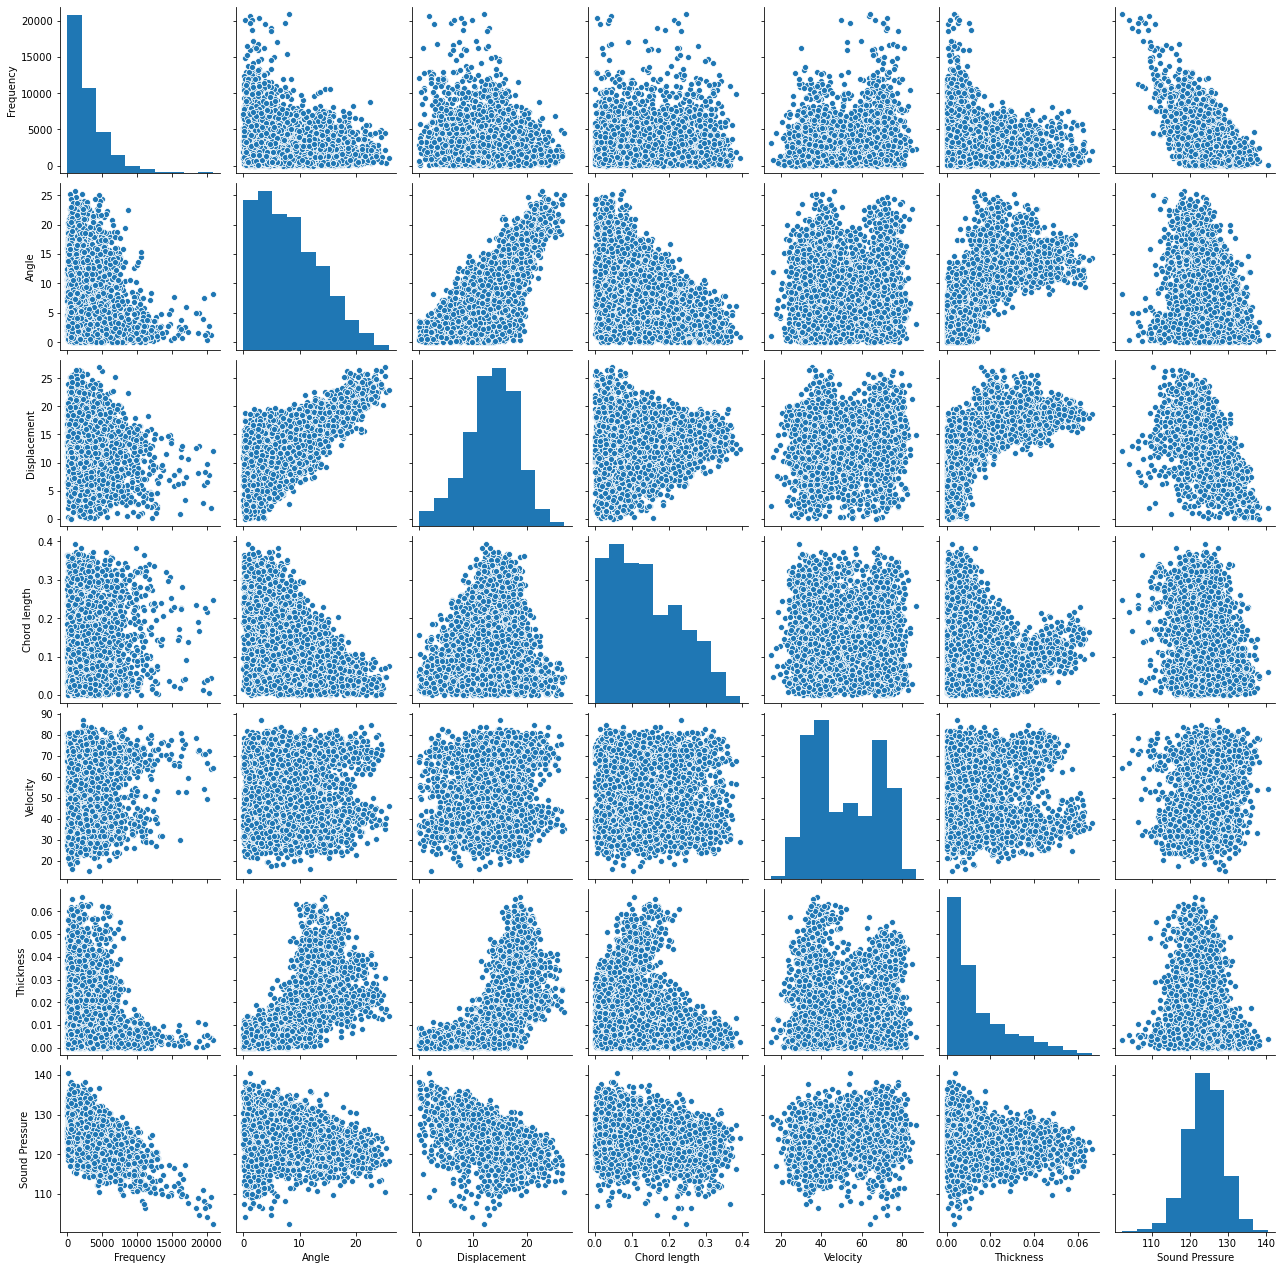

In [6]:
sns.pairplot(airfoil_noise_samples)

We see no discrepancies in the data, and no significant correlation between predictors which will affect the condition number of $X^T X$.

`Sound Pressure` has some negative association with `Frequency`, `Angle`, and `Displacement`. There also appear to be some other non-linear relationships, such as with `Thickness`. 

We also see skedacity in a number of the predictors, including`Frequency`, `Angle`, `Chord length` and `Thickness`. `Velocity` appears to have a bimodal distribution. It may therefore be beneficial to instead consider a <b> generalised linear model </b> to account for these properties, to take the log of the right-skewed variables and separate velocity into categories `fast` and `slow`. However, this is beyond the scope of this coursework and we will proceed with the standard linear model.

We notice that there are variables whose support ranges over differing scales, so we will standardise our predictors in order to ensure cohesive and accurate estimates when it comes to gradient descent optimisation. 

To do this, we will subtract the mean of the training data, $\mu_{\text{train}}$, from the predictors $X_{\text{train}}^{(i)}$ and $X_{\text{test}}^{(i)}$ and then divide both by the standard deviation $\sigma_{\text{train}}$.

<div id="1.1.1"/>

### 1.1.1

In [7]:
#Define predictor variables and target variable.
predictors = ['Frequency', 'Angle', 'Displacement', 'Chord length', 'Velocity', 'Thickness']
target = 'Sound Pressure'

We recall that the convex loss function 
$$L(\beta)=\frac{1}{2N}||\textbf{y}-\beta X - \beta_0||^2
$$
has derivative
$$
\frac{\partial}{\partial \beta}L(\beta)=X^TX\beta-X^T\textbf{y}
$$

and so setting to zero to minimise with respect to $\beta$ yields the least squares estimate

$$\hat{\beta}_{LS}=(X^T X)^{-1}X^T \textbf{y}$$

which is a global minimum due to the convexity of the function. The coefficient $\frac{1}{2N}$ does not affect the minimum of the function with respect to $\beta$, as the optimisation of the loss function is independent of the sample size.

We can therefore calculate this least squares estimate explicity without the need for a numerical method, and we implement this below.

In [8]:
#Set random seed for repeatability
np.random.seed(69)

def standardise(X, X_train): 
    """
    Standardises an array of data to z-variables based on X_train
    
        Parameters:
            X (numpy.ndarray):  (N,D) vector of data
            X_train (numpy.ndarray):  (N,D) vector of data
            
        Returns:
            X_std (numpy.ndarray): X standardised based on mean & variance of X_train
    """
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_std = (X - mu) / sigma
    return X_std

#Convert pd dataframes to numpy arrays for training

X_train = np.array(airfoil_noise_samples[predictors])
X_train_std = standardise(X_train, X_train) #Standardised training data
y_train = np.array(airfoil_noise_samples[target])

X_test = np.array(airfoil_noise_test[predictors])
X_test_std = standardise(X_test, X_train) #Standardised test data with μ and σ from X_train
y_test = np.array(airfoil_noise_test[target])

N, D = X_train.shape
X_train_aug = np.hstack([np.ones((N,1)), X_train]) # augmented training inputs of size N x (D+1)
X_train_aug_std = np.hstack([np.ones((N,1)), X_train_std]) #normalise then augment to preserve column of 1s for lasso

n, D = X_test.shape
X_test_aug = np.hstack([np.ones((n,1)), X_test]) # augmented test inputs of size n x (D+1)
X_test_aug_std = np.hstack([np.ones((n,1)), X_test_std])

def max_lik_estimate(X, y):
    """
    Outputs the least squares estimate for a linear system y=X*B+e.
    
        Parameters:
            X (numpy.ndarray): N x D matrix of training inputs
            y (numpy.ndarray): N x 1 vector of training targets/observations
            
        Returns: 
            beta_ml (numpy.ndarray): maximum likelihood parameters (D x 1)
    """
    
    #solve matrix equation for β:
    #(X^T @ X) β = X^T @ y
    beta_ml = np.linalg.solve(X.T @ X, X.T @ y)
    return beta_ml

beta_ml = max_lik_estimate(X_train_aug_std, y_train)
print('The inferred values of the model parameters are : ' + str([b.round(3) for b in beta_ml]))

def predict_LS(X_test, beta):
    """
    Predicts outcome y for a set of test inputs X_test.
    
        Parameters:
            X_test (numpy.ndarray): K x D matrix of test inputs
            beta (numpy.ndarray): D x 1 vector of parameters
            
        Returns: 
            prediction (numpy.ndarray): K x 1 prediction of f(X_test)
    """
    #obtain prediction y'=Xβ
    prediction = X_test @ beta
    return prediction

def MSE_LS(X_test, y_test, beta):
    """
    Returns the MSE for inputs X_test and beta against true values y_test.
    
        Parameters:
            X_test (numpy.ndarray): K x D matrix of test inputs
            beta (numpy.ndarray): D x 1 vector of parameters
            y_test (numpy.ndarray): K x 1 vector of true values
            
        Returns: 
            mse_sample (float): MSE of y_test against prediction of LS estimator on X
    """
    y_pred = predict_LS(X_test, beta)
    #Caclculate the mse of y_pred vs y_test
    mse_sample = np.average([(y_pred[i] - y_test[i]) ** 2 for i in range(len(y_pred))])
    return mse_sample

def Rsquared_LS(X_test, y_test, beta):
    """
    Calculates the R^2 value for a least squares model.
    
        Parameters:
            X_test (numpy.ndarray): K x D matrix of test inputs
            beta (numpy.ndarray): D x 1 vector of parameters
            y_test (numpy.ndarray): K x 1 vector of true values
            
        Returns: 
            R_squared_sample (float): R^2 of model with parameters beta
    """
    #Calculate vector of predictions
    y_pred = predict_LS(X_test, beta)
    #Calculate residual sum of squares
    RSS = np.sum([(y_pred[i] - y_test[i]) ** 2 for i in range(len(y_pred))])
    #Calculate mean
    y_bar = np.average(y_test)
    #Calculate total sum of squares
    TSS = np.sum([(y_test[i] - y_bar) ** 2 for i in range(len(y_test))])
    R_squared_sample = 1 - RSS / TSS
    return R_squared_sample

mse = MSE_LS(X_train_aug_std, y_train, beta_ml)
rsquared = Rsquared_LS(X_train_aug_std, y_train, beta_ml)
print('The in-sample MSE for the model is ' + str(mse.round(4)))
print('The in-sample R^2 for the model is ' + str(rsquared.round(4)))

The inferred values of the model parameters are : [123.97, -3.575, 0.834, -3.929, -0.078, 1.725, -0.014]
The in-sample MSE for the model is 1.8756
The in-sample R^2 for the model is 0.9177


We see a high $R^2$ value, indicating that a large proportion of the variation is explained by the model. We also see a low MSE on the training data, showing that our model works well and the relationship between the predictors and the target is relatively linear.

The (standardised) variables $X^{(j)}$ with the highest corresponding $|\hat{\beta}_j|$ are `'Frequency'`, '`Displacement'` and `'Velocity'`, indicating that these variables have the highest impact on the outcome `'Sound Pressure'`.

There is a negative association between `Displacement` and `Sound Pressure`, and also between `Frequency` and `Sound Pressure`. There is a positive association between `Velocity` and `Sound Pressure`.

We now assess our model on the testing set `airfoil_noise_test`.

<div id="1.1.2"/>

### 1.1.2

We apply the model to the test data `airfoil_noise_test` to calculate the out-of-sample MSE and $R^2$:

In [9]:
mse_test = MSE_LS(X_test_aug_std, y_test, beta_ml)
rsquared_test = Rsquared_LS(X_test_aug_std, y_test, beta_ml)
print('The in-sample MSE for the model is ' + str(mse.round(4)))
print('The in-sample R^2 for the model is ' + str(rsquared.round(4)))
print('The out-of-sample MSE for the model is ' + str(mse_test.round(4)))
print('The out-of-sample R^2 for the model is ' + str(rsquared_test.round(4)))

The in-sample MSE for the model is 1.8756
The in-sample R^2 for the model is 0.9177
The out-of-sample MSE for the model is 1.9844
The out-of-sample R^2 for the model is 0.9083


We see a higher mean square error, indicating that the model performs more poorly on the test data. This is to be expected, as the linear regression is fitted to the training data, and will typically exhibit high variance when unregularised.The $R^2$ statistic is also lower, which leads us to conclude that the model is slightly overfitted to the training data, however still generalises relatively well as the difference is marginal.

We will now implement Lasso and Elastic Net regression to reduce the variance of our model, attempting to find an optimal value via 5-fold cross-validation which will reduce the overfitting of the Ordinary Least Squares, allowing our model to perform better on `airfoil_noise_test`.

<div id="1.2"/>

## 1.2 Lasso regression (12 marks) 

<div id="1.2.1"/>

### 1.2.1

We now turn to Lasso regression to reduce the variance of our model. The Lasso cost function to minimise is

$$
L_{LASSO}(\beta)=\frac{1}{2N}||\textbf{y}-\beta X - \beta_0||^2 + \lambda||\beta||_1
$$

where $\lambda$ is a coefficient of regularisation which penalises the coefficients $\beta_1 \dots \beta_d$

We carry out component-wise differentiation of the loss function $L$ with respect to the $\beta_j$ to find our update rule, using the approximation $\frac{\partial}{\partial \beta_j} |\beta_j| = \text{sgn} (\beta_j)$ away from $0$:
$$
\begin{align*}
\frac{\partial L(\beta)}{\partial \beta_j} &= - \frac{1}{N}(X^{(j)})^T (y-\hat{y}) +\lambda *\text{sgn}(\beta_j)\text{,    for }j \neq 0\\
\frac{\partial L(\beta)}{\partial \beta_0} &= - \frac{1}{N} \sum_{i=0}^{N}(y_i-\hat{y}_i)
\end{align*}
$$
where $\text{sgn}(\beta_j)$ denotes the sign function, $y_i$ is the true observation of the class and $\hat{y}_i$ is the intermediate model prediction $X^{(i)}\beta$. We implement the gradient descent with NumPy arrays for greater efficiency, stopping if $||\nabla \beta||\leq 10^{-5}$ or `N_iterations` = `max_iterations`.

We will update our parameters $\beta$ according to the gradient descent rule

$$
\beta^{(i+1)} = \beta^{(i)} - \eta \nabla_{\beta}L_{LASSO}(\beta^{(i)})
$$

where $\eta$ is the learning rate proportional to $\frac{1}{i}$.

We know that the Least Squares term of the Lasso cost function, $||\textbf{y}-\beta X - \beta_0||^2$, is convex, from the lectures. If we turn our attention to the $l$-1 term, we can show it is also convex. In fact, we will prove that any $p$-norm is convex (which will come in handy for Elastic Net):

<b>Lemma: the $p$-norm $||\cdot||_p$ is convex</b>

Let $||\cdot||_p$ be a norm on $V$, and $\beta, \beta' \in V$ arbitrary. Then for any $\lambda \in [0,1]$,

$$
||\lambda \beta+(1-\lambda )\beta'||_p\le||\lambda \beta||_p+||(1-\lambda)\beta'||_p = \lambda||\beta||_p+(1- \lambda)||\beta'||_p
$$

where we have used the Triangle Inequality and the absolute homogeneity of the norm. Since a sum of conves functions is convex, the Lasso loss function $L_{LASSO}(\beta)$ is convex, and therefore has a global minimum. As a result, we are assured our gradient descent will converge to a true minimum value.

In [10]:
def linear_regression_lasso_gradient_descent1(X_train, y_train, l1_penalty=1.0, max_iterations=10000):
    """
    Implements gradient descent to minimise the Lasso cost function.
        
        Parameters:
            X_train (numpy.ndarray): N x D matrix of training inputs
            y_train (numpy.ndarray): N x 1 vector of training targets/observations
            l1_penalty (float): the LASSO penalty on the beta coefficients
            max_iterations (int): iterations after which the gradient descent stops
            
        Returns:
            beta (numpy.ndarray): a (D + 1) x 1 vector of coefficients
    """
    N, D = X_train.shape
    beta = max_lik_estimate(X_train, y_train)
    
    cost = np.inf
    cost_new = 0
    
    for N_iterations in range(max_iterations):
        learning_rate = 1 / (N_iterations + 1)
        dbeta = np.zeros(D)
        cost_new = (1/(2*N)) * np.inner(y_train - X_train @ beta, y_train - X_train @ beta) + l1_penalty * np.sum(abs(beta))
        
        #Update gradient according to update rule above
        #Can leave β_0 coeff as 1st row of X.T is 1s
        dbeta = (1/N) * (X_train.T @ X_train @ beta - X_train.T @ y_train)
        dbeta[1:] += l1_penalty * np.sign(beta[1:])
        
        #Move β in the negative direction of the gradient
        beta -= learning_rate * dbeta
        
        if abs(cost - cost_new) <= cost_new * 1.0e-08:
            break
        
        cost = cost_new
        
    return beta

Now that we have defined out gradient descent algorithm, we will aim to optimise the Lasso model by minimising the 5-fold CV MSE by varying $\lambda$. 

We will write a function to cross-validate, and a function to scan a `numpy.linspace` to find the optimal lambda over the range with a grid search.

In [11]:
def cross_validation_score_MSE_lasso(X_train, y_train, folds, l1_penalty, max_iterations=10000):
    """
    Calculate the cross validation MSE of a Lasso gradient descent model trained on 
    X_train with λ=l1_penalty against y_train.
    
        Parameters:
            X_train (numpy.ndarray): training data of shape (N,D)
            y_train (numpy.ndarray): training labels of shape (N,)
            folds (numpy.ndarray): array of folds indices
            l1_penalty (float): the penalty used in GD
    
        Returns:
            (float) the k-fold CV MSE of the model trained
    """
    
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        
        beta = linear_regression_lasso_gradient_descent1(X_train_i, y_train_i, l1_penalty, max_iterations)
        score_i = MSE_LS(X_val_i, y_val_i, beta)
        scores.append(score_i)

    return np.mean(scores)

def choose_best_l1_penalty(X_train, y_train, t_folds=5, lambda_range=np.linspace(0.001,0.011,11), max_iterations=10000):
    """
    Chooses the optimal l1-penalty which minimises the t_fold MSE of the Lasso model.
        
        Parameters:
            X_train (numpy.ndarray): training data of shape (N,D)
            y_train (numpy.ndarray): training labels of shape (N,)
            t_folds (int): number of folds to use in cross validation
            lambda_range (np.linspace): the range over which to search for optimal λ
            
        Returns:
            (float): the optimal l1 penalty
            lambda_scores (numpy.ndarray): the t-fold CV MSE for each lambda in lambda_range
    """
    p = np.random.permutation(len(y_train))
    X_train = X_train[p]
    y_train = y_train[p]
    folds_indexes = np.split(np.arange(len(y_train)), t_folds)
    lambda_scores = np.zeros((len(lambda_range),))
    
    for i, l1_penalty in enumerate(lambda_range):
        lambda_scores[i] = cross_validation_score_MSE_lasso(X_train, y_train, folds_indexes, l1_penalty, max_iterations)
        print(f'CV_MSE@lambda={l1_penalty:.3f}: {lambda_scores[i]:.3f}')

    best_lambda_index = np.argmin(lambda_scores)
    return lambda_range[best_lambda_index], lambda_scores


Initially, we will scan a broad linspace to get a feel for how varying $\lambda$ affects our MSE. We will use a grid search algorithm and plot the MSE against each $\lambda$ in our range.

In [12]:
_, lam_scores_high = choose_best_l1_penalty(X_train_aug_std, y_train, t_folds=5, lambda_range=np.linspace(0,10,11))


CV_MSE@lambda=0.000: 1.880
CV_MSE@lambda=1.000: 6.296
CV_MSE@lambda=2.000: 15.504
CV_MSE@lambda=3.000: 22.787
CV_MSE@lambda=4.000: 22.798
CV_MSE@lambda=5.000: 22.777
CV_MSE@lambda=6.000: 22.801
CV_MSE@lambda=7.000: 22.805
CV_MSE@lambda=8.000: 22.806
CV_MSE@lambda=9.000: 22.802
CV_MSE@lambda=10.000: 22.807


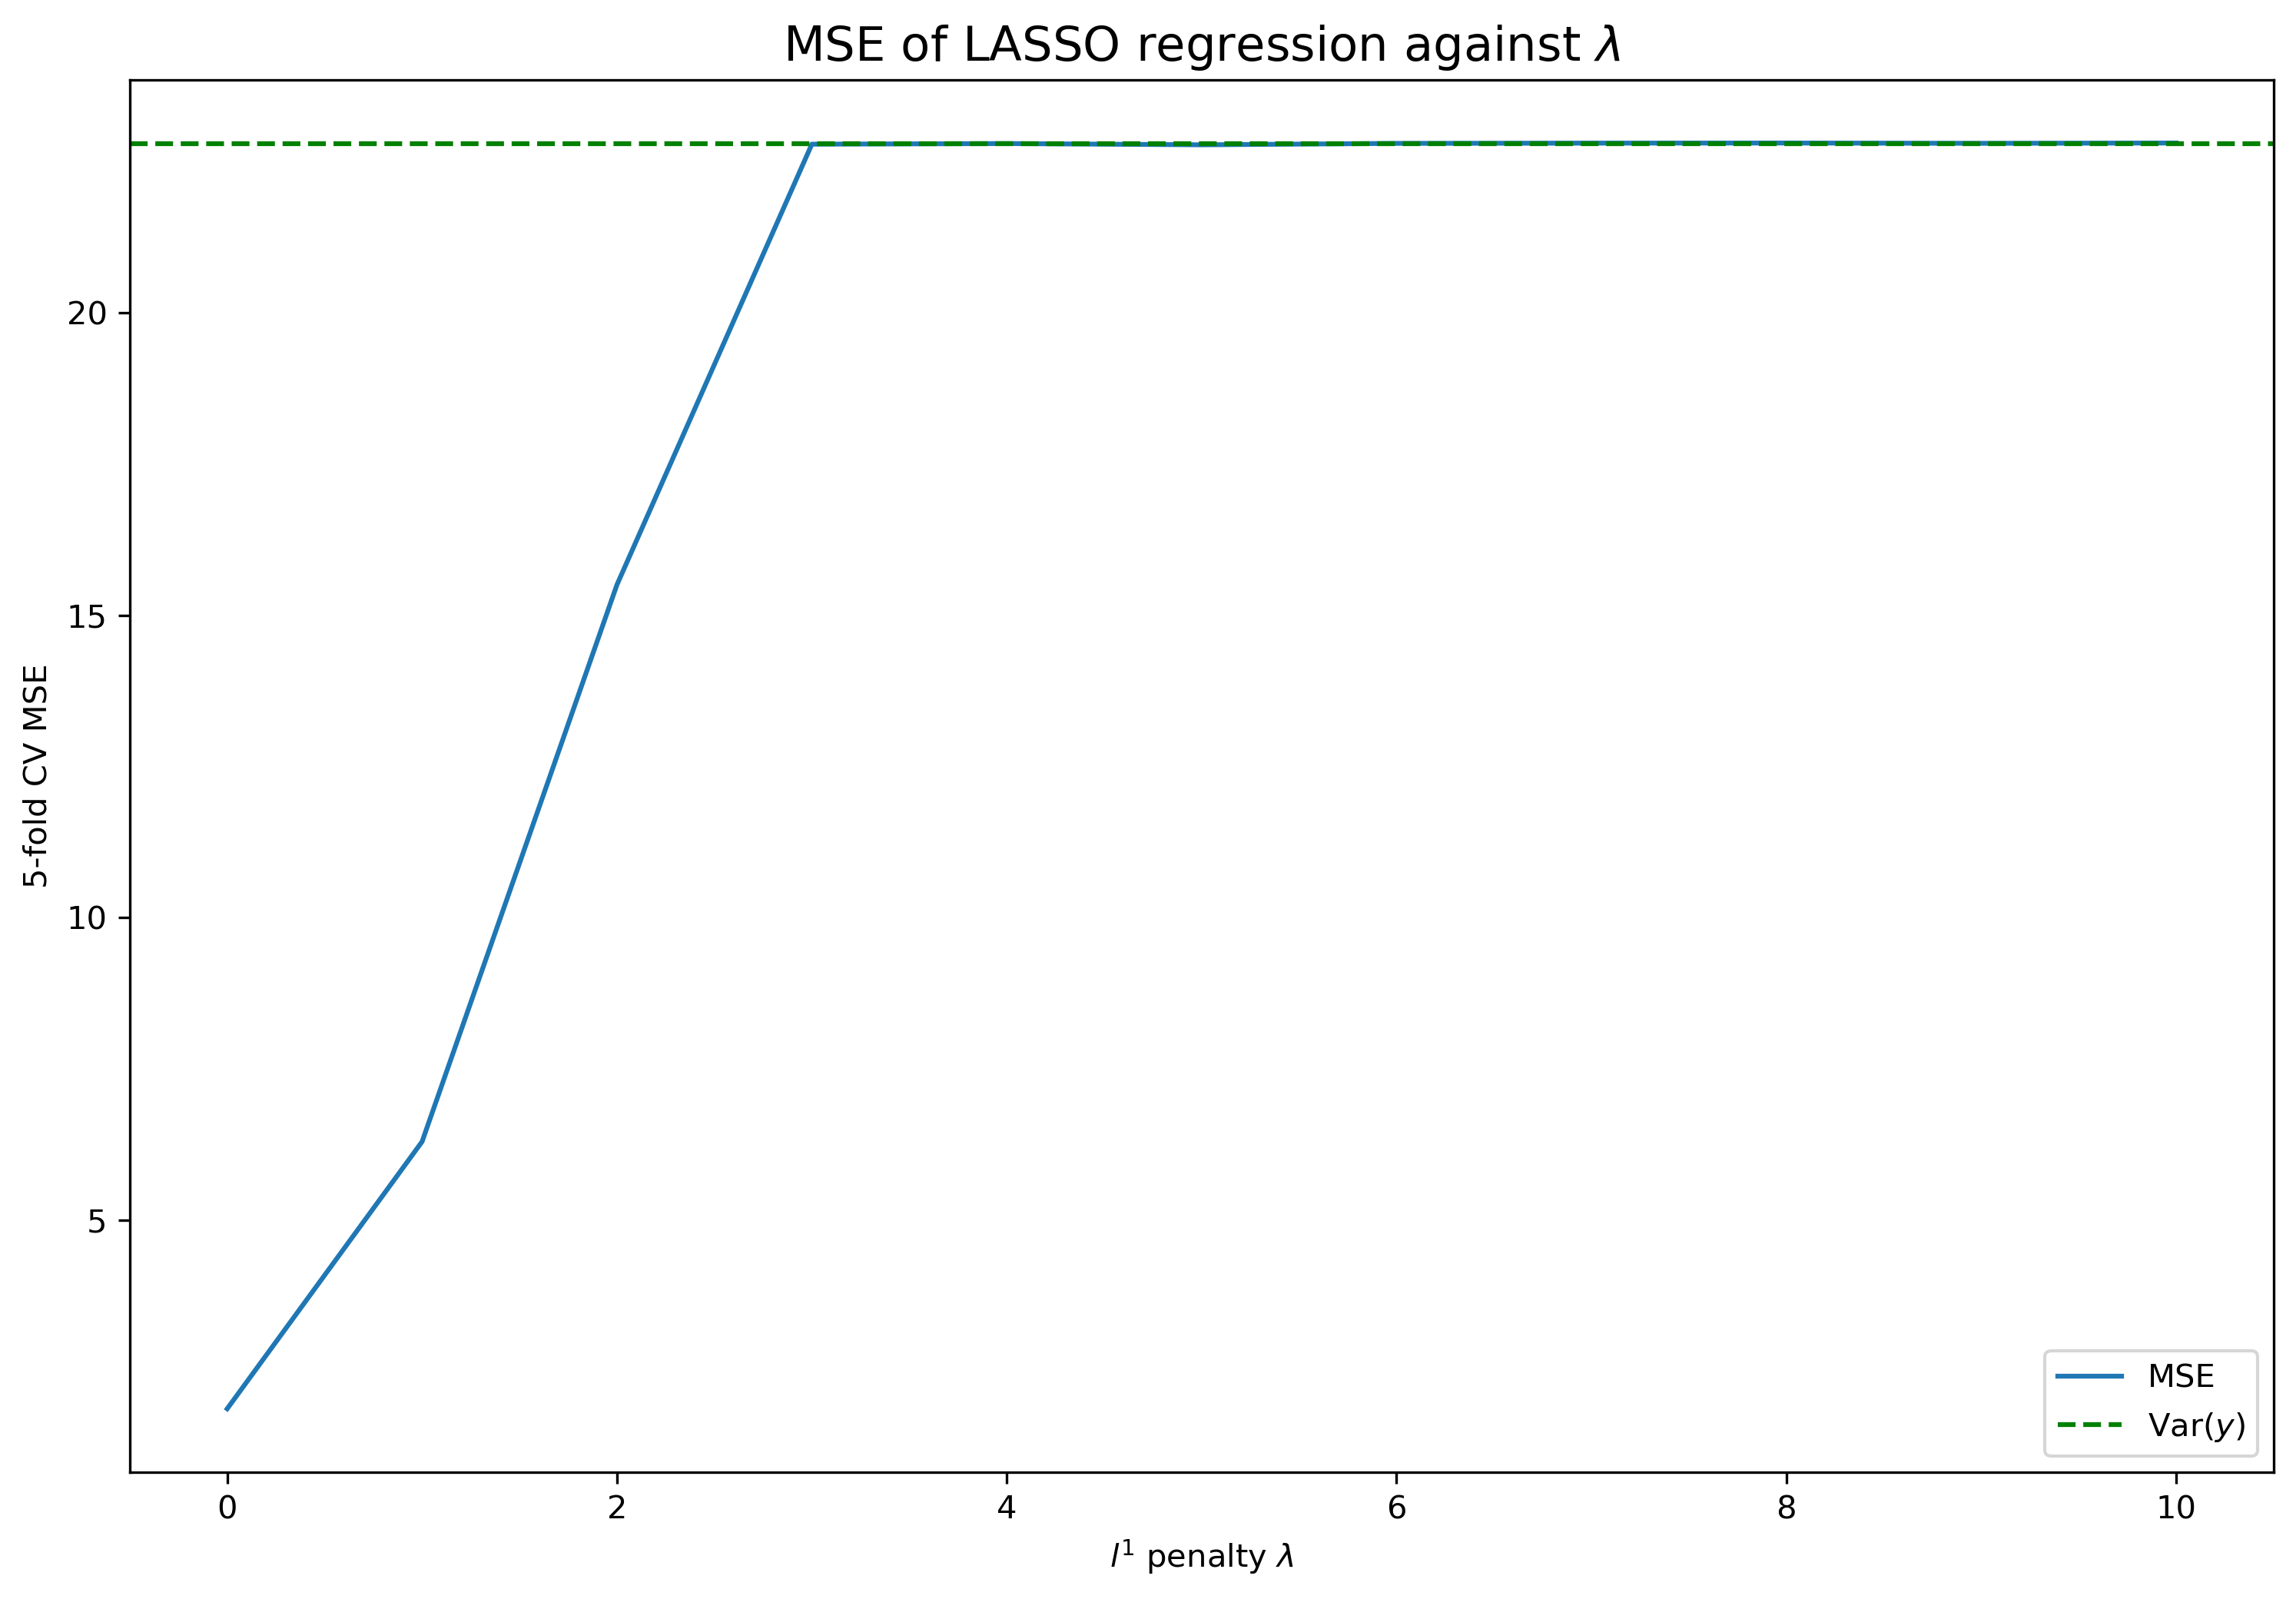

In [13]:
plt.figure(figsize=(12,8), dpi=300)
plt.title("MSE of LASSO regression against $\lambda$", size=15)
plt.xlabel('$l^1$ penalty $\lambda$')
plt.ylabel("5-fold CV MSE")
plt.plot(np.linspace(0,10,11),lam_scores_high, label='MSE')
varoutcome = sd_sp ** 2
plt.axhline(varoutcome,color='g', linestyle="--" ,label=r"Var($y$)")
plt.legend()
plt.show()

We see that, over this range, the MSE grows quickly before settling to around 22.8 after $\lambda=3$. This leads us to suspect that, when $\lambda>3$, the intercept $\beta_0$ is the sample mean and all coefficients $\beta_1 \dots \beta_6$ have been shrunk to 0.

In fact, we find this MSE is simply the variance of the whole dataset, which we would expect from a linear model with zero coefficients on all predictors, as for every $X^{(i)}$ we have:

$$
\begin{align}
\beta_0 + \beta X &= \beta_0\\
&= \bar{y}
\end{align}
$$

and so 
$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n (y_i-\hat{y}_i)^2 &= \frac{1}{n} \sum_{i=1}^n (y_i-\beta_0 + \beta X)^2\\ 
&=\frac{1}{n} \sum_{i=1}^n (y_i-\bar{y}_i)^2\\
&= \text{Var}[y]
\end{align}
$$



In [14]:
print (f"The variance of the outcome variable is {varoutcome:.3f}")

The variance of the outcome variable is 22.799


As expected, the overall variance is essentially equal to the MSE for higher values of $\lambda$ and so our model has no predictive power whatsoever. 

We will now scan a much narrower range and report the optimal value of $\lambda$ to minimise the MSE:

In [15]:
np.random.seed(897341)
best_index, lambda_scores = choose_best_l1_penalty(X_train_aug_std, y_train, t_folds=5, lambda_range=np.linspace(0,0.05,51), max_iterations=10000)

CV_MSE@lambda=0.000: 1.883
CV_MSE@lambda=0.001: 1.883
CV_MSE@lambda=0.002: 1.883
CV_MSE@lambda=0.003: 1.883
CV_MSE@lambda=0.004: 1.882
CV_MSE@lambda=0.005: 1.882
CV_MSE@lambda=0.006: 1.882
CV_MSE@lambda=0.007: 1.882
CV_MSE@lambda=0.008: 1.882
CV_MSE@lambda=0.009: 1.882
CV_MSE@lambda=0.010: 1.882
CV_MSE@lambda=0.011: 1.882
CV_MSE@lambda=0.012: 1.882
CV_MSE@lambda=0.013: 1.882
CV_MSE@lambda=0.014: 1.882
CV_MSE@lambda=0.015: 1.882
CV_MSE@lambda=0.016: 1.882
CV_MSE@lambda=0.017: 1.882
CV_MSE@lambda=0.018: 1.882
CV_MSE@lambda=0.019: 1.883
CV_MSE@lambda=0.020: 1.883
CV_MSE@lambda=0.021: 1.883
CV_MSE@lambda=0.022: 1.883
CV_MSE@lambda=0.023: 1.884
CV_MSE@lambda=0.024: 1.884
CV_MSE@lambda=0.025: 1.884
CV_MSE@lambda=0.026: 1.884
CV_MSE@lambda=0.027: 1.885
CV_MSE@lambda=0.028: 1.885
CV_MSE@lambda=0.029: 1.885
CV_MSE@lambda=0.030: 1.886
CV_MSE@lambda=0.031: 1.886
CV_MSE@lambda=0.032: 1.886
CV_MSE@lambda=0.033: 1.887
CV_MSE@lambda=0.034: 1.887
CV_MSE@lambda=0.035: 1.887
CV_MSE@lambda=0.036: 1.888
C

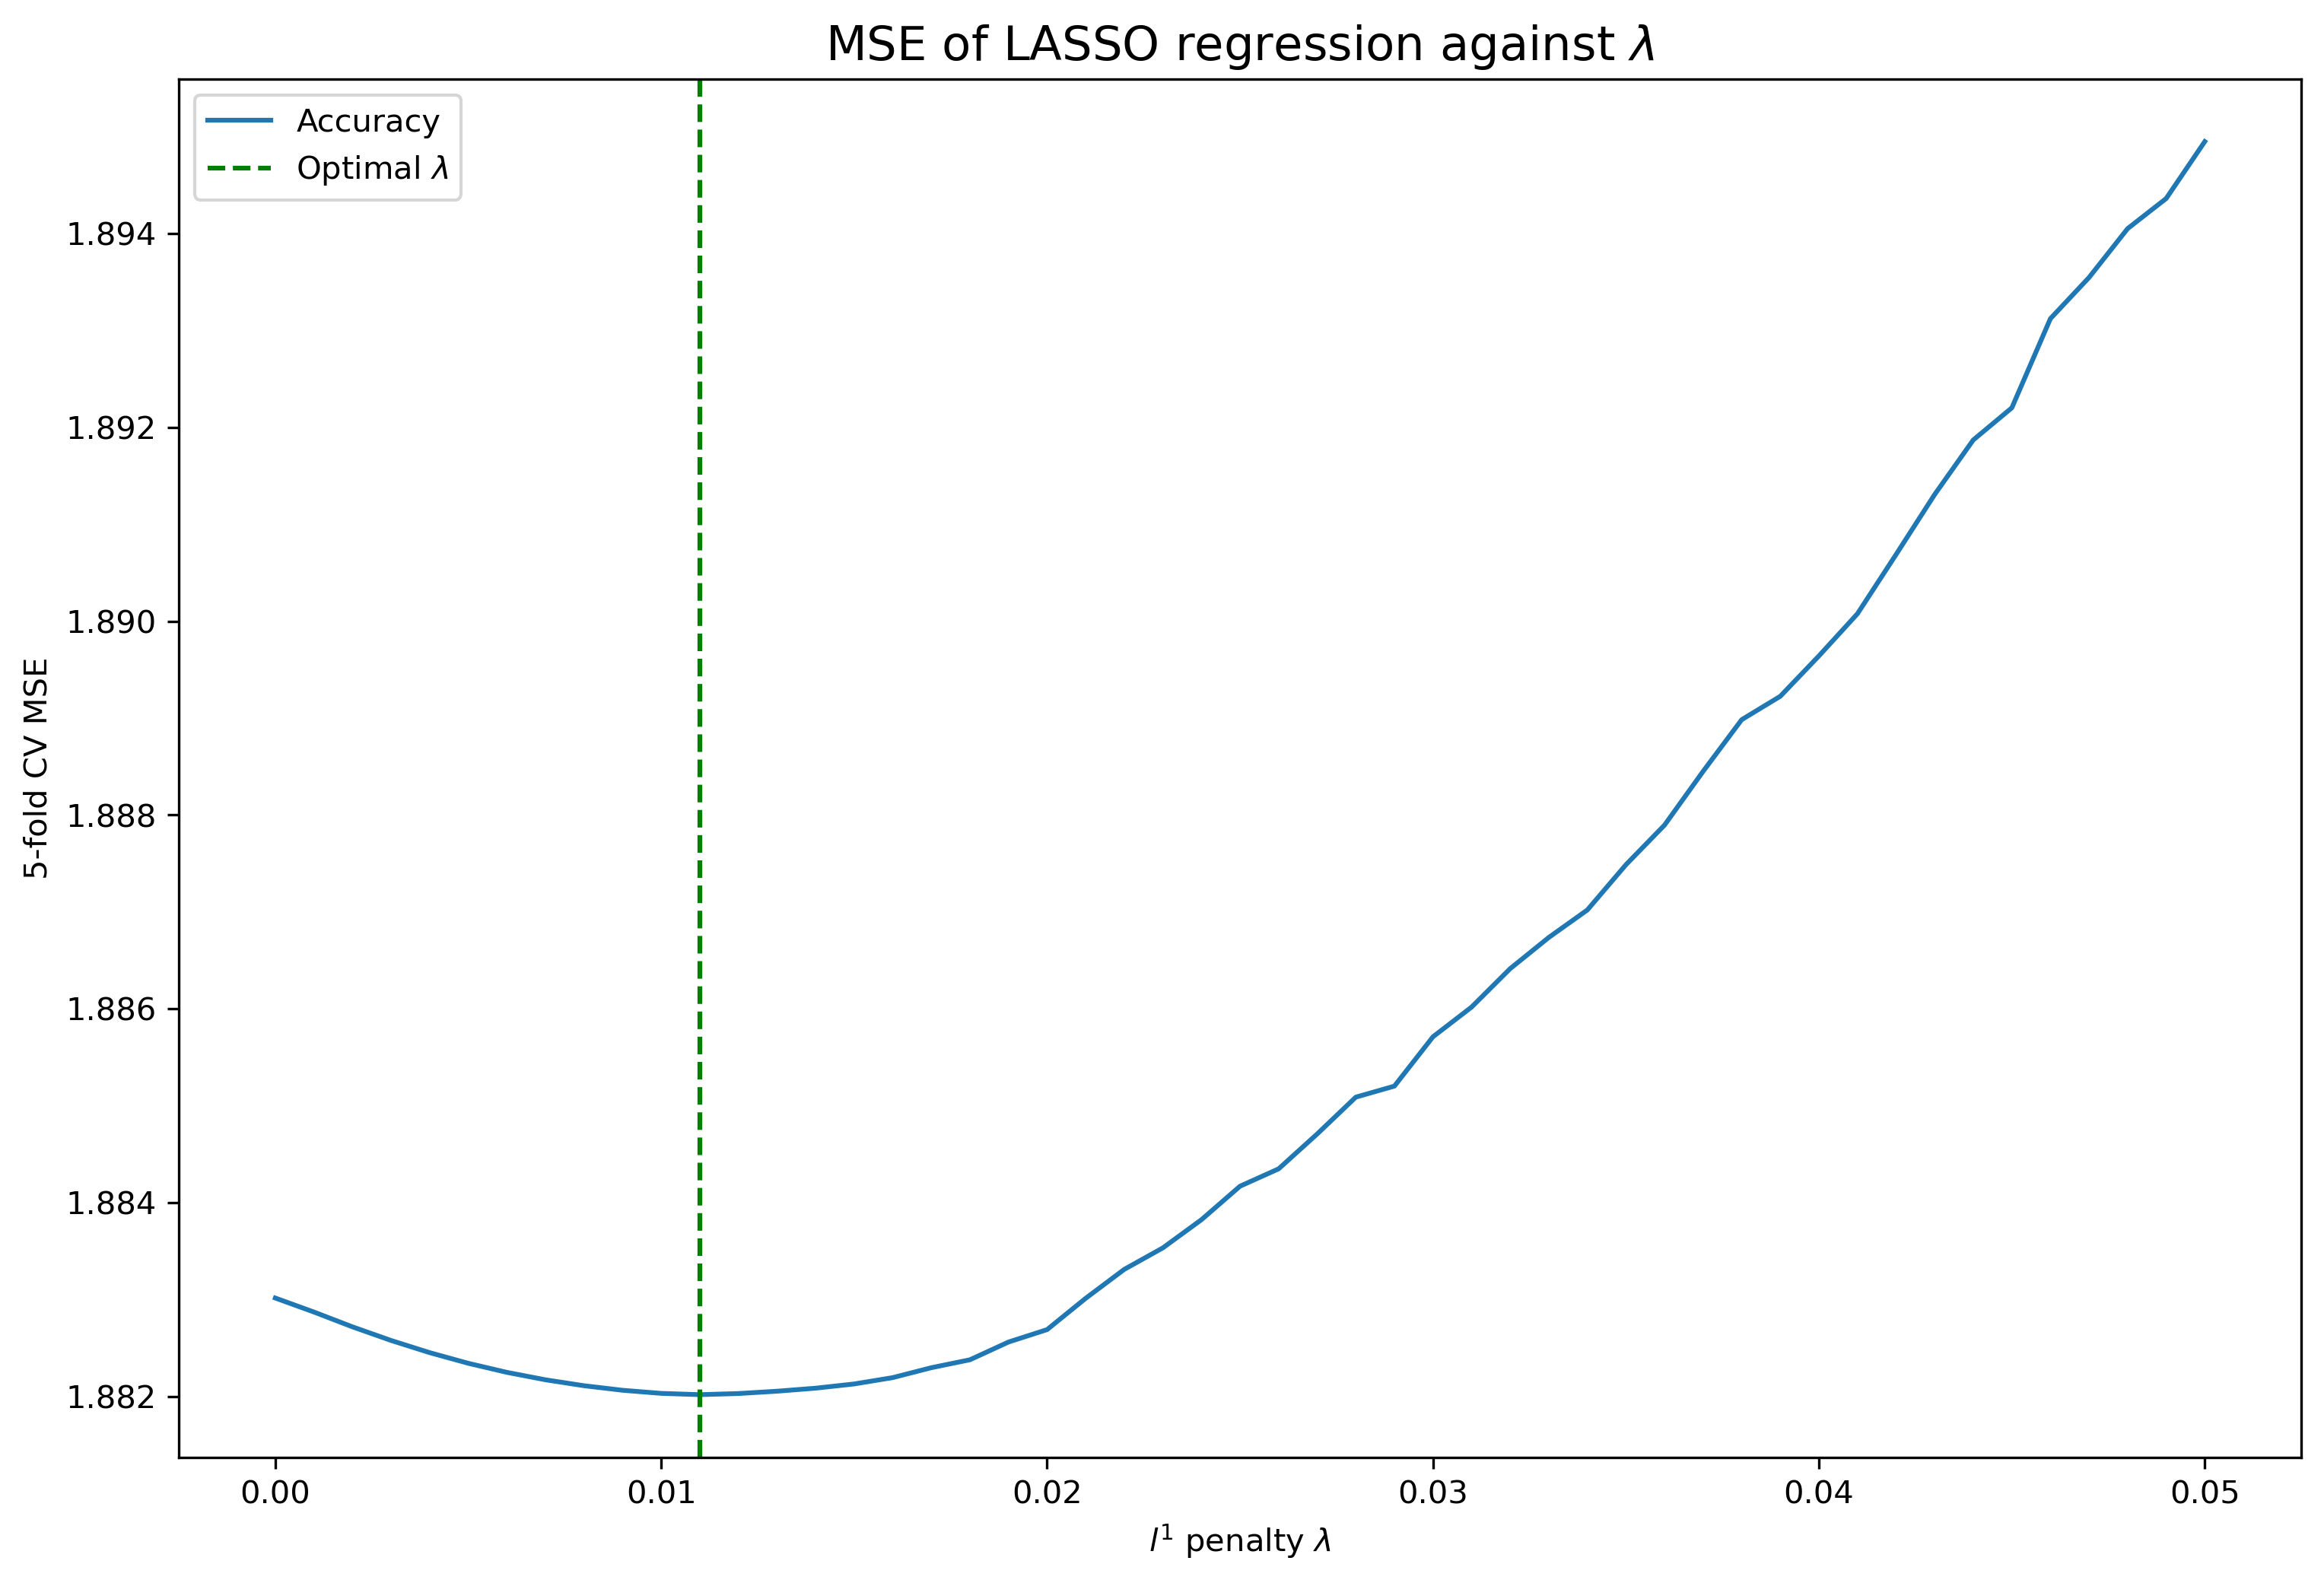

In [16]:
plt.figure(figsize=(12,8), dpi=300)
plt.title("MSE of LASSO regression against $\lambda$", size=15)
plt.xlabel('$l^1$ penalty $\lambda$')
plt.ylabel("5-fold CV MSE")
plt.plot(np.linspace(0,0.05,51),lambda_scores, label='Accuracy')
plt.axvline(best_index, color='g', linestyle='--', label='Optimal $\lambda$')
plt.legend()
plt.show()

In [17]:
print(f"The optimal value of lambda (with lowest MSE) is {best_index:.3f}")

The optimal value of lambda (with lowest MSE) is 0.011


We see a clear trend here. Initially, as $\lambda$ grows the 5-cold CV MSE decreases as the model trained on the training folds is generalising better to the validation fold. However, past $\lambda=0.011$, the model begins to underfit, becoming too biased and failing to adapt to trends in the dataset, and the MSE begins to increase again (with some random noise introduced by the randomness of the selected splits for cross-validation).

We will therefore train our optimal model with $\lambda=0.011$ to find the optimal balance between bias and variance.

<div id="1.2.2"/>

### 1.2.2

We carry out gradient descent on the same range as above, but this time on the whole training set. We store our inferrd parameters $\beta_1 \dots \beta_6$ and visualise how they change as we increase $\lambda$.

(I have decided to exclude $\beta_0$ from the graph, as it is simply the sample mean $\bar{y}$ for all $\lambda$ since the data is standardised; however, because it has such a high absolute value, it makes it more difficult to see the changes in the more interesting coefficients

In [18]:
#Split the training set into the first CV split
folds_indexes = np.split(np.arange(len(y_train)), 5)
test_indexes = folds_indexes[0]
train_indexes = list(set(range(y_train.shape[0])) - set(test_indexes))

#Choose first fold to carry out regression on
X_train1 = X_train_aug_std[train_indexes, :]
y_train1 = y_train[train_indexes]

X_test1 = X_train_aug_std[test_indexes, :]
y_test1 = y_train[test_indexes]

#Test bigger range of λs 
lambdas = np.linspace(0, 5, 51)
beta_dict_lasso = {}
for lam in lambdas:
    print (f"Lasso with lambda = {lam:.1f}")
    beta = linear_regression_lasso_gradient_descent1(X_train1, y_train1, lam, 10000)
    beta_dict_lasso[lam] = beta[1:] #get rid of intercept as its boring + spoils the graph

Lasso with lambda = 0.0
Lasso with lambda = 0.1
Lasso with lambda = 0.2
Lasso with lambda = 0.3
Lasso with lambda = 0.4
Lasso with lambda = 0.5
Lasso with lambda = 0.6
Lasso with lambda = 0.7
Lasso with lambda = 0.8
Lasso with lambda = 0.9
Lasso with lambda = 1.0
Lasso with lambda = 1.1
Lasso with lambda = 1.2
Lasso with lambda = 1.3
Lasso with lambda = 1.4
Lasso with lambda = 1.5
Lasso with lambda = 1.6
Lasso with lambda = 1.7
Lasso with lambda = 1.8
Lasso with lambda = 1.9
Lasso with lambda = 2.0
Lasso with lambda = 2.1
Lasso with lambda = 2.2
Lasso with lambda = 2.3
Lasso with lambda = 2.4
Lasso with lambda = 2.5
Lasso with lambda = 2.6
Lasso with lambda = 2.7
Lasso with lambda = 2.8
Lasso with lambda = 2.9
Lasso with lambda = 3.0
Lasso with lambda = 3.1
Lasso with lambda = 3.2
Lasso with lambda = 3.3
Lasso with lambda = 3.4
Lasso with lambda = 3.5
Lasso with lambda = 3.6
Lasso with lambda = 3.7
Lasso with lambda = 3.8
Lasso with lambda = 3.9
Lasso with lambda = 4.0
Lasso with lambd

In [19]:
#print (beta_dict_lasso)

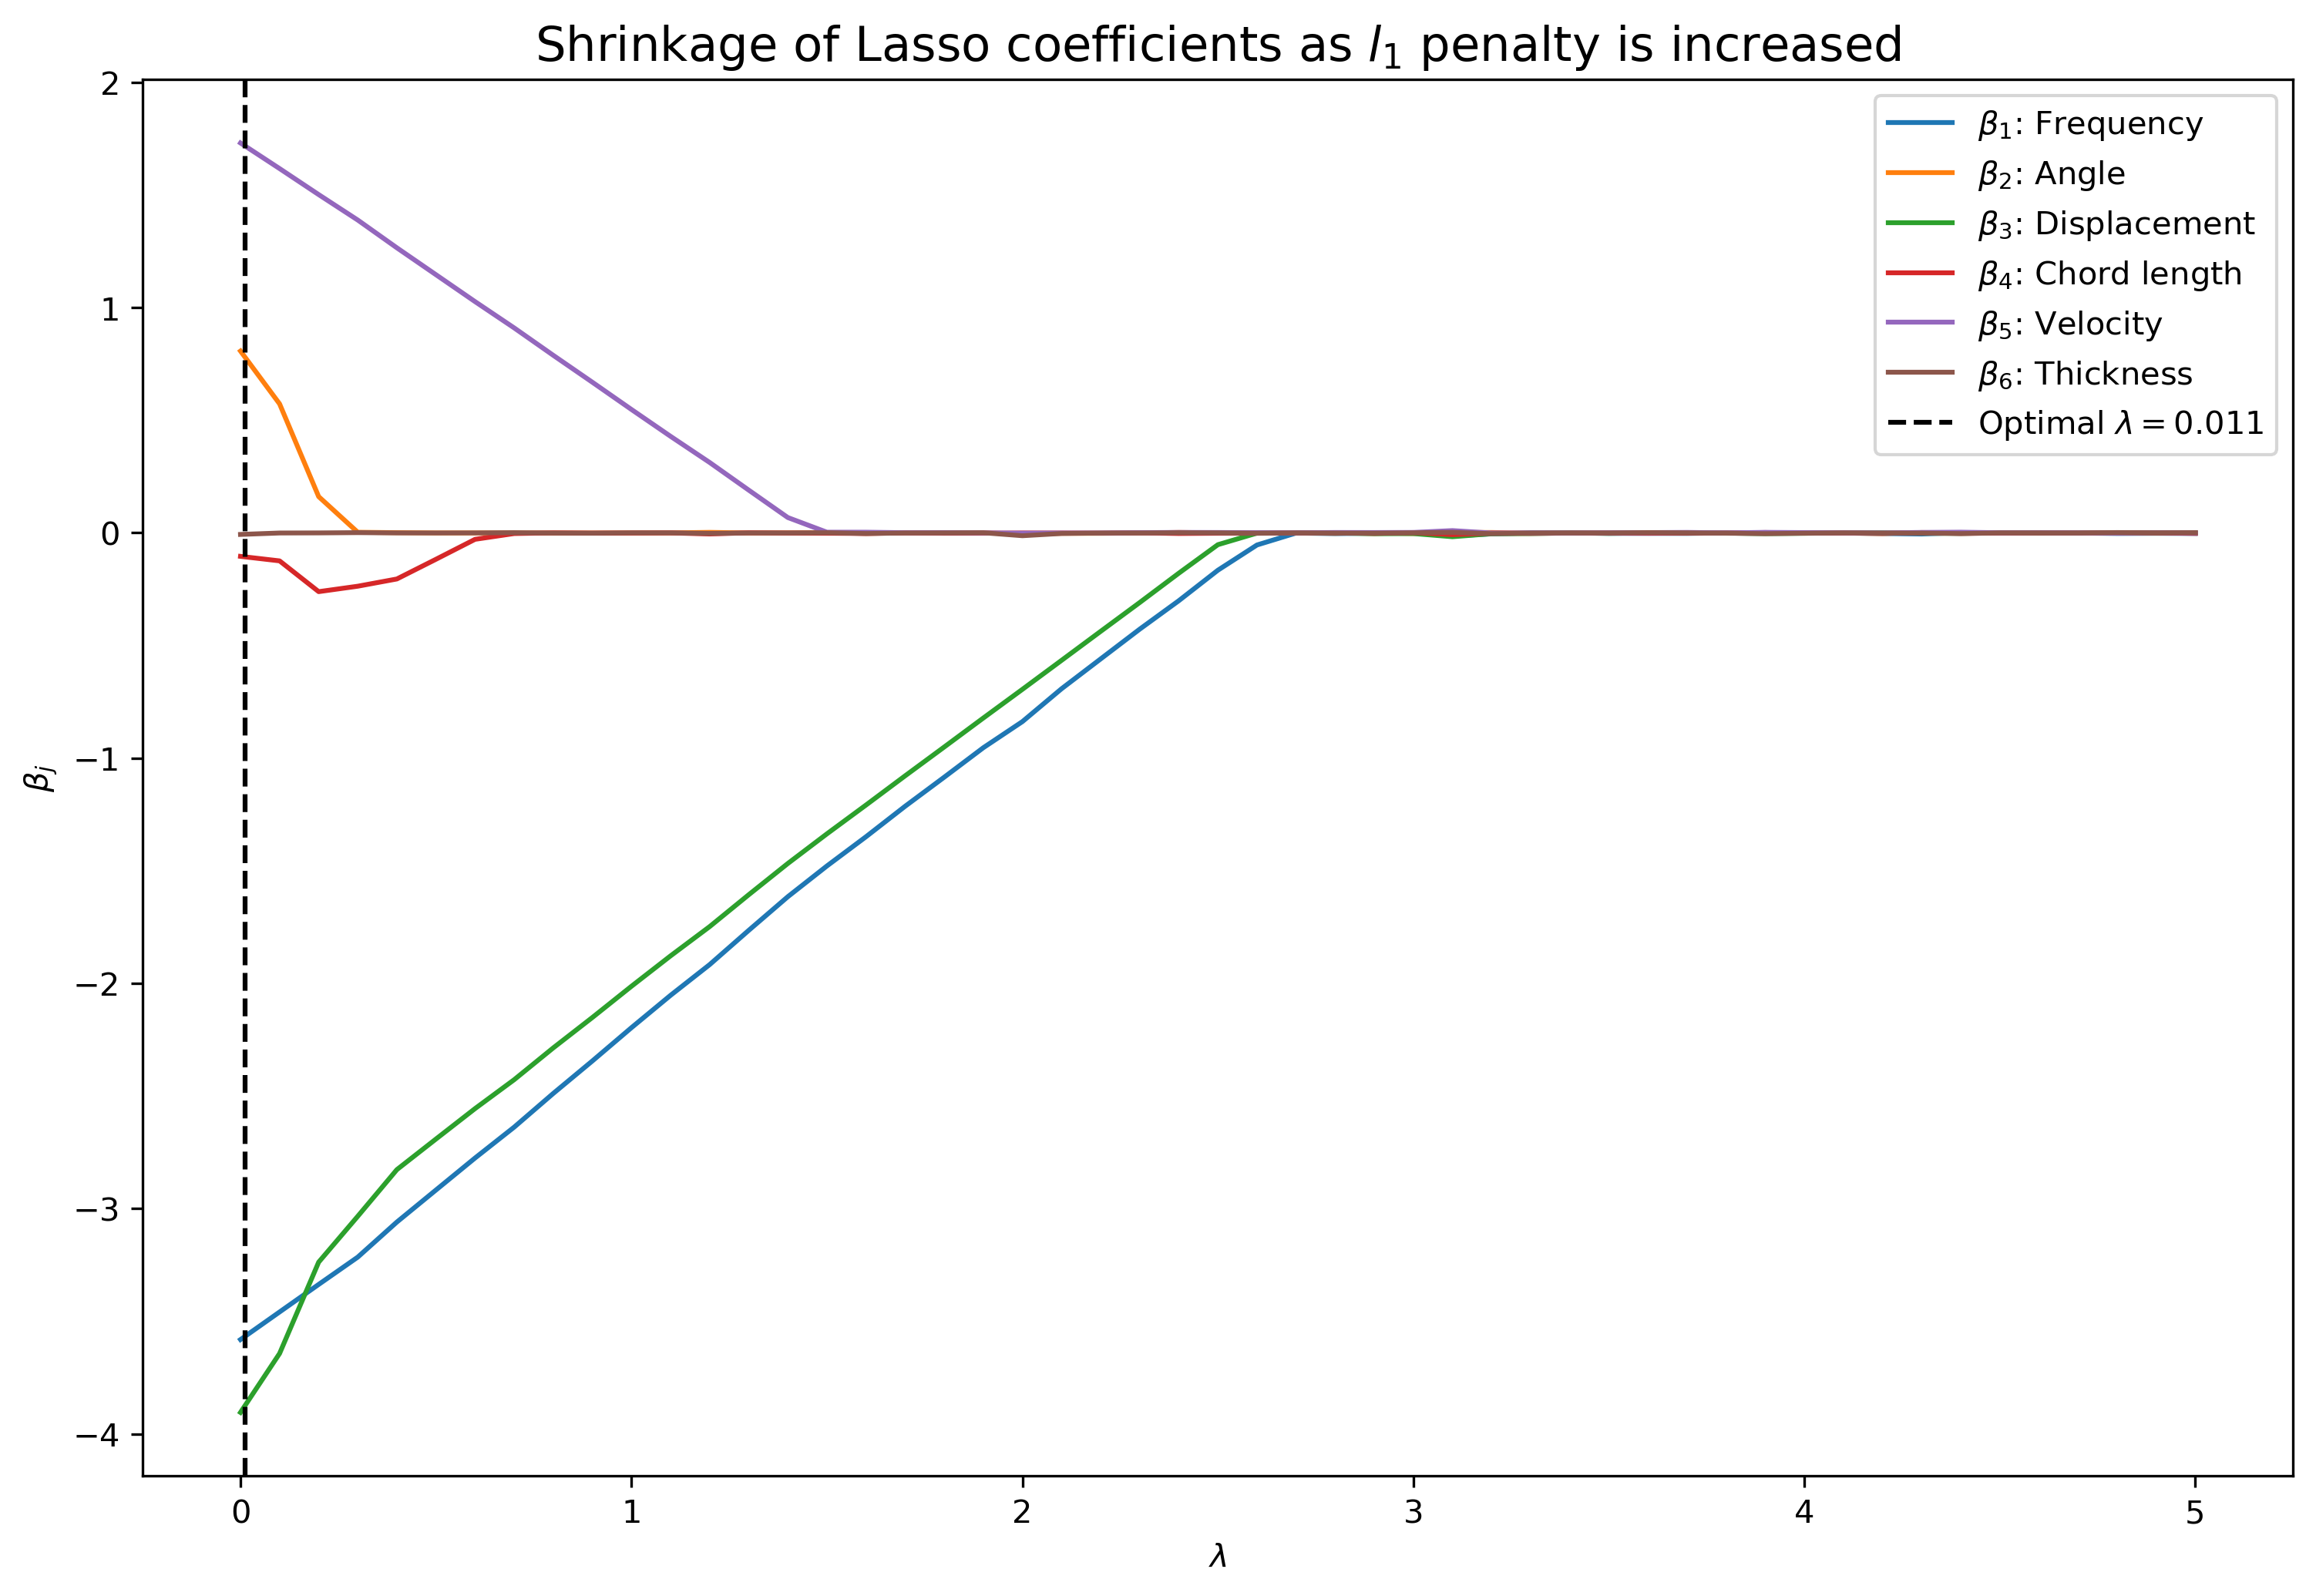

In [20]:
plt.figure(figsize=(12,8), dpi=300)
for i in range(X_train1.shape[1] - 1):
    plt.plot(list(beta_dict_lasso.keys()), [beta_dict_lasso[lam][i] for lam in beta_dict_lasso.keys()], label=fr"$\beta_{i + 1}$: {airfoil_noise_samples.columns[i]}")
plt.axvline(best_index, color='black', linestyle='--', label=fr'Optimal $\lambda = {best_index:.3f}$')
plt.legend()
plt.ylabel(r"$\beta_j$")
plt.xlabel("$\lambda$")
plt.title("Shrinkage of Lasso coefficients as $l_1$ penalty is increased", size=15)
plt.show()

As expected, as $\lambda$ increases the absolute values of the coefficients shrink due to greater penalisation, becoming 0 as $\lambda$ is large. In contrast with Ridge regression, where the coefficients approach zero asymptotically, the LASSO penalty has the capability of eliminating coefficients altogether, as seen in the above graph, and so it can be used not only as a regularisation method but also variable selection.

We see that all coefficients become 0 around $\lambda=3$, which is consistent with our findings in the grid search that the MSE of the model becomes the sample variance around this point.

With $\lambda = 0$, the estimator is simply the least-squares estimate, and so it is unbiased to the training set (BLUE according to Gauss-Markov), however exhibits high variance.

The goal of the LASSO penalty is to reduce the variance by shrinking the $l_1$ norm of the coefficients, thus removing some adaptation of the least squares estimate to the specific noise in the dataset. This is clear to see in the above plot: as the $l_1$-penalty increases, the absolute values of coefficients shrink. 

This will make the esimator biased, however reduce some of the variance. The aim of the cross-validation is to find a bias-variance pairing that will minimise the mean square error. If $\lambda$ is too large, the model will underfit and not appropriately represent the true relationship between predictos and outcome. Therefore, the goal of the cross-validation is to find a tradeoff between bias and variance which minimises overall out-of-sample MSE. Of course, we cannot calculate out-of-sample MSE on our test data, hence we use training and tesing folds.

The intercept term $\beta_0$ is not affected by the Lasso penalty, and so it is simply the sample mean of the $y_i$ for all values of $\lambda$ (assuming data is standardised).

<div id="1.2.3"/>

### 1.2.3

In [21]:
best_beta_lasso = linear_regression_lasso_gradient_descent1(X_train_aug_std, y_train, best_index, 10000)
mse_test_lasso = MSE_LS(X_test_aug_std, y_test, best_beta_lasso)
rsquared_test_lasso = Rsquared_LS(X_test_aug_std, y_test, best_beta_lasso)

print('The out-of-sample MSE for the OLS model is ' + str(mse_test.round(4)))
print('The out-of-sample R^2 for the OLS model is ' + str(rsquared_test.round(4)))
print('The out-of-sample MSE for the Lasso model is ' + str(mse_test_lasso.round(4)))
print('The out-of-sample R^2 for the Lasso model is ' + str(rsquared_test_lasso.round(4)))

The out-of-sample MSE for the OLS model is 1.9844
The out-of-sample R^2 for the OLS model is 0.9083
The out-of-sample MSE for the Lasso model is 1.9813
The out-of-sample R^2 for the Lasso model is 0.9085


We see very similar results in terms of MSE and $R^2$ with the Lasso shrinkage when compared to the standard LS estimator. The MSE is slightly lower, suggesting that the Lasso generalises better to the test set. We expect this, as this is what the cross-validation hyperparameter tuning is supposed to achieve.

This similarity is likely due to the fact that the optimal penalty we have found, $\lambda=0.004$, and thus doesn't shrink the LS parameters a great deal.

In fact, when we compare the coefficients of the estimators, $\beta_{\text{LS}}$ and $\beta_{\text{lasso}}$ we see they are very similar:

In [22]:
#print(f"The least squares estimator is \n {[round(beta,4) for beta in beta_ml]}")
#print(f"The LASSO estimator is \n {[round(beta,4) for beta in best_beta_lasso]}")
rel_difference = np.array([f"{round(np.abs(i1 - i2) / i1 * 100,1)}%" for i1, i2 in zip(beta_ml, best_beta_lasso)])
beta_ml_rounded = np.round(beta_ml, 4)
best_beta_lasso_rounded = np.round(best_beta_lasso, 4)
coefs_ols_lasso = np.stack((beta_ml_rounded, best_beta_lasso_rounded, rel_difference), axis=1)
beta_df = pd.DataFrame(coefs_ols_lasso, columns=['OLS parameters', 'LASSO parameters', 'Relative change'], index=[r'$\beta_%s$' %i for i in range(len(beta_ml))])
beta_df


,OLS parameters,LASSO parameters,Relative change
$\beta_0$,123.9703,123.9703,0.0%
$\beta_1$,-3.5755,-3.5619,-0.4%
$\beta_2$,0.8345,0.805,3.5%
$\beta_3$,-3.9286,-3.9052,-0.6%
$\beta_4$,-0.0783,-0.0792,-1.1%
$\beta_5$,1.725,1.7131,0.7%
$\beta_6$,-0.0136,-0.0002,-98.3%


As expected, the coefficient $\beta_0$ in both cases is just the sample mean which is always the case with standardised data. It has not changed since it is not affected by the regularisation. None of the other coefficients $\beta_1 \dots \beta_j$ differ by much either, however. The coefficient that has seen the biggest proportional reduction under Lasso regularisation is $\beta_6$, effectively reduced to 0, suggesting that the OLS model falsely infers a relationship between $\beta_6$ and the outcome `sound_pressure`, as the MSE improves when this variable is exluded.

We will train another OLS model with the last column of the data excluded as an aside, and see if it generalises better to the test data (in terms of MSE):

In [25]:
X_train_without_last_col = X_train_aug_std[:,:-1]
X_test_without_last_col = X_test_aug_std[:,:-1]
beta_reduced = max_lik_estimate(X_train_without_last_col, y_train)
print(f"Full LS test MSE: {mse_test:.4f}")
print(f"LS with Thickness excluded test MSE: {MSE_LS(X_test_without_last_col, y_test, beta_reduced):.4f}")

Full LS test MSE: 1.9844
LS with Thickness excluded test MSE: 1.9831


As we can see, the OLS model with the variable `Thickness` excluded actually performs better than the full OLS model on the test data. This is a key advantage of Lasso shrinkage: the ability to effectively eliminate variables which do not improve the model, whose inclusion may cause overfitting and high variance of the model.

When dealing with a large number of features, Lasso can be much more effective than forward- or backward-stepwise selection.

We will now implement a new regularisation technique to further improve the variance.

<div id="1.3"/>

## 1.3 Elastic Nets (20 marks) 

<div id="1.3.1"/>

### 1.3.1

We impliment an Elastic Net linear regression model, combining Ridge and Lasso penalties.

In this case, the loss function to minimise is

$$
L_{EN}(\beta) = \frac{1}{2N}||\textbf{y}-\textbf{X}\beta -\beta_0||^2 + \lambda [\alpha||\beta||_1 + (1-\alpha)||\beta||^2]
$$

We can use our previously calculated derivative for the $l_1$ term with a different multiplicative constant. The derivative of $||\beta||^2$ with respect to each $\beta_j$ is simply $2\beta_j$. So in the gradient descent algorithm, our derivatives are:

$$
\begin{align*}
\frac{\partial L(\beta)}{\partial \beta_j} &= - \frac{1}{N}(X^{(j)})^T (y-\hat{y}) +\lambda [ \text{sgn}(\beta_j)\alpha  + 2(1 - \alpha)  \beta_j]\text{,    for }j \neq 0\\
\frac{\partial L(\beta)}{\partial \beta_0} &= - \frac{1}{N} \sum_{i=0}^{N}(y_i-\hat{y}_i)
\end{align*}
$$
where, as before, $y_i$ is the true value and $\hat{y}_i$ is the intermediate model prediction.

We will again update our parameters $\beta$ according to the gradient descent rule

$$
\beta^{(i+1)} = \beta^{(i)} - \eta \nabla_{\beta}L_{EN}(\beta^{(i)})
$$

where $\eta$ is the learning rate equal to $\frac{1}{i}$, stopping the descent if $||\Delta L(\beta)||\leq 10^{-8} L(\beta) \$ or `N_iterations` = `max_iterations`.

We know that this will converge to a global minimum, since the $l_1$- and $l_2$-norms are convex, and the sum of convex functions is convex. We proceed with the gradient descent below:

In [26]:
def elastic_net_gradient_descent(X_train, y_train, alpha=0.5, lam=1, max_iterations=10000, print_updates=True):
    """
    Implements gradient descent to minimise the Elastic Net cost function.
        
        Parameters:
            X_train (numpy.ndarray): N x D matrix of training inputs
            y_train (numpy.ndarray): N x 1 vector of training targets/observations
            alpha (float): coefficient controlling relative importance of Ridge and Lasso terms
            lam (float): the strength of the regularisation
            max_iterations (int): iterations after which the gradient descent stops
            
        Returns:
            beta (numpy.ndarray): a (D + 1) x 1 vector of coefficients
    """
    N, D = X_train.shape
    beta = max_lik_estimate(X_train, y_train)
    cost = np.inf
    cost_new = 0
    
    #Randomly permute the data for cross validation
    p = np.random.permutation(len(y_train))
    X_train = X_train[p]
    y_train = y_train[p]
    
    for N_iterations in range(max_iterations):
        learning_rate = 1 / (N_iterations + 1)
        dbeta = np.zeros(D)
        #Define cost function
        cost_new = cost_new = (1/(2*N)) * np.inner(y_train - X_train @ beta, y_train - X_train @ beta) + lam * (alpha * np.sum(abs(beta)) + (1 - alpha) * np.linalg.norm(beta)**2)
        #Update gradient according to update rule above
        #Can leave beta0 coeff as 1st row of X.T is 1s
        dbeta = (1/N) * (X_train.T @ X_train @ beta - X_train.T @ y_train)
        dbeta[1:] += lam * (alpha * np.sign(beta[1:]) + 2 * (1 - alpha) * beta[1:])
        if abs(cost-cost_new) <  cost * 1.0e-08: #Checking for convergence of the cost function
            if print_updates:
                print ("Converged in n_iterations = " + str(N_iterations))
            return beta
        cost = cost_new
        
        beta -= learning_rate * dbeta
    
    return beta

In [27]:
def cross_validation_score_elastic_net(X_train, y_train, folds, alpha, lam, print_updates=False):
    """
    Calculate the cross validation MSE of an Elastic Net model.
    
        Parameters:
            X_train (numpy.ndarray): training data of shape (N,D)
            y_train (numpy.ndarray): training labels of shape (N,)
            folds (numpy.ndarray): array of folds indices
            alpha (float): coefficient controlling relative importance of Ridge and Lasso terms
            lam (float): the strength of regulsarisation
    
        Returns:
            (float): the k-fold CV MSE of the model trained
    """
    
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
    
    
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        
        beta = elastic_net_gradient_descent(X_train_i, y_train_i, alpha, lam, 10000, print_updates)
        score_i = MSE_LS(X_val_i, y_val_i, beta)
        scores.append(score_i)

    return np.mean(scores)

def choose_best_l1_penalty_elastic_net(X_train, y_train, t_folds=5, alpha=0.1, lambda_range=np.linspace(0,50,11), print_updates=False):
    """
    Chooses the optimal l1-penalty which minimises the t_fold MSE of the Elastic Net.
        
        Parameters:
            X_train (numpy.ndarray): training data of shape (N,D)
            y_train (numpy.ndarray): training labels of shape (N,)
            t_folds (int): number of folds to use in cross validation
            alpha (float): coefficient controlling relative strength of Ridge and Lasso terms
            lambda_range (np.linspace): the range over which to search for optimal λ
            
        Returns:
            (float): the optimal l1 penalty
            lambda_scores (numpy.ndarray): the t-fold CV MSE for each lambda in lambda_range
    """
    folds_indexes = np.split(np.arange(len(y_train)), t_folds)
    lambda_scores = np.zeros((len(lambda_range),))
    
    for i, lam in enumerate(lambda_range):
        lambda_scores[i] = cross_validation_score_elastic_net(X_train, y_train, folds_indexes, alpha, lam, print_updates)
        if print_updates:
            print(f'MSE@alpha,lambda={alpha}, {lam:.3f}: {lambda_scores[i]:.3f}')

    best_lambda_index = np.argmin(lambda_scores)
    return lambda_range[best_lambda_index], lambda_scores

<div id="1.3.2"/>

### 1.3.2

We implement a grid search algorithm to optimise $\lambda$ for each $\alpha \in \{0.1,0.5,0.9\}$.

Once we have found the optimal $\lambda$, we will retrain the model with the specified optimised parameters on the full set `airfoil_noise_samples.csv` and report the MSE and $R^2$.

In [28]:
np.random.seed(8941)
alphas = [0.1,0.5,0.9]
alpha_score = dict.fromkeys(alphas)
best_MSE = [0] * 3
for i, alpha in enumerate(alphas):
    best_MSE[i], alpha_score[alpha] = choose_best_l1_penalty_elastic_net(X_train_aug_std, y_train, t_folds=5, alpha=alpha, lambda_range=np.linspace(0,0.01,21), print_updates=False)

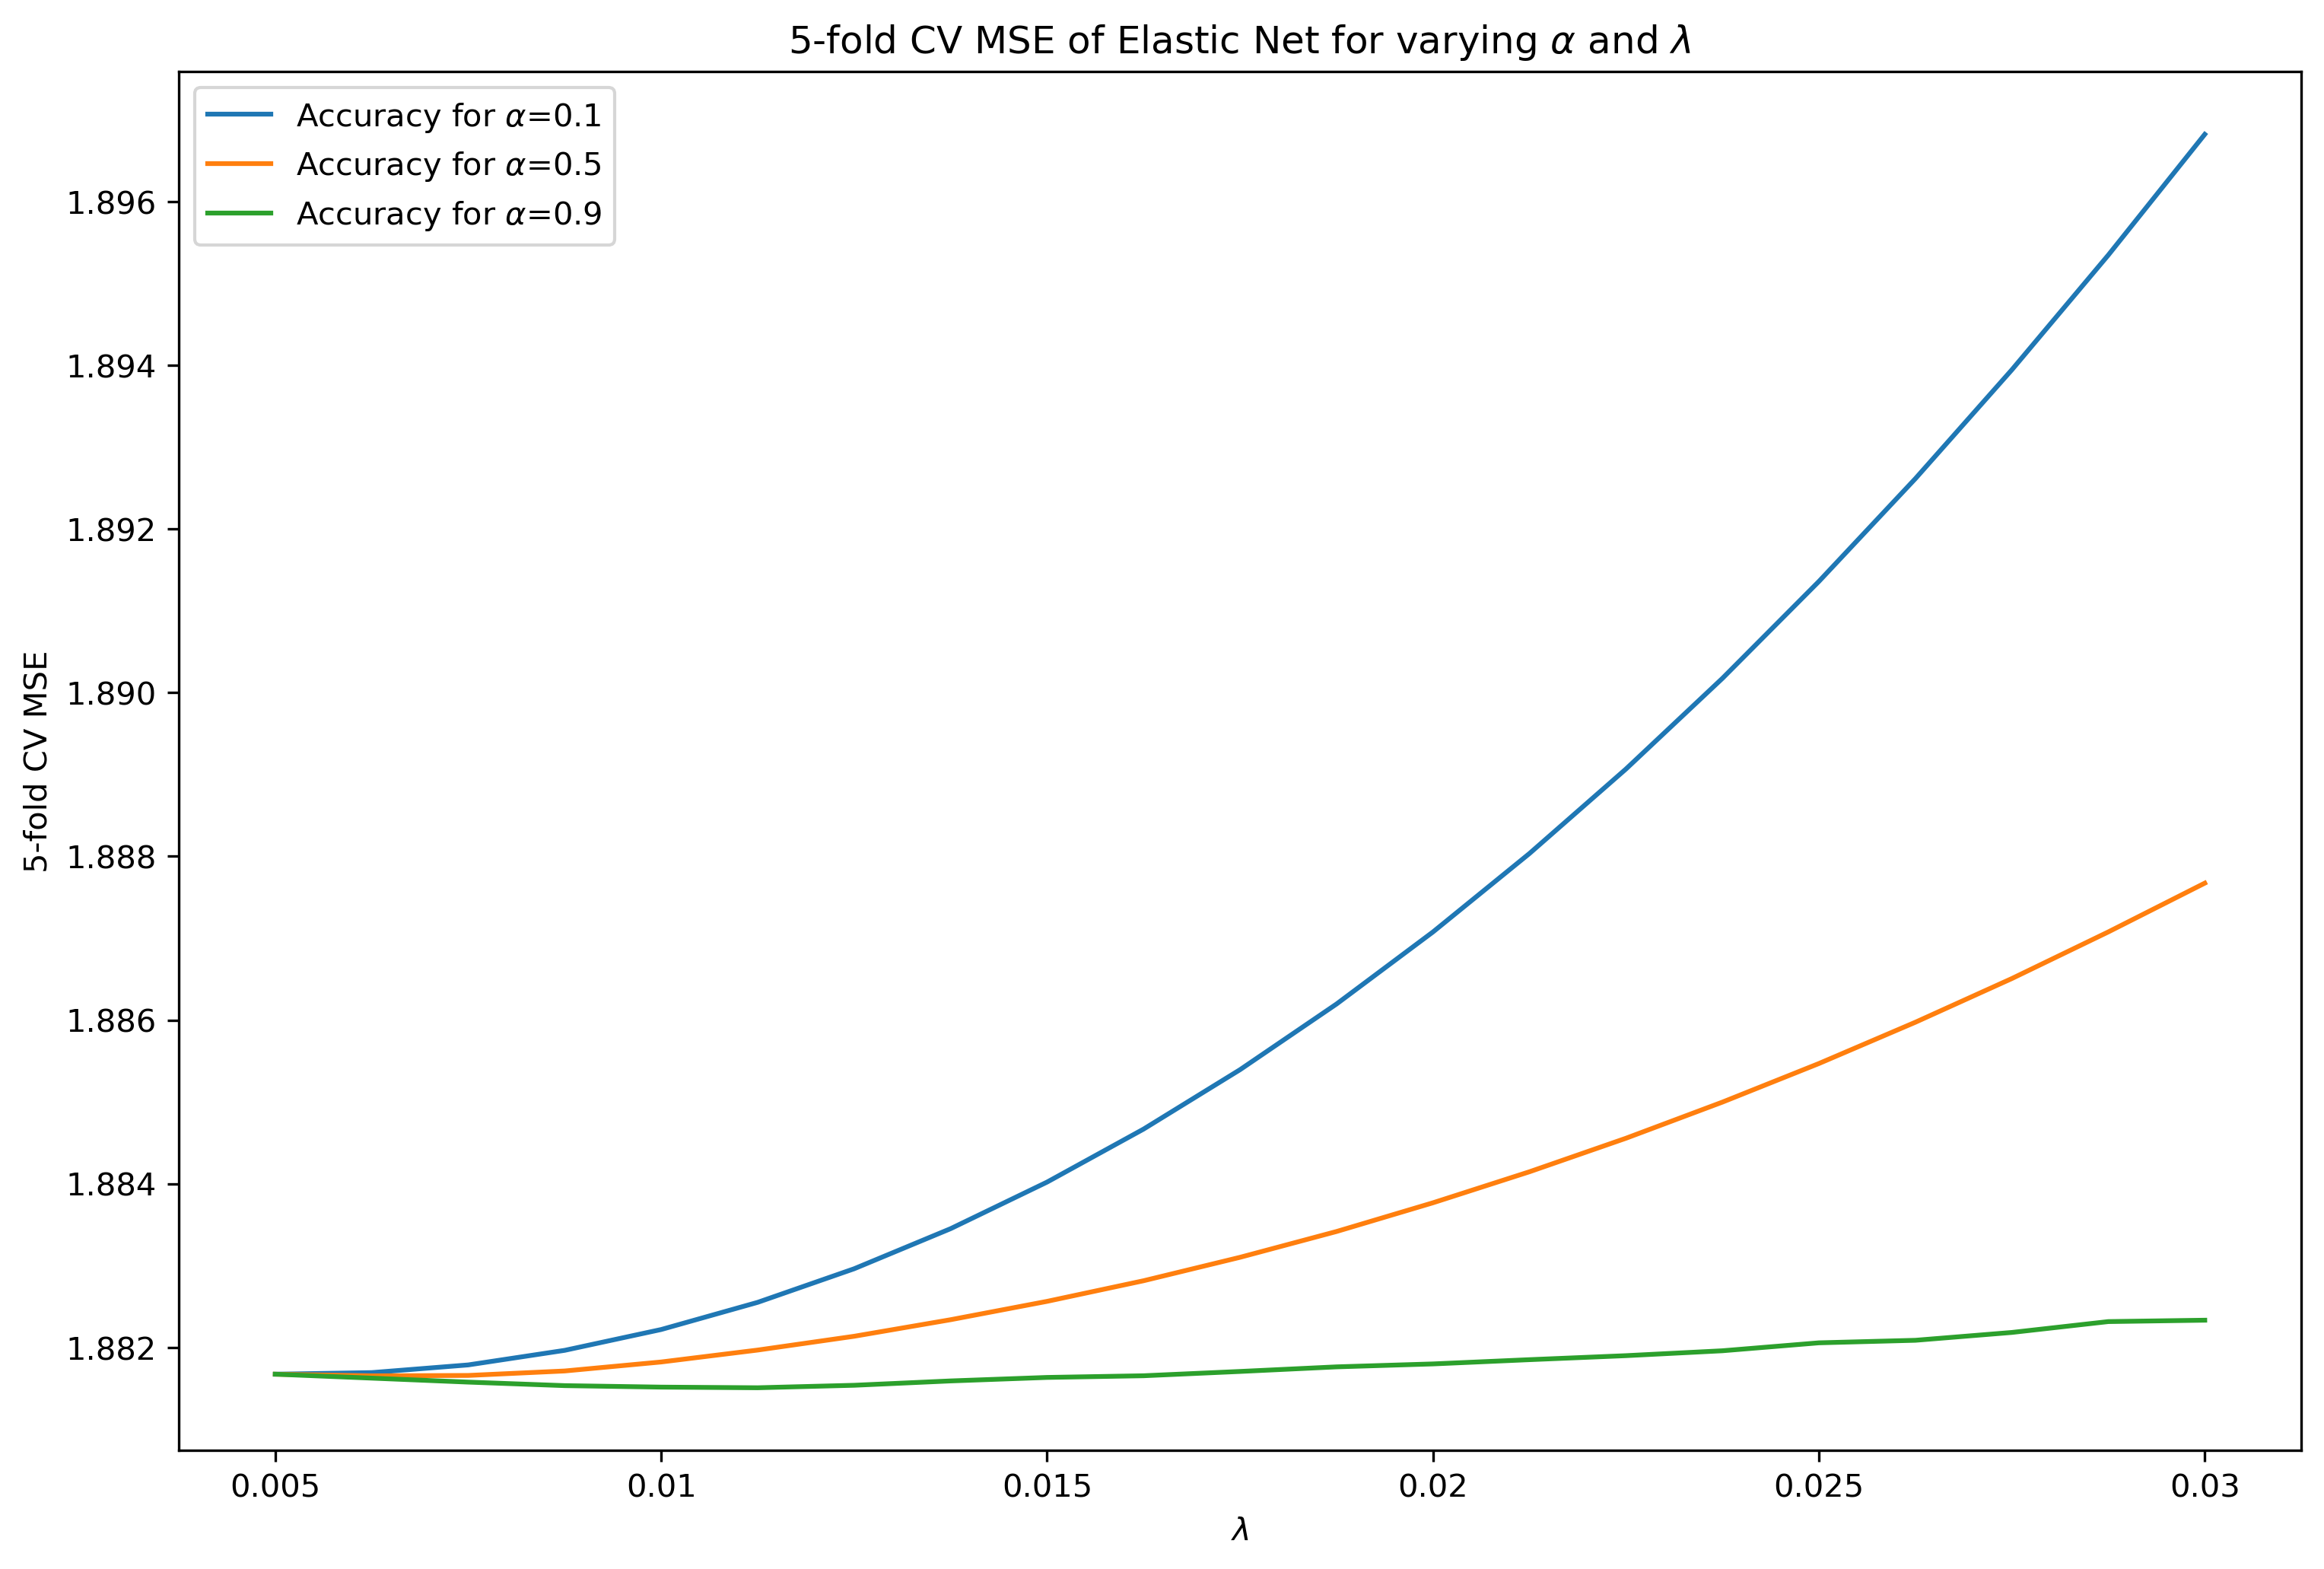

In [29]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300)
plt.title(r"5-fold CV MSE of Elastic Net for varying $\alpha$ and $\lambda$")
for a in alphas:
    plt.plot(np.linspace(0,10,21), alpha_score[a], label=fr"Accuracy for $\alpha$={a}")
ax.set_xticklabels(np.linspace(0,0.1,21))
plt.xlabel("$\lambda$")
plt.ylabel("5-fold CV MSE")
plt.legend()
plt.show()

In [30]:
for a, lam in zip(alphas, best_MSE):
    print (fr"Optimal MSE for alpha={a}: {min(alpha_score[a])} (lambda={lam})")
pd.DataFrame(best_MSE, [fr"$\alpha={a}$" for a in alphas], ['Optimal $\lambda$'])

Optimal MSE for alpha=0.1: 1.881673162639088 (lambda=0.0)
Optimal MSE for alpha=0.5: 1.8816526948076906 (lambda=0.0005)
Optimal MSE for alpha=0.9: 1.8815074037508843 (lambda=0.0025)


,Optimal $\lambda$
$\alpha=0.1$,0.0000
$\alpha=0.5$,0.0005
$\alpha=0.9$,0.0025


As we can see from the above figures, for $\alpha=0.1$  the optimal $\lambda$ is 0, which simply yields the least squares estimate. 

For $\alpha=0.5$, the optimal $\lambda$ is 0.0005, which is negligibble

However, the model with the lowest MSE, with $\alpha=0.9$, the optimal $\lambda$ is 0.0025, which will have slightly more impact on the regularisation.

This suggests that the regularisation controlled by $\lambda$ is more beneficial when weight is placed on the Lasso penalty, rather than the Ridge penalty. We have already seen that Lasso improves the test MSE and $R^2$ of the model compared to OLS

We will now retrain the model on the full dataset with $\alpha=0.9, \lambda=0.002$ and compare the out-of-sample MSE and $R^2$ to that of OLS regression.

In [31]:
np.random.seed(100)
betaEN09 = elastic_net_gradient_descent(X_train_aug_std, y_train, alpha=0.9, lam=0.002, max_iterations=1000000)
mse_test_EN09 = MSE_LS(X_test_aug_std, y_test, betaEN09)
rsquared_test_EN09 = Rsquared_LS(X_test_aug_std, y_test, betaEN09)

print('The out-of-sample MSE for EN @alpha=0.9,lambda=0.002 is ' + str(mse_test_EN09.round(4)))
print('The out-of-sample R^2 for EN @alpha=0.9,lambda=0.002 is ' + str(rsquared_test_EN09.round(4)))

print('The out-of-sample MSE for the OLS model is ' + str(mse_test.round(4)))
print('The out-of-sample R^2 for the OLS model is ' + str(rsquared_test.round(4)))



Converged in n_iterations = 60
The out-of-sample MSE for EN @alpha=0.9,lambda=0.002 is 1.9839
The out-of-sample R^2 for EN @alpha=0.9,lambda=0.002 is 0.9083
The out-of-sample MSE for the OLS model is 1.9844
The out-of-sample R^2 for the OLS model is 0.9083


In [32]:
coefs_ols_lasso_en = np.hstack((coefs_ols_lasso[:,:-1], np.round(np.reshape(betaEN09, newshape=[7,1]), 4)))
beta1_df = pd.DataFrame(coefs_ols_lasso_en, columns=['OLS parameters', 'LASSO parameters', 'Elastic Net parameters'], index=[r'$\beta_%s$' %i for i in range(len(beta_ml))])

beta1_df

,OLS parameters,LASSO parameters,Elastic Net parameters
$\beta_0$,123.9703,123.9703,123.9703
$\beta_1$,-3.5755,-3.5619,-3.5715
$\beta_2$,0.8345,0.805,0.8272
$\beta_3$,-3.9286,-3.9052,-3.9216
$\beta_4$,-0.0783,-0.0792,-0.0796
$\beta_5$,1.725,1.7131,1.7221
$\beta_6$,-0.0136,-0.0002,-0.011


Our optimal Elastic Net model, with $\alpha=0.9$ and $\lambda=0.002$, performs worse than the OLS on out-of-sample data in terms of MSE and $R^2$.

<div id="1.3.3"/>

### 1.3.3
We will now retrain the Elastic Net on the full dataset, optimising $\lambda$ for each value of $\alpha$, and visualising the effect of this regularisation on the model parameters.

In [33]:
alphas = np.linspace(0, 1, 11)
beta_dict_EN = {}
for a in alphas:
    print (f"EN with alpha = {a:.1f}")
    lam, _ = choose_best_l1_penalty_elastic_net(X_train_aug_std, y_train, t_folds=5, alpha=a, lambda_range=np.linspace(0,0.01,21), print_updates=False)

    
    beta = elastic_net_gradient_descent(X_train_aug_std, y_train, a, lam, 1000)
    beta_dict_EN[a] = beta[1:] #get rid of intercept as its boring + spoils the graph

EN with alpha = 0.0
Converged in n_iterations = 1
EN with alpha = 0.1
Converged in n_iterations = 1
EN with alpha = 0.2
Converged in n_iterations = 1
EN with alpha = 0.3
Converged in n_iterations = 29
EN with alpha = 0.4
Converged in n_iterations = 27
EN with alpha = 0.5
Converged in n_iterations = 24
EN with alpha = 0.6
Converged in n_iterations = 41
EN with alpha = 0.7
Converged in n_iterations = 53
EN with alpha = 0.8
Converged in n_iterations = 48
EN with alpha = 0.9
Converged in n_iterations = 75
EN with alpha = 1.0
Converged in n_iterations = 387


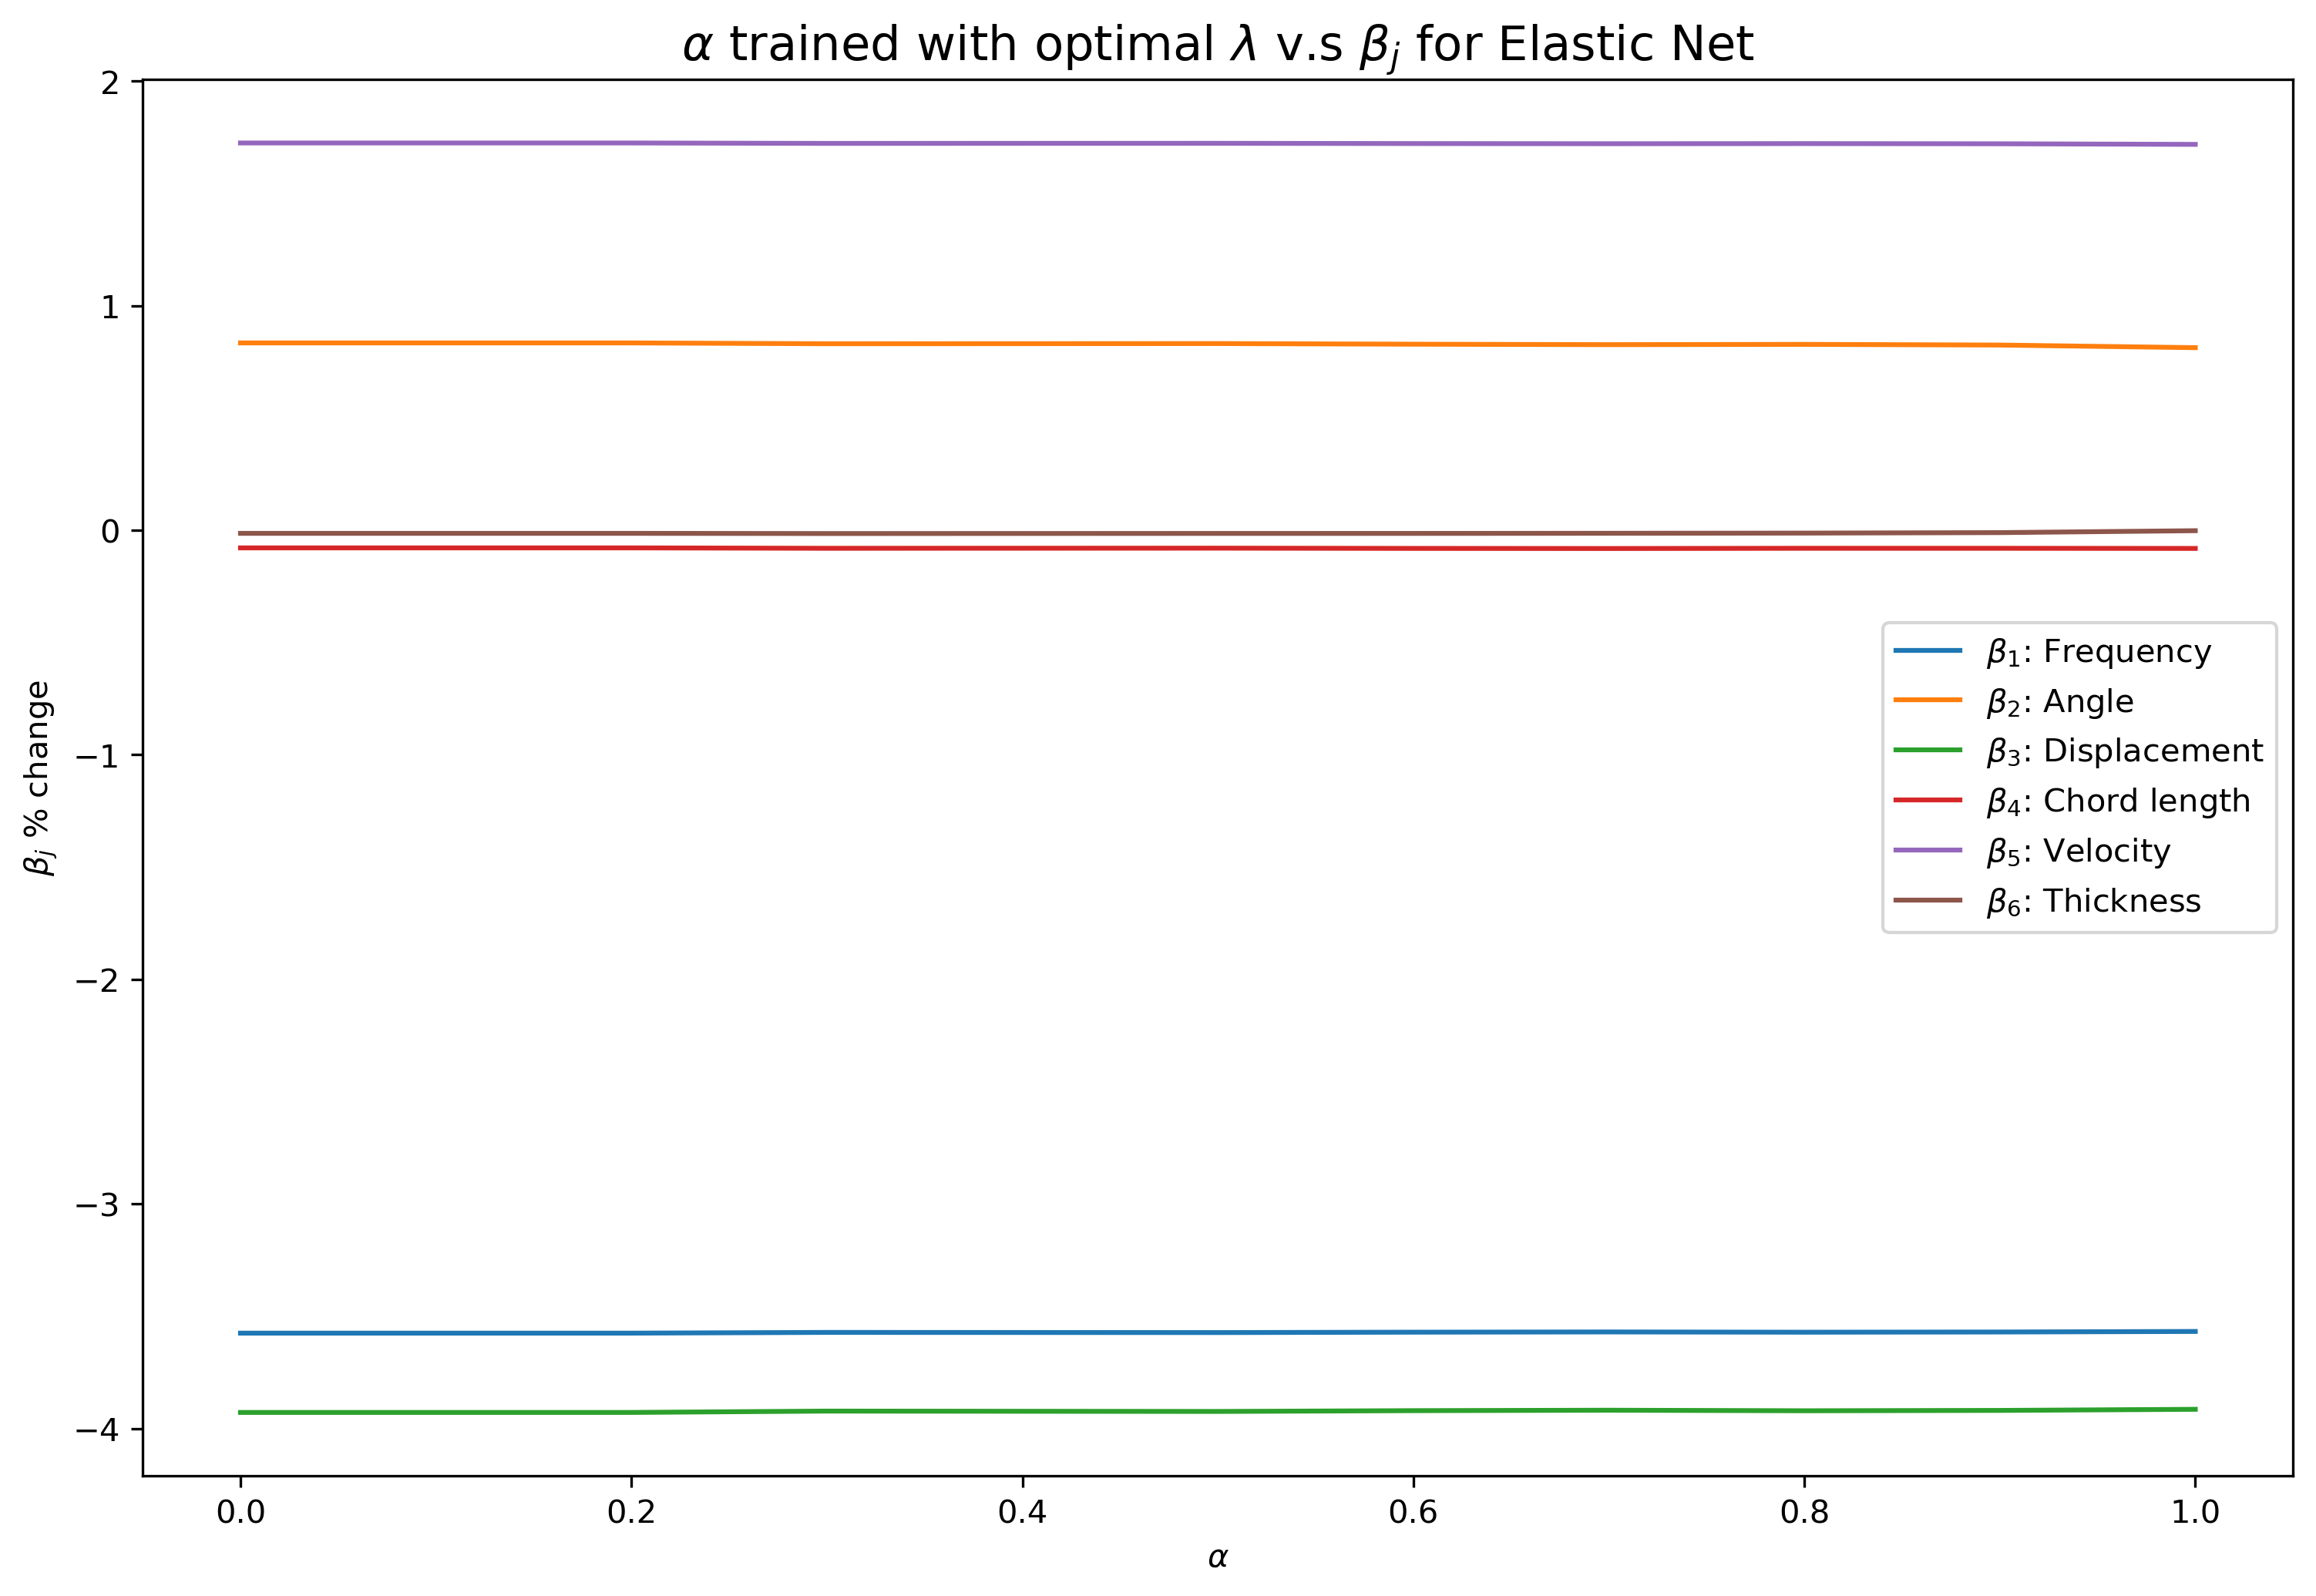

In [34]:
plt.figure(figsize=(12,8), dpi=300)
for i in range(X_train1.shape[1]-1):
    plt.plot(list(beta_dict_EN.keys()), [beta_dict_EN[alpha][i] for alpha in beta_dict_EN.keys()], label=fr"$\beta_{i + 1}$: {airfoil_noise_samples.columns[i]}")
plt.legend()
plt.ylabel(r"$\beta_j$ % change")
plt.xlabel(r"$\alpha$")
plt.title(r"$\alpha$ trained with optimal $\lambda$ v.s $\beta_j$ for Elastic Net", size=15)
plt.show()

<b>This graph is not particularly informative</b>, as the absolute changes in $\beta_j$ are very small. Below I will plot a graph of how the $\beta_j$s change proprtionally from their value with optimal $\lambda$ at $\alpha=0$:

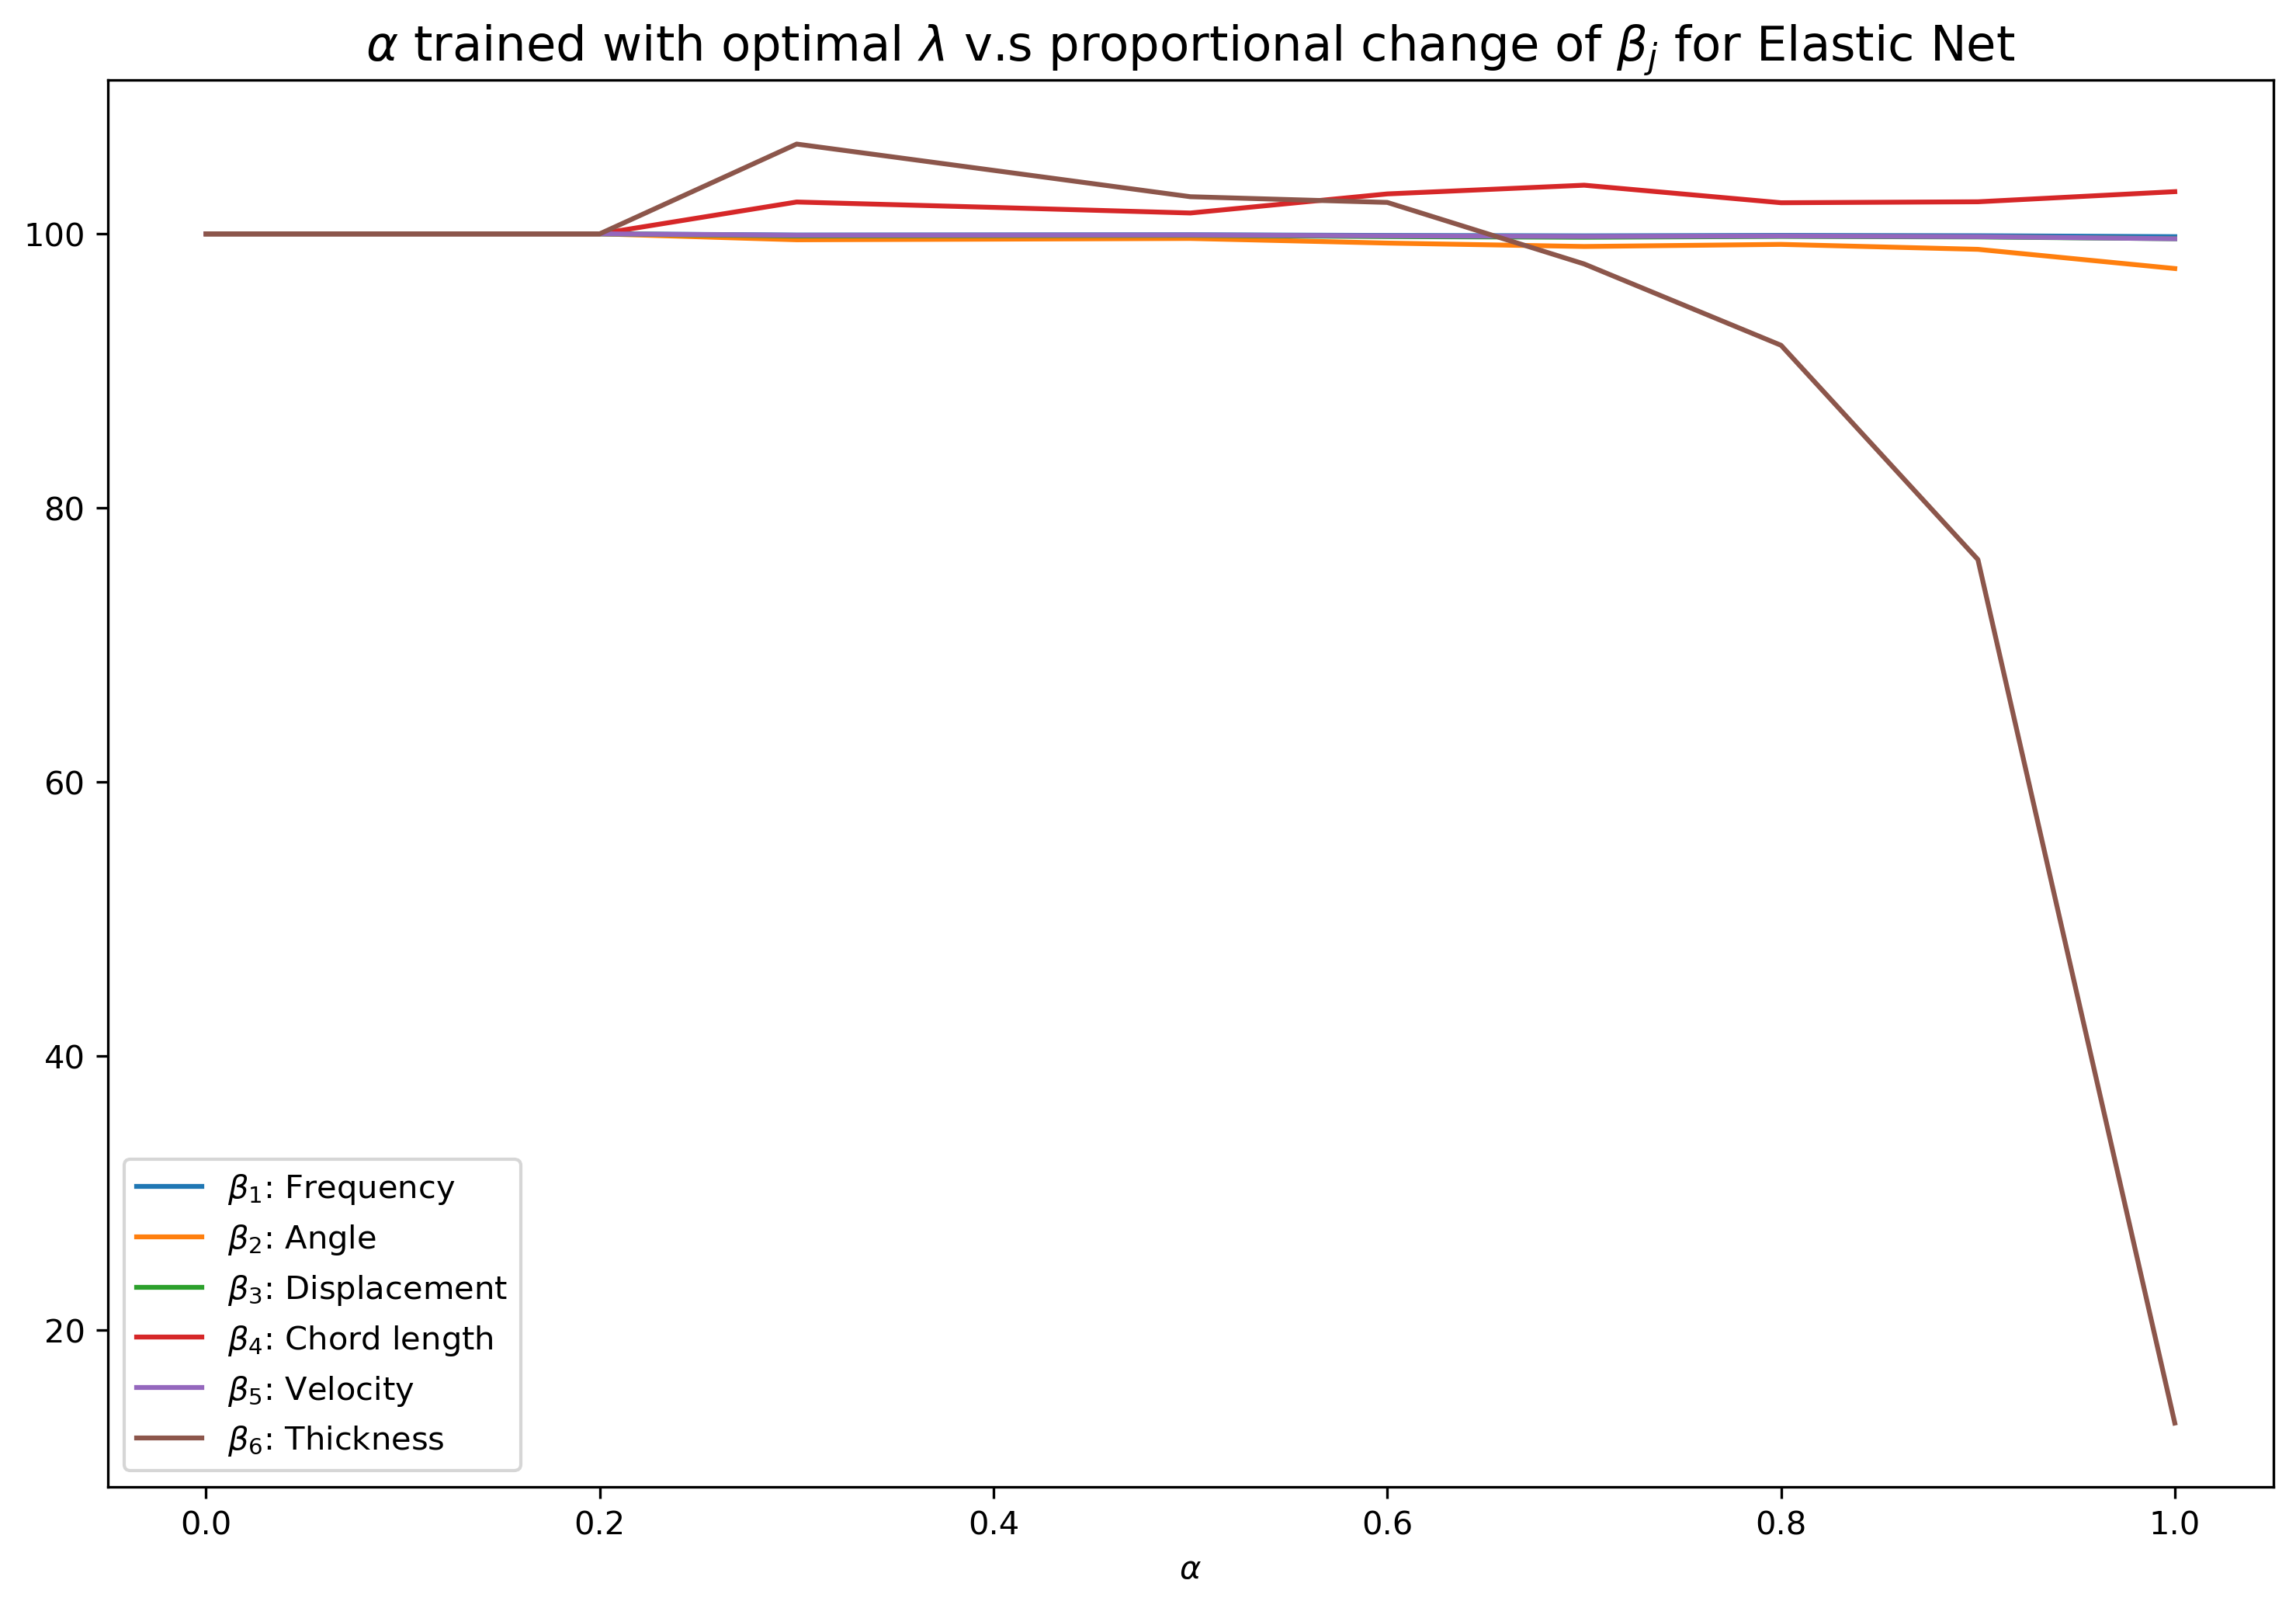

In [35]:
plt.figure(figsize=(12,8), dpi=300)
for i in range(X_train1.shape[1]-1):
    plt.plot(list(beta_dict_EN.keys()), [beta_dict_EN[alpha][i]/beta_dict_EN[0][i] * 100 for alpha in beta_dict_EN.keys()], label=fr"$\beta_{i + 1}$: {airfoil_noise_samples.columns[i]}")
plt.legend()
plt.xlabel(r"$\alpha$")
plt.title(r"$\alpha$ trained with optimal $\lambda$ v.s proportional change of $\beta_j$ for Elastic Net", size=15)
plt.show()

At $\alpha=0$ we simply have the Ridge estimate of $\lambda$. At $\alpha=0.5$ there is equal weighting on the Ridge and Lasso penalties, and at $\alpha=1$ we have the Lasso estimate.

We can see that the only parameter which sees a significant change as $\alpha$ increases is $\beta_6$, the coefficient for `Thickness`. This is likely because $\beta_6$ is already very small, and we have already seen that its exclusion improves the MSE of the model. 

However, <b>because in the Ridge penalty, the coefficient is squared,</b> $\beta_6$ is so small that it has a virtually nonexistent impact on the loss function, and so it is not reduced. However, when $\alpha$ is increased enough, and more weight is placed on the Lasso penalty, the loss function benefits more from the elimination of the $\beta_6$ coefficient, so it is shrunk and eventually excluded.

<div id="1.4"/>

## 1.4 kNN regression (10 marks)
<div id="1.4.1"/>

### 1.4.1
In this section, we will train a $k$-Nearest Neigbour regression model on the training set `airfoil_noise_samples.csv`. We will first build our `k_neighbours` function to store the values of the $k$ neighbours for each testing set. We will then perform a grid search to optimise $k$ with respect to the mean squared error and compare the results of our model with that of linear regression with and without regularisation

In [36]:
def euclidian_distance(p, q):
    """Returns the Euclidean distance between points p and q."""
    return np.sqrt(np.sum((p - q) ** 2, axis=1))

def k_neighbours(X_train, X_test, k, return_distance=False):
    """
    Finds the k nearest neighbors of each point in X_test from X_train using the Euclidean distance.

        Parameters:
            X_train (numpy.ndarray): An array of shape (n_train_samples, n_features) containing the training samples.
            X_test (numpy.ndarray): An array of shape (n_test_samples, n_features) containing the test samples.
            k (int): The number of neighbors to consider.
            return_distance (bool, optional): Whether to return the distances in addition to the indices. Defaults to False.
    
        Returns:
            numpy.ndarray: An array of shape (n_test_samples, k) containing the indices of the k nearest neighbors for each test sample. If return_distance is True, also returns an array of shape (n_test_samples, k) containing the distances of the k nearest neighbors for each test sample.
    
        Raises:
            ValueError: If k is greater than the number of training samples.
    """
    n_neighbours = k
    dist = []
    neigh_ind = []
    
    # compute distance from each point x_test in X_test to all points in X_train (hint: use python's list comprehension)
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]
        
        #generate list of indices of nearest neighbours
        ind_list = [tup[0] for tup in sorted_neigh]
        #generate list of distances of nearest neighbours
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)
    
    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)
    
    return np.array(neigh_ind)

def predict_KNN(X_train, y_train, X_test, k):
    """
    Predicts the outcome of X_train based on k-nearest neighbours.
    
        Parameters:
            X_train (numpy.ndarray)): training data of shape (N,D)
            y_train (numpy.ndarray)): training labels of shape (N,)
            X_test (numpy.ndarray)): test data of shape (K, D)
            k (int): number of neighbours to consider
        
        Returns:
            y_pred (numpy.ndarray)): a vector of predictions for each datapoint in X_test
    """
    # each of the k neighbours contributes equally to the clasification of any data point in X_test  
    neighbours = k_neighbours(X_train, X_test, k)
    # average predictions of the k neighours
    y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours])

    return y_pred

def MSE_KNN(X_train, y_train, X_test, y_test, k):
    """
    Calculates the mean squared error (MSE) of the k-nearest neighbor (KNN) regression model on the given test set.

        Parameters:
            X_train (numpy.ndarray): An array of shape (n_train_samples, n_features) containing the training samples.
            y_train (numpy.ndarray): An array of shape (n_train_samples,) containing the target values for the training samples.
            X_test (numpy.ndarray): An array of shape (n_test_samples, n_features) containing the test samples.
            y_test (numpy.ndarray): An array of shape (n_test_samples,) containing the target values for the test samples.
            k (int): The number of neighbors to consider.
    
        Returns:
            float: The mean squared error of the KNN model on the given test set.
    
        Raises:
            ValueError: If k is greater than the number of training samples.
    """
    y_pred = predict_KNN(X_train, y_train, X_test, k)
    return np.mean([(y_pred[i] - y_test[i]) ** 2 for i in range(len(y_pred))])

print('Training set mean MSE for k=3:', MSE_KNN(X_train, y_train, X_train, y_train, k=3))
print('Test set mean MSE for k=3:', MSE_KNN(X_train, y_train, X_test, y_test, k=3))

Training set mean MSE for k=3: 5.428834850276653
Test set mean MSE for k=3: 12.093405577879112


In [38]:
def cross_validation_score_MSE_KNN(X_train, y_train, folds, k):
    """
    Calculate the cross validation MSE of a kNN regressor.
    
        Parameters:
            X_train (numpy.ndarray): training data of shape (N,D)
            y_train (numpy.ndarray): training labels of shape (N,)
            folds (numpy.ndarray): array of folds indices
            k (int): the number of neighbours to consider
    
        Returns:
            (float): the k-fold CV MSE of the model trained
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
    
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
    
        score_i = MSE_KNN(X_train_i, y_train_i, X_val_i, y_val_i, k)
        scores.append(score_i)

    return np.mean(scores)

def choose_best_k(X_train, y_train, t_folds=5, k_range=np.arange(1,11)):
    """
    Chooses the optimal k which minimises the t_folds CV MSE of the kNN regression model.
        
        Parameters:
            X_train (numpy.ndarray): training data of shape (N,D)
            y_train (numpy.ndarray): training labels of shape (N,)
            t_folds (int): number of folds to use in cross validation
            k_range (iterable): the range over which to search for optimal k
            
        Returns:
            (float): the optimal k minimising MSE
    """
    p = np.random.permutation(len(y_train))
    X_train = X_train[p]
    y_train = y_train[p]
    folds_indexes = np.split(np.arange(len(y_train)), t_folds)
    k_scores = np.zeros((len(k_range),))
    
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score_MSE_KNN(X_train, y_train, folds_indexes, k)
        print(f'CV_MSE@k={k}: {k_scores[i]:.3f}')

    best_k_index = np.argmin(k_scores)
    return k_range[best_k_index]

optimal_k = choose_best_k(X_train_std, y_train, t_folds=5, k_range=np.arange(1,15))

CV_MSE@k=1: 5.229
CV_MSE@k=2: 3.815
CV_MSE@k=3: 3.402
CV_MSE@k=4: 3.209
CV_MSE@k=5: 3.081
CV_MSE@k=6: 3.023
CV_MSE@k=7: 3.031
CV_MSE@k=8: 3.021
CV_MSE@k=9: 3.010
CV_MSE@k=10: 3.013
CV_MSE@k=11: 3.009
CV_MSE@k=12: 3.014
CV_MSE@k=13: 3.026
CV_MSE@k=14: 3.046


We see that the optimal kNN model has hyperparameter $k=9$. We now train our model on the whole dataset and find the MSE of the model on the test set.

<div id="1.4.2"/>

### 1.4.2

In [39]:
mse_test_knn = MSE_KNN(X_train_std, y_train, X_test_std, y_test, 9)

In [40]:
summary_data = [[mse_test, rsquared_test],
                [mse_test_lasso, rsquared_test_lasso],
                [mse_test_EN09, rsquared_test_EN09],
                [mse_test_knn, 'n/a']]

summary = pd.DataFrame(summary_data, ['Least Squares', 'Pure LASSO', 'Elastic Net', '$k$-NN'], ['Test MSE', 'Test $R^2$'])

summary

,Test MSE,Test $R^2$
Least Squares,1.984390,0.908317
Pure LASSO,1.981315,0.908459
Elastic Net,1.983918,0.908339
$k$-NN,2.983524,n/a


Our $k$-NN MSE is significantly higher than that of the standard least squares, as well as the LASSO and Elastic Net. This indicates that the relationship is linear and therefore a linear model is more appropriate, providing more predictive power. Out of all the models we have tested, the Elastic Net proved the most accurate when trained on the whole training set and evaluated on the testing set.

All three linear models performed better than the $k$-NN regressor. We can therefore conclude with reasonable conviction that there is a significant linear relationship between predictors and outcome on this dataset.

<div id="2"/>

# Task 2: Classification  (50 marks)



<div id="2.1"/>

## 2.1 Random forest (20 marks)
<div id="2.1.1"/>

### 2.1.1

We implement a random forest classifier on the diabetes dataset, to predict the incidence of diabetes based on a number of medical statistics.

The hyperparameters we will tune are `n_trees` and `depth`. We will set `n_features` in each bootstrap sample to `total_features//3`, as is recommended in the literature.

We will begin by exploring our data and preparing it for classification.

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict

diabetes_samples = pd.read_csv('diabetes_samples.csv', decimal=",")
diabetes_test = pd.read_csv('diabetes_test.csv', decimal=",") #Convert to normal float
#sns.pairplot(diabetes_samples)

diabetes_samples.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,115,224,85,30,7.5,36,69,205,30.3,150,99,37,41,0.90,No diabetes
1,318,194,95,36,5.4,63,58,210,43.9,140,100,44,53,0.83,No diabetes
2,73,207,75,44,4.7,30,72,180,24.4,118,62,35,41,0.85,No diabetes
3,69,144,81,28,5.1,30,72,165,22.4,118,78,31,38,0.82,No diabetes
4,326,181,177,24,7.5,64,71,225,31.4,130,66,44,47,0.94,Diabetes


From the pairplot (excluded for presentation) we see that `patient_number` is almost perfectly correlated with age, and unlikely to affect the patient outcome (patients likely numbered in age ascending order), so we exclude it from the predictors. We see some positive association between waist, hip and weight but include them nonetheless as the random forest performs well in spite of correlated variables.

We now define our cross entropy function based on the following.

Let $R_{\alpha}$ be a region where the node impurity is given by:

$$
\pi_q (R_{\alpha}) = \frac{\sum_{i=1}^N I(\textbf{x}^{(i)} \in R_{\alpha} \land y^{(i)} \in x_q)}{\sum_{i=1}^N I(\textbf{x}^{(i)} \in R_{\alpha})}
$$

then the loss function which we seek to minimise at each split, which in this case is the cross entropy, is given by

$$
\text{CE}[\pi,\hat\pi] = - \sum_{q=1}^Q \pi_q (R_{\alpha}) \log \hat{\pi}_q (R_{\alpha})
$$

In this case, for the binary class Random Forest, we have

$$
\text{CE}(R) = p \log p + (1-p) \log (1-p)
$$

where $p$ is the probability that a randomly selected datapoint in $R$ has class 1.

In [42]:
predictors = ["cholesterol", "glucose","hdl_chol", "chol_hdl_ratio","age","height","weight","bmi","systolic_bp","diastolic_bp","waist","hip", "waist_hip_ratio"]
target = "diabetes"

#Assign the binary classes a numeric value in {0,1}
class_map = lambda c: 1 if c == "Diabetes" else 0

#Leave the X as a pandas array (to preserve column names)
X_train = diabetes_samples[predictors]
y_train = np.array([class_map(c) for c in diabetes_samples[target]])

X_test = diabetes_test[predictors]
y_test = np.array([class_map(c) for c in diabetes_test[target]])

sample_weights = np.ones_like(y_train) / len(y_train)
columns_dict = {index: False for index in range(X_train.shape[1])}

def cross_entropy(y, sample_weights):
    """
    Calculates the cross-entropy of a set of samples with respect to their true labels.

        Parameters:
            y (numpy.ndarray): An array of shape (n_samples,) containing the true labels for each sample.
            sample_weights (numpy.ndarray): An array of shape (n_samples,) containing the weights for each sample.
    
        Returns:
            float: The cross-entropy of the samples.
    
        Raises:
            ValueError: If the shapes of y and sample_weights do not match, or if any weight is negative.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    entropy = 0
    for label, weight in label_weights.items():
        p = weight / total_weight
        entropy -= p * np.log2(p)
    return entropy

def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
        1. equals value, in case `column` is categorical, or
        2. less than value, in case `column` is not categorical (i.e. numerical)

        Parameters:
            X (pd.DataFrame): training features, of shape (N, D).
            y (numpy.ndarray): vector of training labels, of shape (N,).
            sample_weights (numpy.ndarray): weights for each samples, of shape (N,).
            column (int): the column of the feature for splitting.
            value (float): splitting threshold  the samples 
            categorical (bool): indicating whether column is a categorical variable or numerical.
        Returns:
            tuple(numpy.ndarray): tuple of subsets of X splitted based on column-th value.
            tuple(numpy.ndarray): tuple of subsets of y splitted based on column-th value.
            tuple(numpy.ndarray): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)
    
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

def entropy_split_value(X, y, sample_weights, column, categorical):
    """
    Calculates the best threshold for splitting the data based on the entropy of the labels.

    Args:
        X (numpy.ndarray): An array of shape (n_samples, n_features) containing the features for each sample.
        y (numpy.ndarray): An array of shape (n_samples,) containing the true labels for each sample.
        sample_weights (numpy.ndarray): An array of shape (n_samples,) containing the weights for each sample.
        column (int): The index of the feature column to split on.
        categorical (bool): Whether the feature is categorical or continuous.

    Returns:
        tuple: A tuple containing the entropy of the split and the threshold value for the feature.

    Raises:
        AssertionError: If there is only one distinct value for the feature, or if one of the sides of the split is empty.
        ValueError: If the shapes of X, y, and sample_weights do not match.
    """
    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    entropy_index_val, threshold = np.inf, None
    
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
        
        p_left = sum(w_l) / (sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r)
        if new_cost < entropy_index_val:
            entropy_index_val, threshold = new_cost, value
      
    return entropy_index_val, threshold

def entropy_split(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    
        Parameters:
            X (numpy.ndarray): training features, of shape (N, D).
            y (numpy.ndarray): vector of training labels, of shape (N,).
            sample_weights (numpy.ndarray): weights for each samples, of shape (N,).
            columns_dict (dict): a dictionary mapping column indices to whether the column is categorical or numerical variable.
            
        Returns:
            (int, float): the best feature index and value used in splitting. 
            If the feature index is None, then no valid split for the current Node.
    """
    
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    # UPDATED LINE: initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_entropy_index, split_column, split_val = np.inf, None, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        entropy_index, val = entropy_split_value(X, y, sample_weights, column, categorical)  ## <-- SOLUTION         
        if entropy_index < min_entropy_index:
            min_entropy_index, split_column, split_val = entropy_index, column, val

    return min_entropy_index, split_column, split_val


In [43]:
def majority_vote(y, sample_weights):
    """
    Return the label which appears the most in y.
    
        Parameters:
            y (numpy.ndarray): vector of training labels, of shape (N,).
            sample_weights (numpy.ndarray): weights for each samples, of shape (N,).
            
        Returns:
            (int): the majority label
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
    return max(majority_label, key=majority_label.get)

def build_tree(n_features, X, y, sample_weights, columns_dict, feature_names, depth, max_depth=10, min_samples_leaf=2):
    """Build the decision tree according to the data X.
    
        Parameters:
            X: (pandas.DataFrame) training features, of shape (N, D).
            y: (numpy.ndarray) vector of training labels, of shape (N,).
            sample_weights (numpy.ndarray): weights for each samples, of shape (N,).
            columns_dict (dict): a dictionary mapping column indices to whether the column is categorical or numerical variable.
            feature_names (list): record the name of features in X in the original dataset.
            depth (int): current depth for this node.
            
        Returns:
            (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
                1. 'feature_name': The column name of the split.
                2. 'feature_index': The column index of the split.
                3. 'value': The value used for the split.
                4. 'categorical': indicator for categorical/numerical variables.
                5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
                6. 'left': The left sub-tree with the same structure.
                7. 'right' The right sub-tree with the same structure.
            Example:
                mytree = {
                    'feature_name': 'petal length (cm)',
                    'feature_index': 2,
                    'value': 3.0,
                    'categorical': False,
                    'majority_label': None,
                    'left': {
                        'feature_name': str,
                        'feature_index': int,
                        'value': float,
                        'categorical': bool,
                        'majority_label': None,
                        'left': {..etc.},
                        'right': {..etc.}
                    }
                    'right': {
                        'feature_name': str,
                        'feature_index': int,
                        'value': float,
                        'categorical': bool,
                        'majority_label': None,
                        'left': {..etc.},
                        'right': {..etc.}
                    }
                }
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same, (iii) depth exceed, or (iv) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}
    
    EV, split_index, split_val = entropy_split(n_features, X, y, sample_weights, columns_dict)  ## <-- SOLUTION

    # If no valid split at this node, use majority vote.
    if split_index is None:
        return {'majority_label': majority_vote(y, sample_weights)}
    
    if EV == np.inf:
        return {'majority_label': majority_vote(y, sample_weights)}
    
    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical) ## <-- SOLUTION
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    
        Parameters:
            x: ((pandas.Dataframe) a single sample features, of shape (D,).
            
        Returns:
            (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None: 
        return tree['majority_label']
    
    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

def train_rf(B, n_features, X, y,  columns_dict, sample_weights=None, max_depth=20):
    """
    Train a random forest on the dataset X
        
        Parameters
            B (int): number of decision trees.
            n_features (int): number of (random) fetures to consider at each split
            X: (pandas.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
            y: (numpy.ndarray) vector of training labels, of shape (N,)
            columns_dict (dict): a dictionary mapping column indices to whether the column is categorical or numerical variable.
            sample_weights (numpy.ndarray): weights for each samples, of shape (N,). Default value is None, which assigns equal weights to each data item
            max_depth (int): the maximum depth for each decision tree
            
        Returns:
            (list[dict]): a trained Random Forest
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, depth=1, max_depth=max_depth)
        trees.append(tree)

    return trees

def predict_rf(rf, X, return_probability=False):
    """
    Predicts the classification labels for input data using a trained random forest model.

        Parameters:
            rf (list[dict]): A list of decision trees constituting a trained random forest model.
            X (pandas.DataFrame): Input data to be classified, where each row is an observation and each column a feature.
            return_probability (bool, default=False):
                If True, returns the probability of the positive class instead of the predicted class label.
    
        Returns:
            numpy.ndarray: An array of predicted class labels or class probabilities.
    """

    def aggregate(decisions):
        """Aggregates decisions of trees in RF"""
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        if return_probability:
            return count[1] / (count[1] + count[0])
        else:
            return max(count, key=count.get)

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

def rf_score(rf, X_test, y_test):
    """Returns accuracy of rf on test data X_test"""
    y_pred = predict_rf(rf, X_test)
    return np.mean(y_pred==y_test)

#rf = train_rf(B, n_features, X_train, y_train, columns_dict)

#print(rf_score(rf, X_test.to_numpy(), y_test))

def cross_validation_score_rf(X_train, y_train, folds, B, n_features, sample_weights=None, max_depth=20):
    """
    Returns t-fold CV accuracy of rf trained with varying hyperparameters on X_train
    
        Parameters:
            X_train: (pandas.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
            y: (numpy.ndarray) vector of training labels, of shape (N,)
            folds (numpy.ndarray): indices of folds to validate
            B (int): number of decision trees.
            n_features (int): number of (random) fetures to consider at each split
            sample_weights (numpy.ndarray): weights for each samples, of shape (N,).
            max_depth (int): the maximum depth for each decision tree
            
        Returns:
            (float) the t-fold CV accuracy with given hyperparameters
    """
    
    if sample_weights is None:
        sample_weights = np.ones(X_train.shape[0]) / X_train.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)
    
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        X_train_i = X_train.loc[train_indexes]
        y_train_i = y_train[train_indexes]
    
    
        X_val_i = X_train.loc[val_indexes]
        y_val_i = y_train[val_indexes]
        
        rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, sample_weights=sample_weights, max_depth=max_depth)
        score_i = rf_score(rf, X_val_i.to_numpy(), y_val_i)
        scores.append(score_i)

    return np.mean(scores)

In [44]:
###THIS CELL TAKES A LONG TIME TO RUN

depth_range = range(1, 16, 2)
B_range = range(1, 142, 20)
n_features = 4 #feature number recommended in the literature

accuracy_matrix = [[0 for j in range(len(B_range))] for i in range(len(depth_range))]
#print(acc)

max_accuracy = 0
max_accuracy_values = (0, 0)

folds = np.array_split(np.arange(len(y_train)), 4)

for i, depth in enumerate(depth_range):
    print ("iteration " + str(i + 1) + " of 8")
    for j, b in enumerate(B_range):
        accuracy = cross_validation_score_rf(X_train, y_train, folds, b, n_features, sample_weights, depth)
        accuracy_matrix[i][j] = round(accuracy, 5)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_values = (depth, b)

print (max_accuracy, max_accuracy_values)

iteration 1 of 8
iteration 2 of 8
iteration 3 of 8
iteration 4 of 8
iteration 5 of 8
iteration 6 of 8
iteration 7 of 8
iteration 8 of 8
0.9121376811594204 (13, 21)


This code performs a grid search over hyperparameters depth and number of trees (B) for a random forest classifier. The grid of hyperparameters is defined as follows: depth ranges from 1 to 15 with a step of 2, and B ranges from 1 to 141 with a step of 20. n_features is set to the square root of the total number of features, which is a common value for random forest classifiers.

The accuracy of the random forest is computed using 4-fold cross-validation on the training set. The accuracy score is stored in a 2D list called accuracy_matrix, where the rows correspond to the values of depth, and the columns correspond to the values of B.

The loop also tracks the maximum accuracy score achieved so far and the hyperparameter values that led to it. The loop prints out the iteration number as it progresses. The final output is the maximum accuracy and the hyperparameter values that led to it.

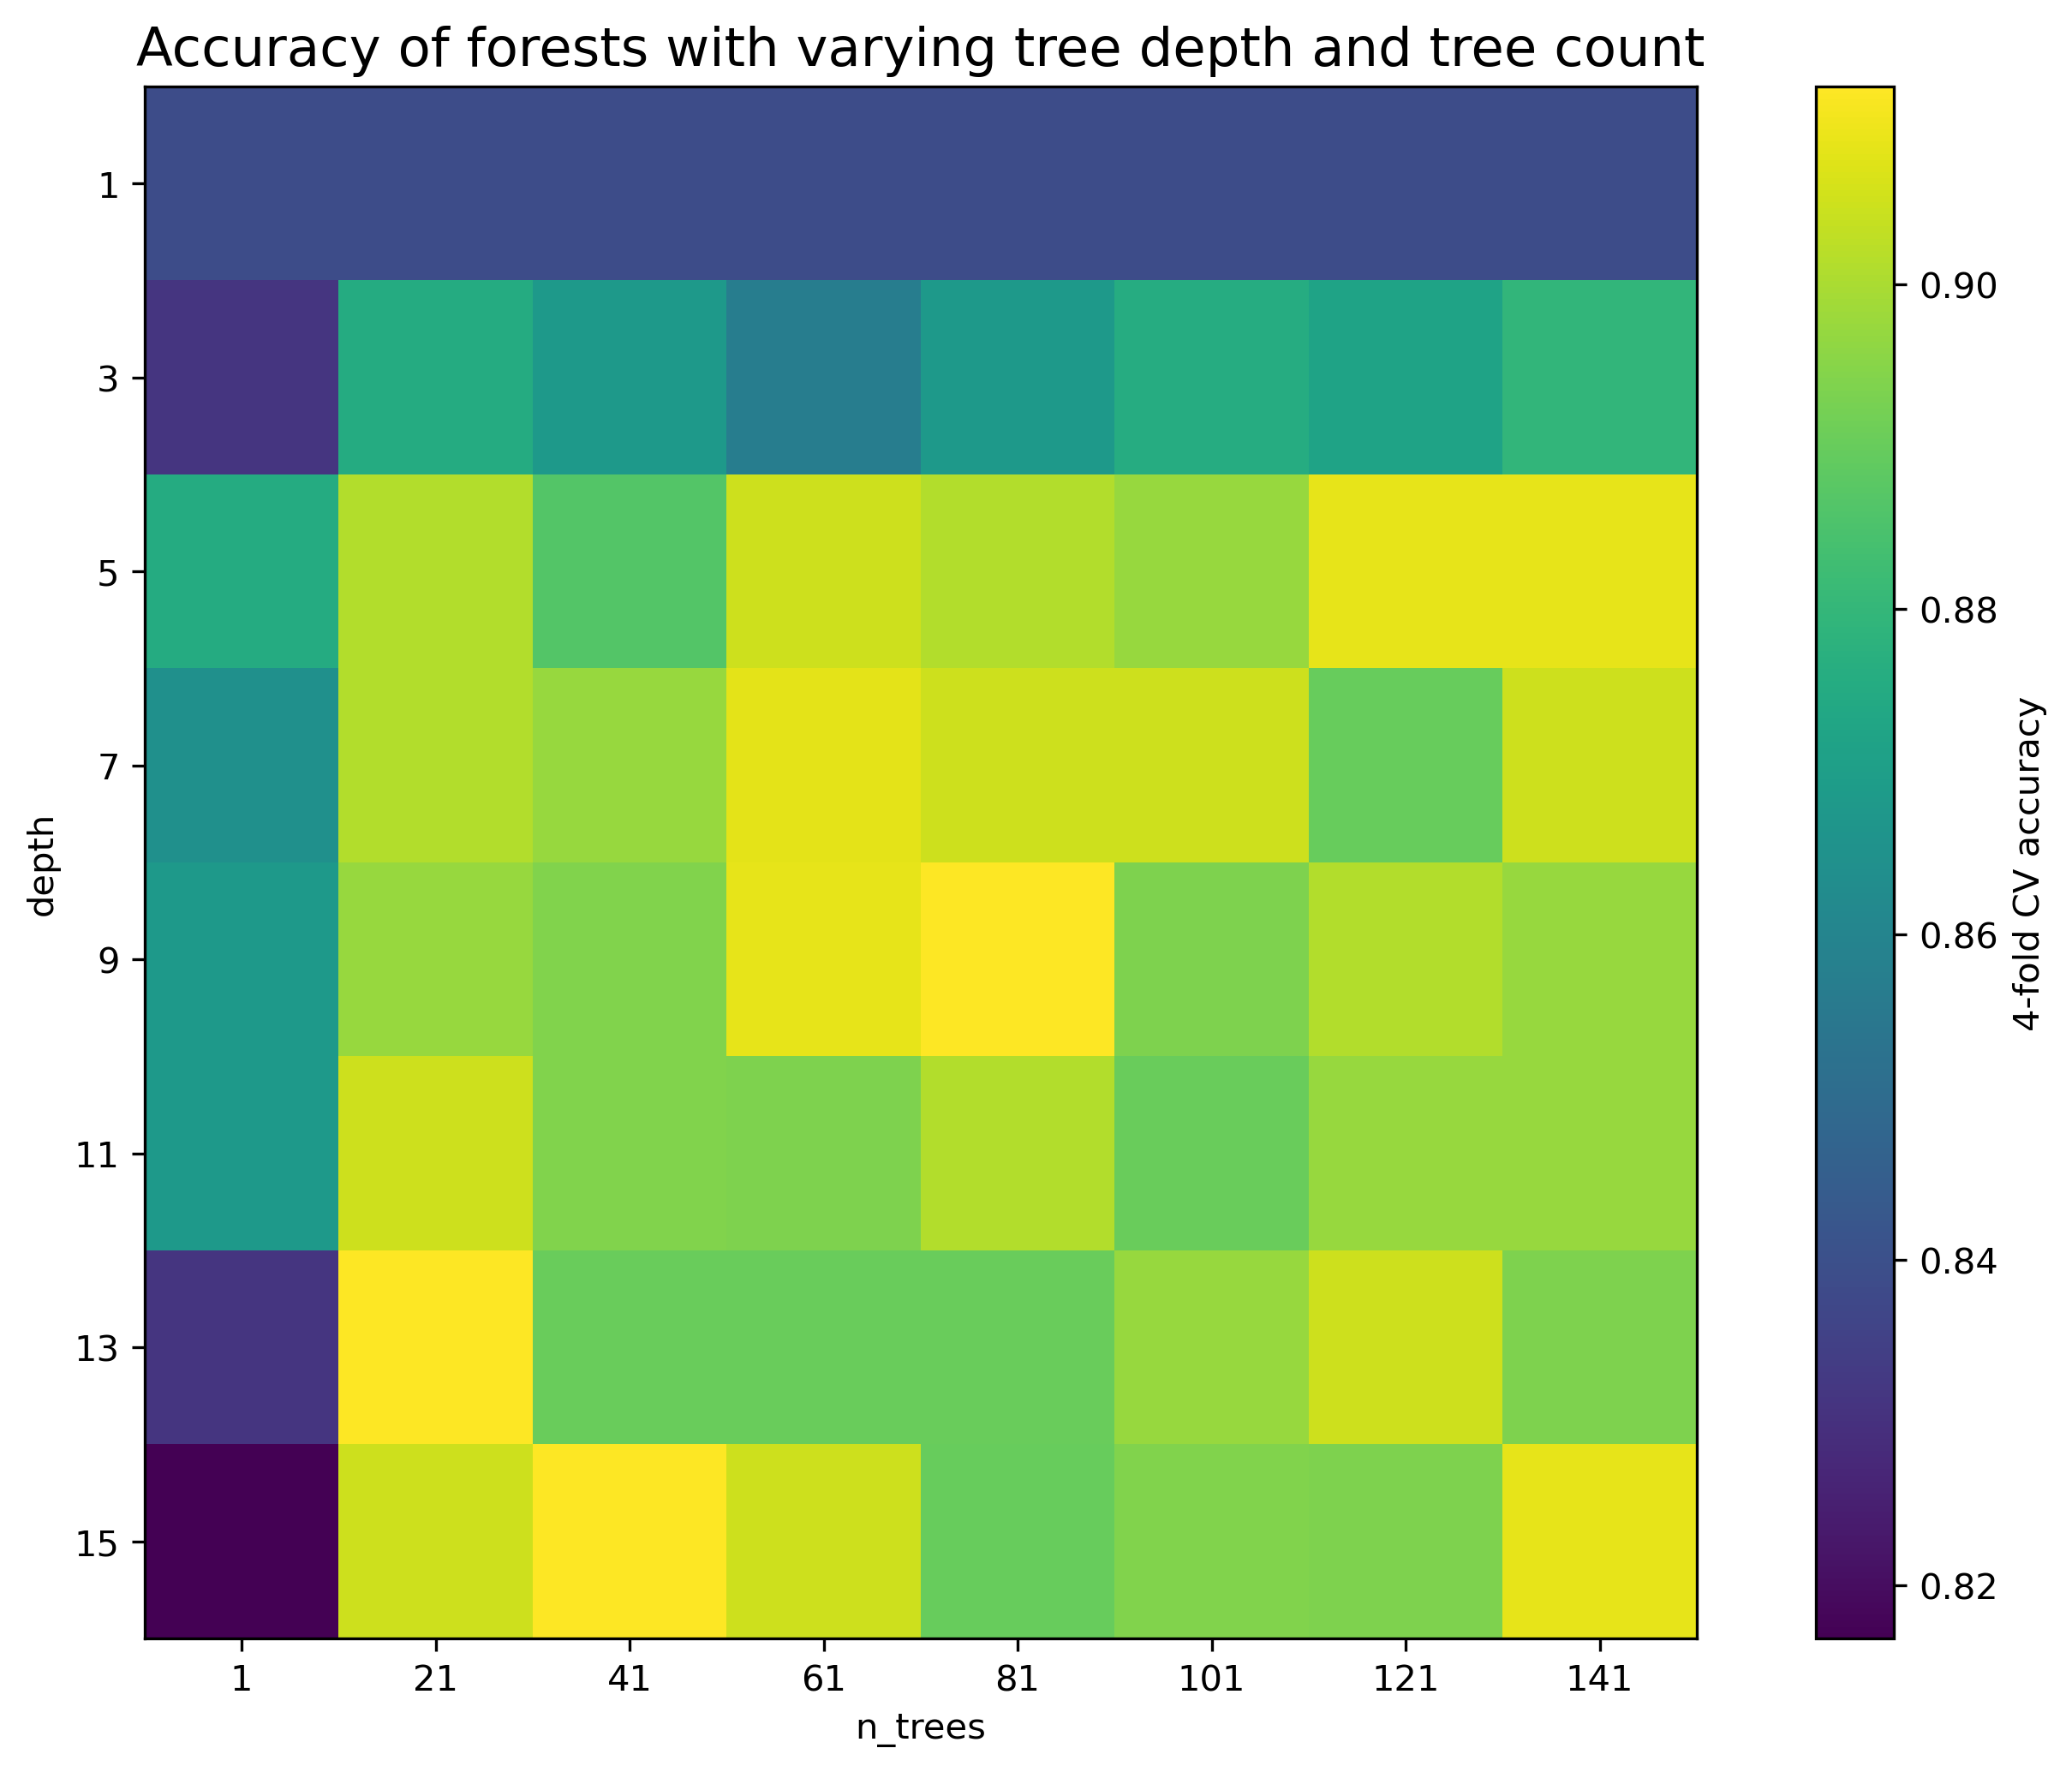

In [45]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300)

plt.title("Accuracy of forests with varying tree depth and tree count", size=15)
plt.imshow(accuracy_matrix)
plt.xlabel('n_trees')
plt.ylabel('depth')
plt.colorbar(label="4-fold CV accuracy")

# set ticks followed by setting labels
ax.set_xticks(range(len(B_range)))
ax.set_xticklabels(B_range)

ax.set_yticks(range(len(depth_range)))
ax.set_yticklabels(depth_range)

plt.show()

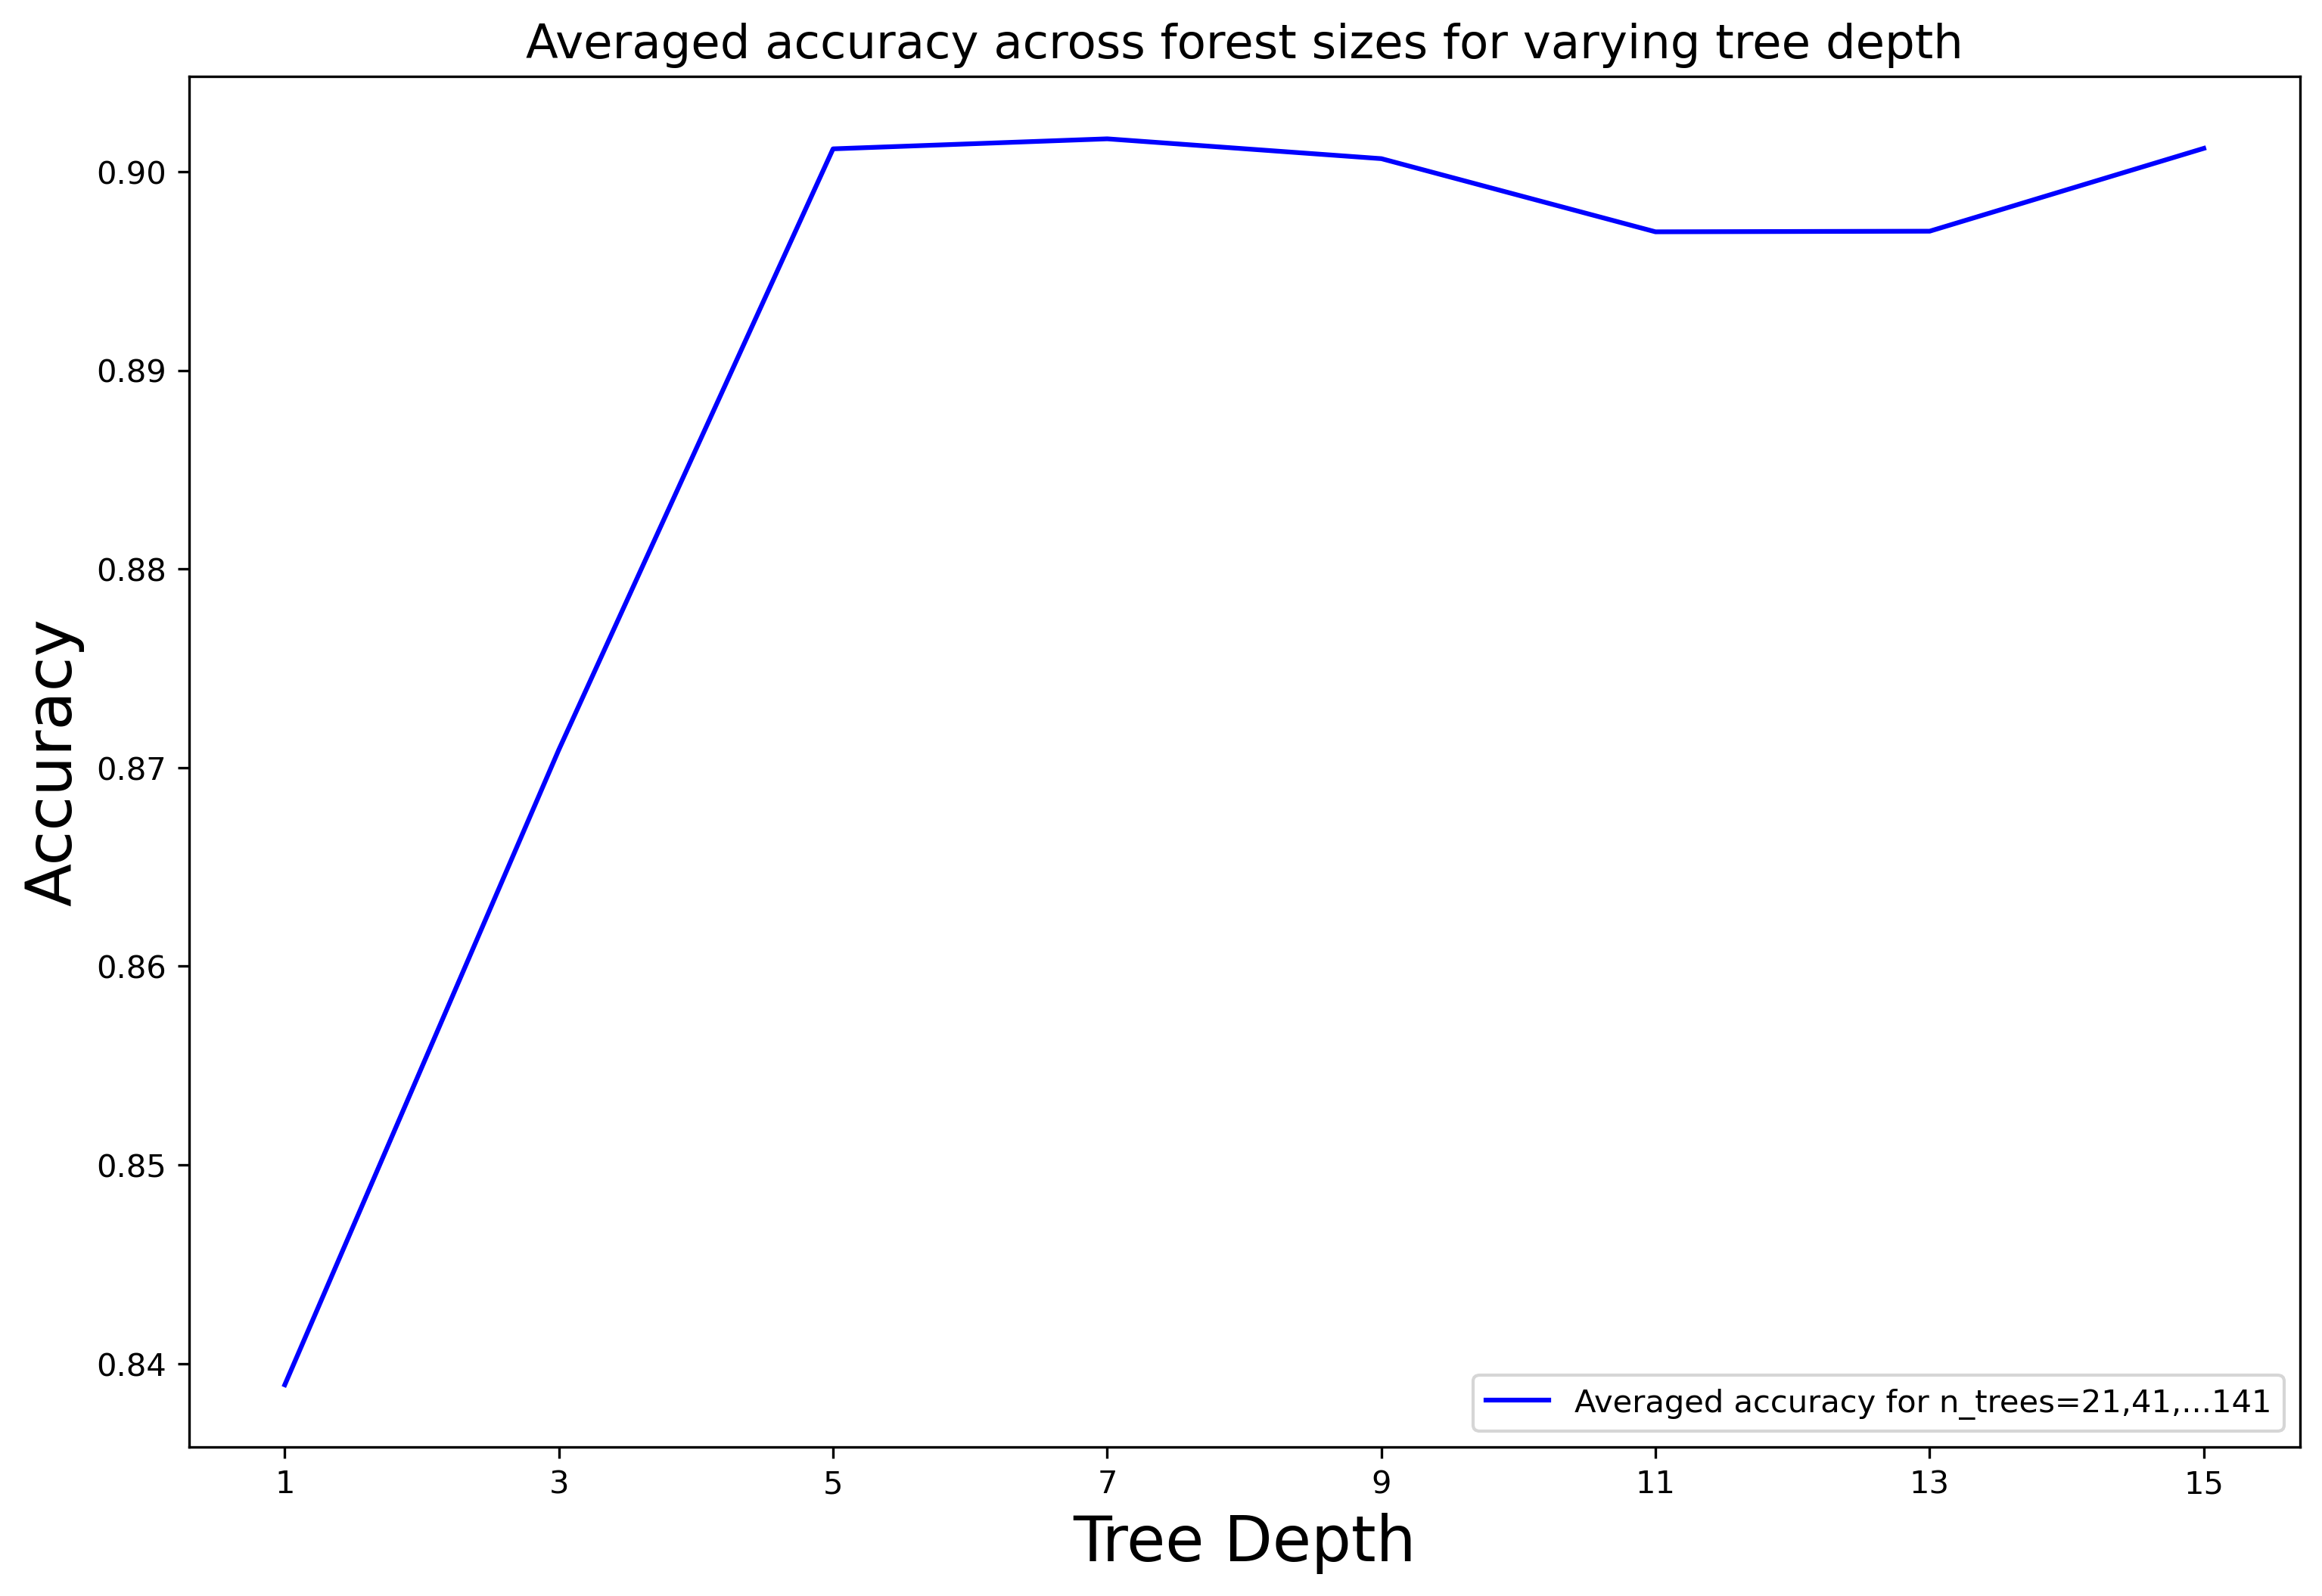

In [46]:
avg_accuracy_depth = [np.average(row[1:]) for row in accuracy_matrix]

plt.figure(figsize=(12,8), dpi=300)
plt.title(f"Averaged accuracy across forest sizes for varying tree depth", size=15)
plt.plot(depth_range, avg_accuracy_depth, 'b', label = f'Averaged accuracy for n_trees=21,41,...141')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy', size=20)
plt.xlabel('Tree Depth', size=20)
plt.xticks(depth_range)
plt.show()

In [47]:
print (max_accuracy, max_accuracy_values)

0.9121376811594204 (13, 21)


<div id="2.1.2"/>

### 2.1.2
Now that we have found our optimal hyperparameters, we will retrain our Random Forest on the full dataset, and evaluate its performance based on metrics from the confusion matrix.

In [48]:
depth_best, b_best = max_accuracy_values[0], max_accuracy_values[1]

#Train new forest with optimal hyperparameters
optimal_rf = train_rf(b_best, n_features, X_train, y_train, columns_dict, max_depth=depth_best)

In [49]:
print(rf_score(optimal_rf, X_test.to_numpy(), y_test))

0.9316239316239316


In [50]:
def confusion_matrix(forest, X_test, y_test):
    """
    Build confusion matrix on validation data X_test.
    
        Parameters:
            forest (list[dict]): A trained random forest through train_rf function.
            X_test: (pandas.Dataframe) testing sample features, of shape (N, D).
            y_test: (numpy.ndarray) testing sample outcomes of shape (N,)
            
        Returns:
            (pandas.crosstab): actual vs predicted outcome sample probabilities, of shape (2,2).
    """
    y_pred = pd.Series(predict_rf(forest, X_test), name='Predicted')
    y_test = pd.Series(y_test, name='Actual')
    return pd.crosstab(y_test, y_pred)

In [51]:
train_rf_cf = confusion_matrix(optimal_rf, X_train.to_numpy(), y_train)
train_rf_cf

Predicted,0,1
Actual,,
0,229,0
1,1,43


In [52]:
test_rf_cf = confusion_matrix(optimal_rf, X_test.to_numpy(), y_test)
test_rf_cf

Predicted,0,1
Actual,,
0,99,2
1,6,10


In [53]:
as_bool_rf = lambda y: True if y else False

def rf_metrics(rf, X_test, y_test, return_array=False):
    """
    Calculates various metrics upon which to evaluate the linear SVM
    
        Parameters:
            rf (list[dict]): a trained Random Forest with train_rf
            X_test (pandas.DataFrame): test features with column names
            y_test (numpy.ndarray): test outcomes
            return_array (bool): specifies whether to return values as an array
        Returns:
            accuracy (float): accuracy of the rf
            precision (float): precision of the rf
            recall (float): recall of the rf
            f_score (float): F-statistic of the rf
    """
    #Make RF predictions on data
    y_preds = predict_rf(rf, X_test)
    #Convert back to boolean for easy
    y_test = np.array([as_bool_rf(y) for y in y_test])
    y_preds = np.array([as_bool_rf(y) for y in y_preds])
    
    #calculate accuracy
    accuracy = np.mean(y_preds==y_test)
    
    tp = np.sum(y_test & y_preds)
    # true negatives
    tn = np.sum((~y_test) & (~y_preds))
    # false positives
    fp = np.sum((~y_test) & y_preds)
    # false negatives
    fn = np.sum(y_test & (~y_preds))
    #true pos rate
    tpr = tp / (tp + fn)
    #false pos rate
    fpr = fp / (tn + fp)
    
    #calculate metrics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = (2 * tp) / (2 * tp + fp + fn)
    
    if return_array:
        return np.array([[accuracy], [precision], [recall], [f_score]])
    
    return accuracy, precision, recall, f_score

In [54]:
acc_rf1, prec_rf1, rec_rf1, f_rf1 = rf_metrics(optimal_rf, X_test.to_numpy(), y_test)
rf_scores_df = pd.DataFrame([acc_rf1, prec_rf1, rec_rf1, f_rf1], columns=["Unweighted RF"], index=["Accuracy","Precision","Recall", "F-score"])
                                                                                                   
rf_scores_df                                                                                                   
                                                                                                   
                                                                                                   

,Unweighted RF
Accuracy,0.931624
Precision,0.833333
Recall,0.625000
F-score,0.714286


This table shows the performance metrics of the unweighted RF model, which was evaluated on `X_test`. We will explain the metrics to understand better what is going on here:

Accuracy: the proportion of correctly classified instances over the total number of instances.
Precision: the proportion of true positive predictions over the total number of positive predictions. In this case, positive means diabetic.
Recall: the proportion of true positive predictions over the total number of actual positive instances.
F-score: the harmonic mean of precision and recall.

The metrics show that our unbalanced Random Forest performs reasonably well. Accuracy is high, however accuracy alone does not convey much for an unbalanced dataset. 

In this case, we would be more interested in the <b>precision and recall</b>. Precision is reasonably good, indicating that out of the test samples we predict as diabetic, 83% are truly diabetic. Recall is not as good - this figure means that out of all the diabetics, we are only correctly identifying 62.5% of them. 

In this case, we would want a higher recall, as in the practical application of this model, it could be dangerous to incorrectly classify true diabetics as medical intervention may be necessary.

F-score is not particularly informative, however 71% is reasonably good. The higher the F-score, generally, the better the model.

We will now explore rebalancing to improve the recall. This may negatively impact the precision, as our model will end up classifying more datapoints as diabetic, however in this scenario we would prefer a high recall to a high precision.

<div id="2.1.3"/>

### 2.1.3

We now demonstrate that the dataset is unbalanced, as the proportion of non-diabetics is much higher than the proportion of diabetics, which will affect the performance, and in particular recall and F-score, of our unbalanced Random Forest classifier.

In [55]:
print("Total diabetic: " + str(np.count_nonzero(y_train==1)))
print("Total non-diabetic: " + str(np.count_nonzero(y_train==0)))

Total diabetic: 44
Total non-diabetic: 229


In [58]:
diab = np.count_nonzero(y_train==1)
non_diab = np.count_nonzero(y_train==0)

#reweighting map. Do not have to normalise as normalised in the train_rf function
weight_map = lambda w: non_diab/diab if w == 1 else 1

balanced_weights = [weight_map(y) for y in y_train]

In this balanced Random Forest, instead of bootstrap sampling from the dataset with equal probability, we select samples from the minority class more often, with 

In [59]:
accuracy_matrix_balanced = [[0 for j in range(len(B_range))] for i in range(len(depth_range))]
#print(acc)

max_accuracy_balanced = 0
max_accuracy_values_balanced = (0, 0)

for i, depth in enumerate(depth_range):
    print ("iteration " + str(i + 1) + " of 8")
    for j, b in enumerate(B_range):
        accuracy_balanced = cross_validation_score_rf(X_train, y_train, folds, b, n_features, balanced_weights, depth)
        accuracy_matrix_balanced[i][j] = round(accuracy_balanced, 5)
        if accuracy_balanced > max_accuracy_balanced:
            max_accuracy_balanced = accuracy_balanced
            max_accuracy_values_balanced = (depth, b)
            
print (max_accuracy_balanced, max_accuracy_values_balanced)


iteration 1 of 8
iteration 2 of 8
iteration 3 of 8
iteration 4 of 8
iteration 5 of 8
iteration 6 of 8
iteration 7 of 8
iteration 8 of 8
0.9085677749360614 (5, 141)


In [60]:
depth_best_balanced, b_best_balanced = max_accuracy_values_balanced[0], max_accuracy_values_balanced[1]
optimal_rf_balanced = train_rf(b_best_balanced, n_features, X_train, y_train, columns_dict, balanced_weights, max_depth=depth_best_balanced,)

We display the confusion matrix of the balanced Random Forest

In [61]:
confusion_matrix(optimal_rf_balanced, X_train.to_numpy(), y_train)

Predicted,0,1
Actual,,
0,215,14
1,4,40


In [62]:
confusion_matrix(optimal_rf_balanced, X_test.to_numpy(), y_test)

Predicted,0,1
Actual,,
0,94,7
1,4,12


As we can see from the confusion matrix, the totaly number of datapoints that our model classifies as diabetic is higher on both the training and test data, due to greater penalisation of missclassification of diabetics in the loss function.

We also have fewer false negatives, which is the goal of rebalancing.

We will now compare our balanced model to the previous model based on ROC and Precision-Recall curves.

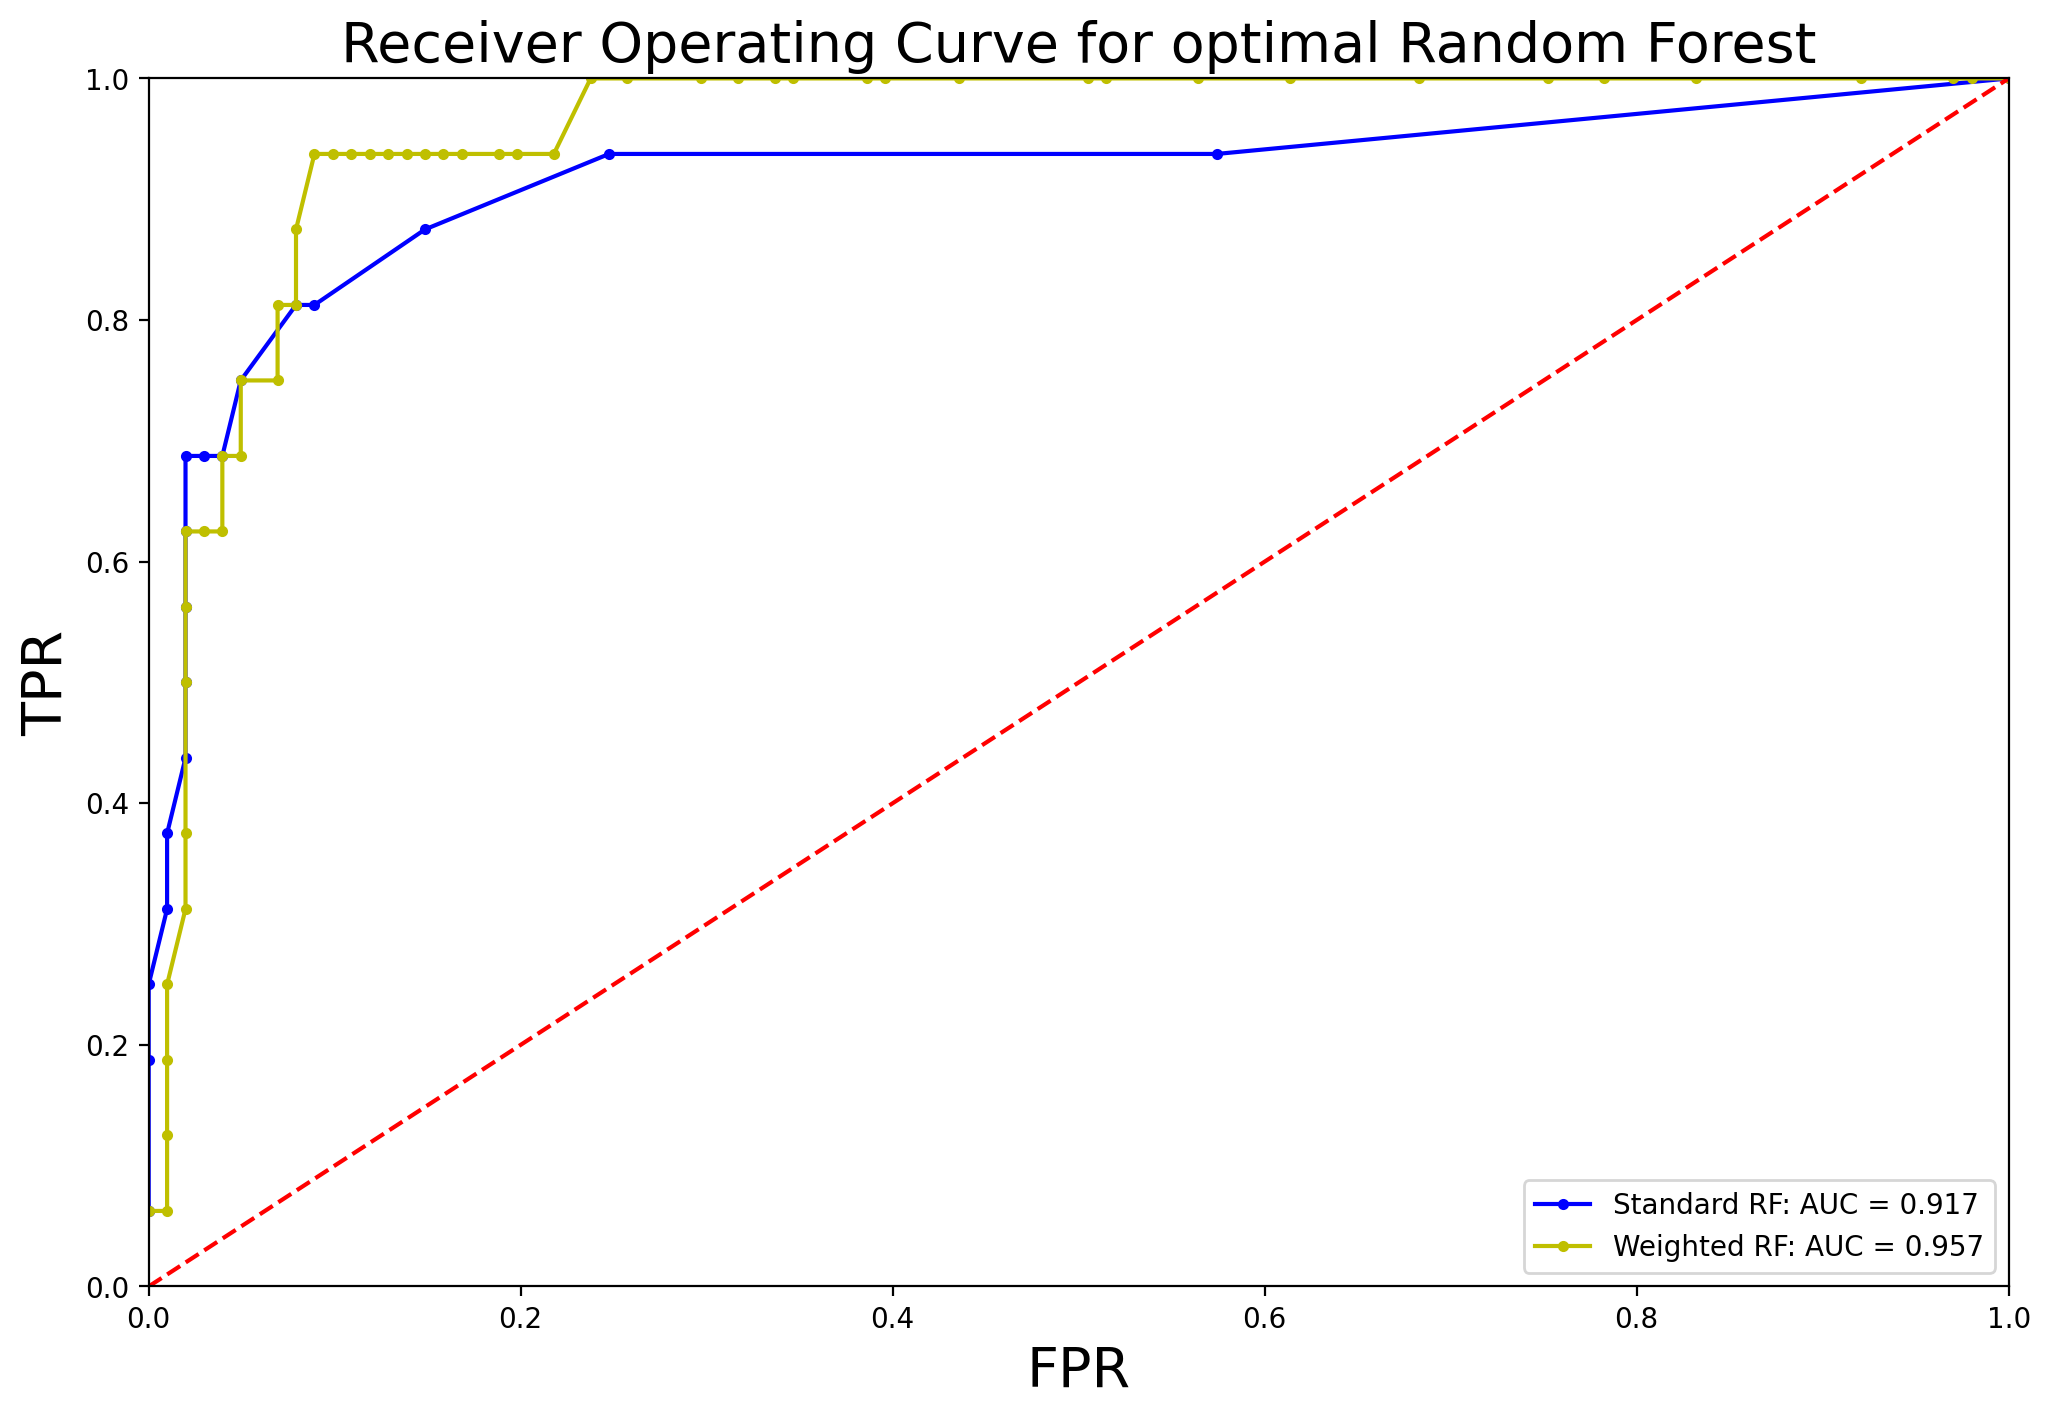

In [68]:
y_test_prob = predict_rf(optimal_rf, X_test.to_numpy(), return_probability=True)
y_test_prob_balanced = predict_rf(optimal_rf_balanced, X_test.to_numpy(), return_probability=True)

def roc_curve(y_test, y_prob):
    """
    Returns ROC curve & metrics based on true y and estimated probability
    
        Arguments:
            y_test (numpy.ndarray): ground truth labels with size (n, )
            y_prob (numpy.ndarray): probabilities produced by RF model with size (n, )
    
        Returns:
            auc (float): area under the curve (AUC).
            tpr_l (list[float]): a list of true positive rate (TPR) values for each scanned threshold.
            fpr_l (list[float]): a list of false positive rate (FPR) values for each scanned threshold.
            thresholds (list[float]): the scanned thresholds sorted descendingly.
            precisions (list[float]): a list of precisions for each scanned threshold.
            recalls (list[float]): a list of recalls for each scanned threshold.
    """
    # List of distinct values in y_log, sorted descendingly.
    thresholds = reversed(sorted(set(y_prob)))
    tpr_l, fpr_l, precisions, recalls = [], [], [], []

    for threshold in thresholds:
        
        #Predict y based on threshold
        y_pred = (y_prob >= threshold)

        # true positives
        tp = np.sum(y_test & y_pred)
        # true negatives
        tn = np.sum((~y_test) & (~y_pred))
        # false positives
        fp = np.sum((~y_test) & y_pred)
        # false negatives
        fn = np.sum(y_test & (~y_pred))

        tpr = tp / (tp + fn)
        fpr = fp / (tn + fp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        tpr_l.append(tpr)
        fpr_l.append(fpr)
        precisions.append(precision)
        recalls.append(recall)

    # Compute AUC using Trapezoidal rule
    auc = np.trapz(tpr_l, fpr_l)
    aucpr = np.trapz(precisions, recalls)
    return auc, tpr_l, fpr_l, thresholds, aucpr, precisions, recalls

auc, tpr, fpr, th, aucpr, precisions, recalls = roc_curve(y_test, y_test_prob)
auc1, tpr1, fpr1, th1, aucpr1, precisions1, recalls1 = roc_curve(y_test, y_test_prob_balanced)

plt.figure(figsize=(12,8), dpi=200)
plt.title(f"Receiver Operating Curve for optimal Random Forest", size=20)
plt.plot(fpr, tpr, 'b', marker='.',label = f'Standard RF: AUC = {auc:0.3f}')
plt.plot(fpr1, tpr1, 'y', marker='.',label = f'Weighted RF: AUC = {auc1:0.3f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR', size=20)
plt.xlabel('FPR', size=20)
plt.show()


We see a significantly better AUC on the weighted RF, indicating that our weighted model more accurately predicts the diabetics. The AUC of the weighted model is much higher. If we were to set our threshold so that our false positive rate was just 0.3, then we could already correctly classify all of the diabetics.

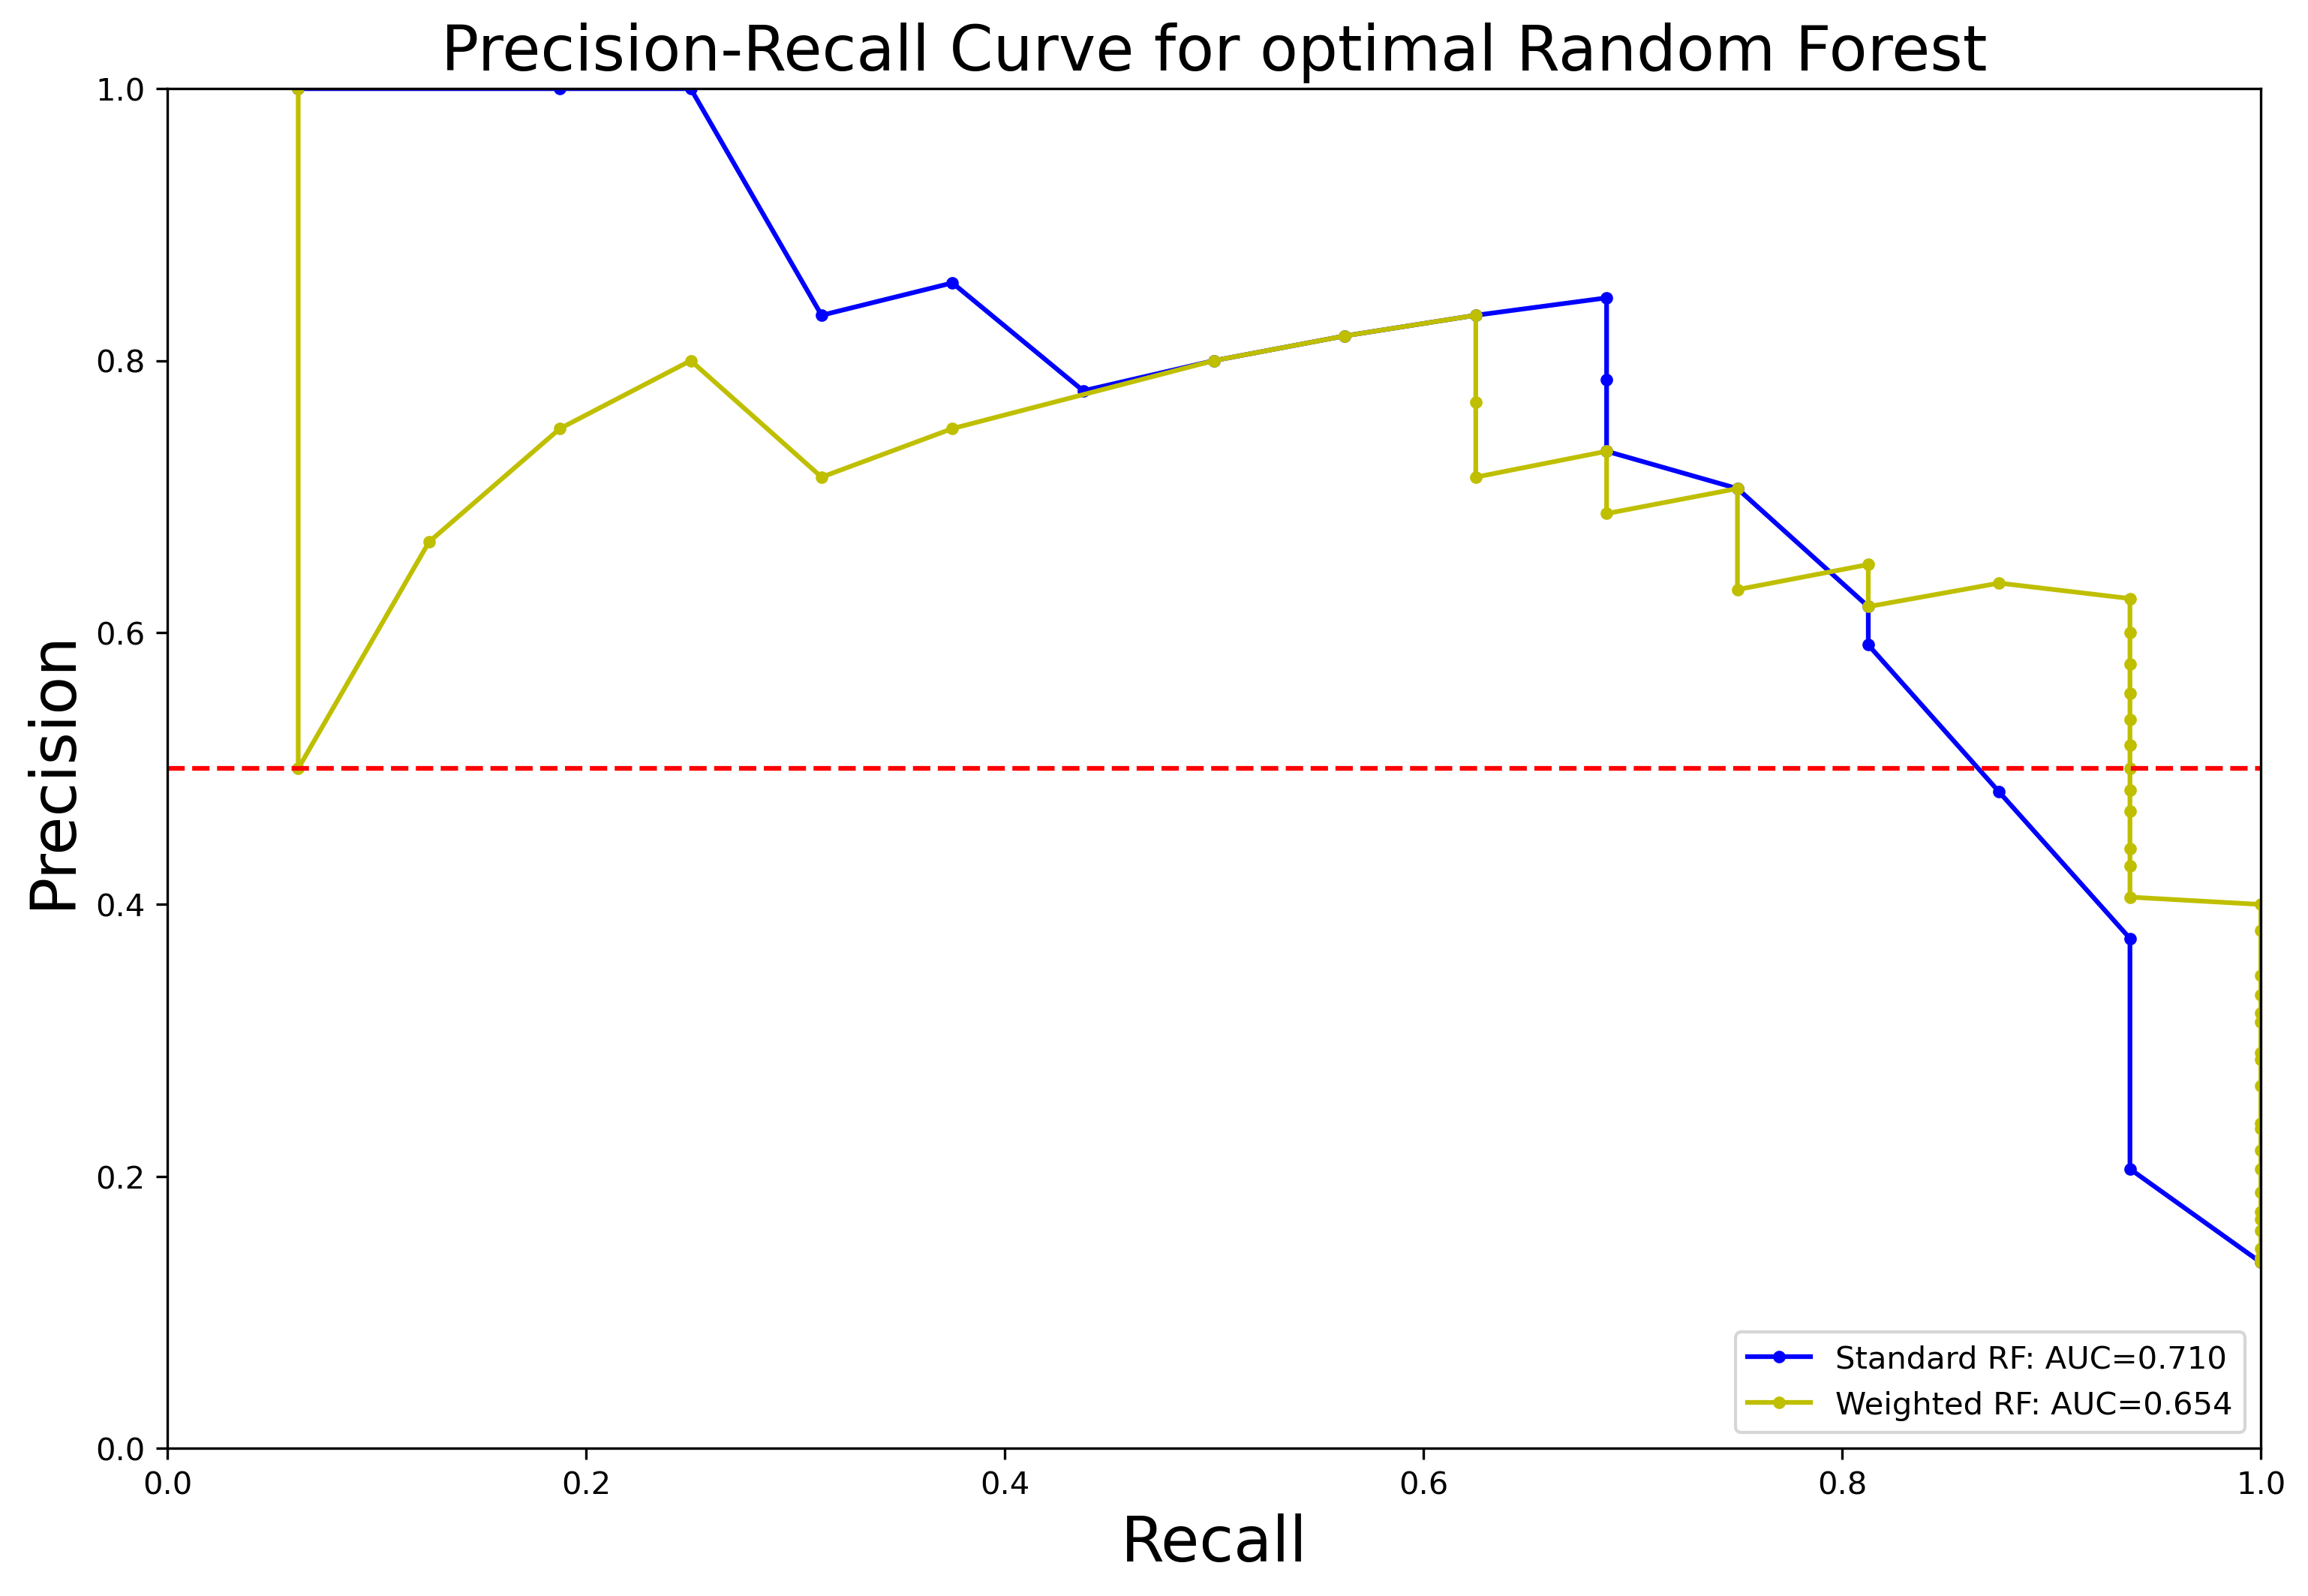

In [67]:
plt.figure(figsize=(12,8), dpi=300)
plt.title(f"Precision-Recall Curve for optimal Random Forest", size=20)
plt.plot(recalls, precisions, 'b', marker='.',label = f'Standard RF: AUC={aucpr:.3f}')
plt.plot(recalls1, precisions1, 'y', marker='.',label = f'Weighted RF: AUC={aucpr1:.3f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision', size=20)
plt.xlabel('Recall', size=20)
plt.show()

This time, our weighted RF performs worse in terms of AUC. However, if we were to set our threshold to have a higher recall, around 0.9, then our weighted RF would actually exhibit higher precision than the standard RF.

In this case, we want a higher recall in order to correctly classify true diabetics.

We present all metics for `threshold`=0.5 in a dataframe below:

In [66]:
acc_rf2, prec_rf2, rec_rf2, f_rf2 = rf_metrics(optimal_rf_balanced, X_test.to_numpy(), y_test)
rf_scores_df = pd.DataFrame([[acc_rf1, prec_rf1, rec_rf1, f_rf1],[acc_rf2, prec_rf2, rec_rf2, f_rf2]], columns=["Accuracy","Precision","Recall", "F-score"], index=["Unweighted RF", "Weighted RF"])
                                                                                                   
rf_scores_df

,Accuracy,Precision,Recall,F-score
Unweighted RF,0.931624,0.833333,0.625,0.714286
Weighted RF,0.905983,0.631579,0.750,0.685714


As expected, the weighted RF performs better on Recall. However, the unweighed RF defeats the weighted one in all other metrics.

When it comes to selecting a method, it really depends on what you want your model to achieve. In diagnostic models like this, it is generally better to have a higher recall, as it is dangerous to missclassify sufferes of diabetes.

We will turn to another method, SVM, to explore its performance on the dataset.

<div id="2.2"/>

## 2.2	Support Vector Machine (SVM) (30 marks)
<div id="2.2.1"/>

### 2.2.1

We will now train a soft-margin linear SVM classifier. We aim to minimise the loss function

$$
\mathcal L (\textbf{w}, b) = \frac{1}{2} \| \textbf{w} \|^2 + \lambda \sum_{i=1}^n \max \bigg( 0, 1-y_i (x^{(i)} \cdot \textbf{w}  + b) \bigg) \, .
$$
where $\textbf{w}$ is the vector of weights, $\lambda$ the hardness hyparameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s.

We will carry out 4-fold cross validation in order to determine the optimal hardness hyparameter $\lambda$ and compare the performance of the SVM to that of the Random Forest trained previously.

If the data is linearly separable - that is, if we can find a hyperplane in the feature space that accurately separates the test samples into diabetic and non-diabetic, then we will expect our linear SVM to perform well in terms of accuracy and precision compared to our previously trained Random Forest. Particularly, as $\lambda$ grows large, an SVM trained on a linearly separable dataset will see a higher accuracy as it will find the hyperplane that perfectly separates the data into distinct classes.

In [69]:
#Standardise the data to ensure features vary over the same range
X_train_SVM = standardise(X_train.to_numpy(), X_train.to_numpy())
X_test_SVM = standardise(X_test.to_numpy(), X_train.to_numpy()) #standardise based on training data

#Convert outcome labels into {-1,1} for SVM training and testing
class_map_SVM = lambda c: 1 if c == 1 else -1

N, D = X_train_SVM.shape
#Augment the training matrix to include intercept term in the linear SVM
X_train_SVM_aug = np.hstack([X_train_SVM, np.ones((N,1))])
y_train_SVM = np.array([class_map_SVM(c) for c in y_train])

n, d = X_test_SVM.shape
#Augment the test matrix to predict with the intercept term
X_test_SVM_aug = np.hstack([X_test_SVM, np.ones((n,1))])
y_test_SVM = np.array([class_map_SVM(c) for c in y_test])


assert X_train_SVM_aug.shape == (N, D + 1)
assert y_train_SVM.shape == (N,)

assert X_test_SVM_aug.shape == (n, d + 1)
assert y_test_SVM.shape == (n,)

assert sorted(list(set(y_train_SVM))) == [-1,1]

In [70]:
def compute_cost(w, X, y, regul_strength=1e5):
    """Evaluate the cost function of linear SVM with hyperplane normal vector w"""
    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    #Calculate the hinge cost
    hinge = regul_strength * distances.mean()

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge

Stochastic gradient descent samples a batch of $k$ predictor and outcome samples, and updates the parameters $\textbf{w}$ and $b$ by computing the gradient

$$
\nabla_{(\textbf{w}, b)}\mathcal{L}(\textbf{w}^{(i)}, b^{(i)} \mid \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where $\textbf{w}^{(i)}, b^{(i)}$ are our parameters after the $i$th iteration, $\mathcal{X}^{(i)}$ is our $i$th batch of training features and $\mathcal{Y}^{(i)}$ is our $i$th batch of respective outcomes.

The gradient of the linear cost function can be written

$$\begin{align}
\nabla_\textbf{w} \mathcal{L}(\textbf{w}, b) &= \textbf{w} - \lambda \sum_{i=1}^k a_i y_i x^{(i)}\\
\nabla_b \mathcal{L}(\textbf{w}, b) &= - \lambda \sum_{i=1}^k a_i y_i
\end{align}$$

where $$a_i=\begin{cases}
        1 & \text{if } 1-y_i (x^{(i)} \cdot \textbf{ w}  + b) >0\\
        0 & \text{otherwise}
    \end{cases}$$
    
If we let $\textbf{w}_{aug}=\begin{matrix} b\\\textbf{w} \end{matrix}$ then our gradient becomes
$$
\nabla_{\textbf{w}_{aug}} \mathcal{L}(\textbf{w}_{aug}) = \textbf{w}_{aug} - \lambda \sum_{i=1}^k a_i y_i x^{(i)}
$$
and so we can include the intercept term in the vector of weights for this linear SVM.

In [71]:
# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e6):
    """
    Calculate the grad of the cost function with respect to w
    
        Parameters:
            w (numpy.ndarray): the hyperplane normal vector
            X_batch (numpy.ndarray): a subset of the training set predictors (augmented)
            y_batch (numpy.ndarray): a subset of the training set labels
            regul_strength (float): the hardness of the cost function
        
        Returns:
            dw (numpy.ndarray): the derivatives with respect to the intercept and each wi
    """
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w # derivative of first term
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw / len(y_batch)  # average

We make the following parameter update at each iteration:

$$
\textbf{w}_{aug}^{(i+1)} = \textbf{w}^{(i)}_{aug} - \eta \nabla_{\textbf{w}_{aug}}\mathcal{L}(\textbf{w}^{(i)}_{aug} \mid \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where $\eta>0$ is the learning rate and $\mathcal{X}^{(i)}, \mathcal{Y}^{(i)}$ are the features and outcomes of the $i$th batch of the training set with which we calculate the gradient.

We finish the iterations when $|\frac{\Delta \mathcal{L}}{\mathcal{L}}|<\epsilon$ or when `iteration` = `max_iterations` to find the optimal hyperplane normal $\textbf{w}$

In [72]:
def sgd(X, y, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e6, print_outcome=False):
    """
    Implement a stochastic gradient descent to minimise th SVM cost function
    
        Parameters:
            X (numpy.ndarray): the training set predictors
            y (numpy.ndarray): the training set labels
            max_iterations (int): the maximum number of iterations of the SGD
            stop_criterion (float): the convergence criterion on the cost function
            learning_rate (float): the learning rate of SGD algorithm
            regul_strength (float): the hardness λ
            print_outcome (bool): indicates whether to update on progress
            
        Returns:
            weights (numpy.ndarray): the minmised hyperplane normal
    """
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))

    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
        
        for xi, yi in zip(X, y):
            descent = calculate_cost_gradient(weights, xi, yi, regul_strength) ## <-- SOLUTION
            weights = weights - (learning_rate * descent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength)  ## <-- SOLUTION
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

In [73]:
lam = 10
w = sgd(X_train_SVM_aug, y_train_SVM.astype(float), max_iterations=2000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=lam, print_outcome=True)
print("Training finished.")

Iteration is: 1, Cost is: 9.763596218890209
Iteration is: 2, Cost is: 9.528509634861086
Iteration is: 4, Cost is: 9.062147965586695
Iteration is: 8, Cost is: 8.144596641416177
Iteration is: 16, Cost is: 6.382386942081183
Iteration is: 32, Cost is: 4.271469411435009
Iteration is: 64, Cost is: 2.861828259668304
Iteration is: 128, Cost is: 2.694280612531964
Iteration is: 256, Cost is: 2.683434183774884
Iteration is: 512, Cost is: 2.682237338220678
Training finished.


In [74]:
def svm_score(w1, X1, y1):
    """Returns the accuracy of linear SVM"""
    y_preds = np.sign(X1 @ w1)
    return np.mean(y_preds==y1) 

print("Accuracy on training set: {}".format(svm_score(w, X_train_SVM_aug, y_train_SVM.astype(float))))
print("Accuracy on test set: {}".format(svm_score(w, X_test_SVM_aug, y_test_SVM.astype(float))))

Accuracy on training set: 0.9267399267399268
Accuracy on test set: 0.9230769230769231


In [75]:
def cross_validation_score_SVM(X_train, y_train, folds, lam):
    """
    Returns t-fold CV accuracy of linear SVM trained with varying λ
    
        Parameters:
            X_train: (numpy.ndarray) training features, of shape (N, D). Each X[i] is a training sample.
            y_train: (numpy.ndarray) vector of training labels, of shape (N,)
            folds (numpy.ndarray): indices of folds to validate
            lam (float): the hardness of the margin
            
        Returns:
            (float) the t-fold CV accuracy with given λ
    """
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        X_train_i = X_train[train_indexes]
        y_train_i = y_train[train_indexes]
    
    
        X_val_i = X_train[val_indexes]
        y_val_i = y_train[val_indexes]
        
        #Train linear SVM on training set
        SVM = sgd(X_train_i, y_train_i.astype(float), max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=lam, print_outcome=False)
        #Evaluate trained SVM on testing set
        score_i = svm_score(SVM, X_val_i, y_val_i.astype(float))
        scores.append(score_i)

    return np.mean(scores)

#cross_validation_score_SVM(X_train_SVM_aug, y_train_SVM.astype(float), folds, 2)

def optimise_SVM(X_train, y_train, t_folds=4, lam_range=np.linspace(0.5,10,20)):
    """
    Optimises the linear SVM in terms of t-fold CV accuracy
    
        Parameters:
            X_train (numpy.ndarray): training features, of shape (N, D). Each X[i] is a training sample.
            y_train (numpy.ndarray): vector of training labels, of shape (N,)
            t_folds (int): number of folds to use
            lam_range (numpy.linspace): range of λs to consider
        
        Returns:
            (float): the optimal λ
            lam_scores (numpy.ndarray): the t-fold CV accuracy for each λ
    """
    folds_indexes = np.array_split(np.arange(len(y_train)), t_folds)
    lam_scores = np.zeros((len(lam_range),))
    
    for i, lam in enumerate(lam_range):
        lam_scores[i] = cross_validation_score_SVM(X_train_SVM_aug, y_train_SVM.astype(float), folds_indexes, lam)
        print(f'CV_acc@lam={lam:.3f}: {lam_scores[i]:.3f}')

    best_lam_index = np.argmax(lam_scores)
    return lam_range[best_lam_index], lam_scores

best_lam_svm, lam_score_svm = optimise_SVM(X_train_SVM_aug, y_train_SVM.astype(float), 4, np.logspace(1, 6, 40))

CV_acc@lam=10.000: 0.912
CV_acc@lam=13.434: 0.912
CV_acc@lam=18.047: 0.919
CV_acc@lam=24.245: 0.927
CV_acc@lam=32.570: 0.927
CV_acc@lam=43.755: 0.923
CV_acc@lam=58.780: 0.930
CV_acc@lam=78.965: 0.923
CV_acc@lam=106.082: 0.923
CV_acc@lam=142.510: 0.923
CV_acc@lam=191.448: 0.919
CV_acc@lam=257.191: 0.923
CV_acc@lam=345.511: 0.919
CV_acc@lam=464.159: 0.919
CV_acc@lam=623.551: 0.927
CV_acc@lam=837.678: 0.923
CV_acc@lam=1125.336: 0.923
CV_acc@lam=1511.775: 0.919
CV_acc@lam=2030.918: 0.923
CV_acc@lam=2728.333: 0.916
CV_acc@lam=3665.241: 0.916
CV_acc@lam=4923.883: 0.916
CV_acc@lam=6614.741: 0.912
CV_acc@lam=8886.238: 0.905
CV_acc@lam=11937.766: 0.908
CV_acc@lam=16037.187: 0.901
CV_acc@lam=21544.347: 0.897
CV_acc@lam=28942.661: 0.864
CV_acc@lam=38881.552: 0.879
CV_acc@lam=52233.451: 0.872
CV_acc@lam=70170.383: 0.901
CV_acc@lam=94266.846: 0.898
CV_acc@lam=126638.017: 0.842
CV_acc@lam=170125.428: 0.828
CV_acc@lam=228546.386: 0.835
CV_acc@lam=307029.063: 0.843
CV_acc@lam=412462.638: 0.887
CV_acc@

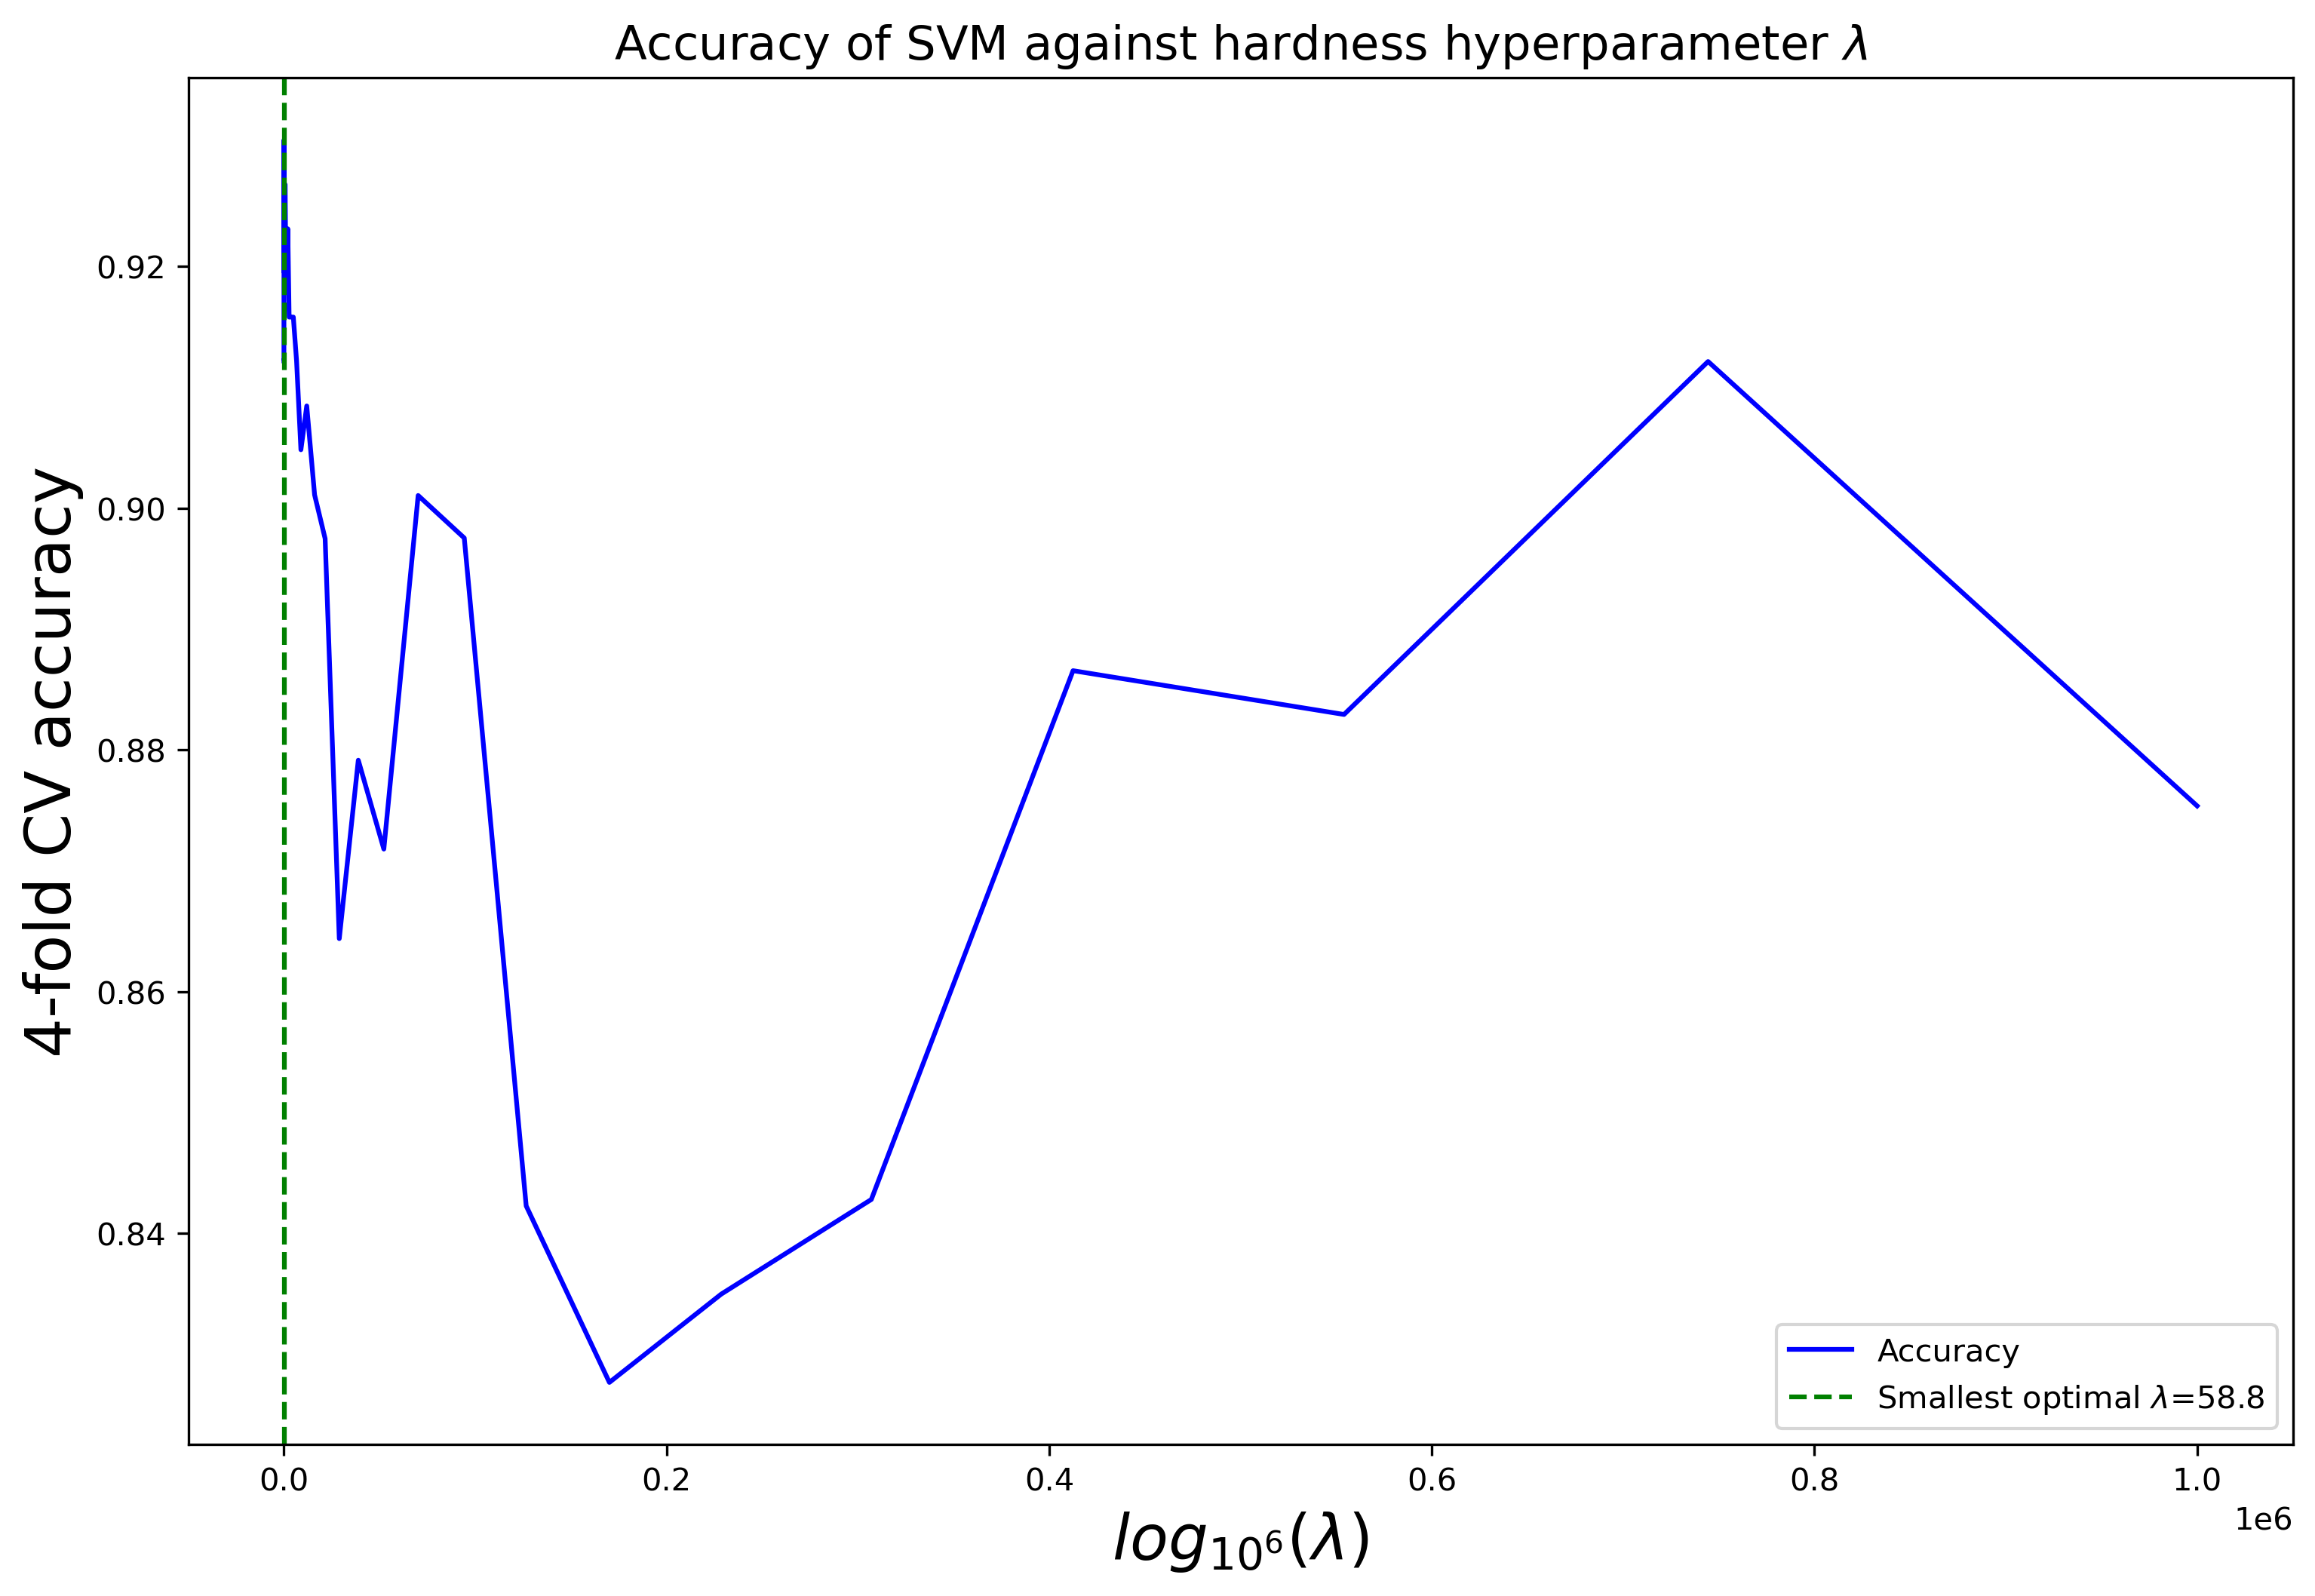

In [80]:
plt.figure(figsize=(12,8), dpi=300)
plt.title(f"Accuracy of SVM against hardness hyperparameter $\lambda$", size=15)
plt.plot(np.logspace(1, 6, 40), lam_score_svm, 'b', label = f'Accuracy')
plt.axvline(best_lam_svm, color='g', linestyle='--', label=f"Smallest optimal $\lambda$={best_lam_svm:.1f}")
plt.legend(loc = 'lower right')
plt.ylabel('4-fold CV accuracy', size=20)
plt.xlabel('$log_{10^6}(\lambda)$', size=20)
#plt.xticks(lam_range)
plt.show()

Low hardness means $\lambda$ is close to zero. In this case, the algorithm places more emphasis on maximizing the margin, even if it means misclassifying some training examples. While this can help to reduce overfitting and improve the generalization performance of the model, it can also lead to high bias, which means that the model may underfit the data and have low accuracy on the training set.

On the other hand, when $\lambda$ is very large, the algorithm places more emphasis on minimizing the classification error, even if it means reducing the margin between the support vectors. While this can help to improve the accuracy of the model on the training set, it can also lead to high variance, which means that the model may overfit the data and have low accuracy on new, unseen data.

In this case, we see an optimal hardness of $\lambda=58.8$, with an accuracy of 93%.

<div id="2.2.2"/>

### 2.2.2

We assess the impact of varying $\lambda$ on the angle between the inferred hyperplanes of the SVM. To do this, we make a cosine similarity matrix on the basis that

$$
\cos{\theta_{i,j}}=\hat{w}_i \cdot \hat{w}_j
$$

where the $\hat{w}_i$s are the normalised normal vectors of the $i$th hyperplane $w_i$ and $\theta_{i,j}$ is the angle between the $i$th and $j$th hyperplane.

We will begin with a small range of $\lambda$, then expand with a logarithmic range to explore all trends.

In [81]:
def get_angle_between_svm_hyperplanes(X_train, y_train, lam_range):
    """
    Trains an SVM for specified lambda range and calculates the cosine of the anle between each generated hyperplane
    
        Parameters:
            X_train (numpy.ndarray): training features, of shape (N, D). Each X[i] is a training sample.
            y_train (numpy.ndarray): vector of training labels, of shape (N,)
            lam_range (numpy.linspace): range of λs to consider
        
        Returns:
            (numpy.ndarray): symmetric matrix of cosines between hyperplanes
    """
    n_lam = len(lam_range)
    n, d = X_train.shape
    ws = np.zeros((n_lam, d))
    for i, lam in enumerate(lam_range):
        ws[i, :] = np.array(sgd(X_train, y_train.astype(float), max_iterations=2000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=lam, print_outcome=False))
        ws[i, :] = ws[i, :] / np.linalg.norm(ws[i, :])
    return ws @ ws.T

angle_matrix = get_angle_between_svm_hyperplanes(X_train_SVM_aug, y_train_SVM, np.linspace(0.5,10,20))

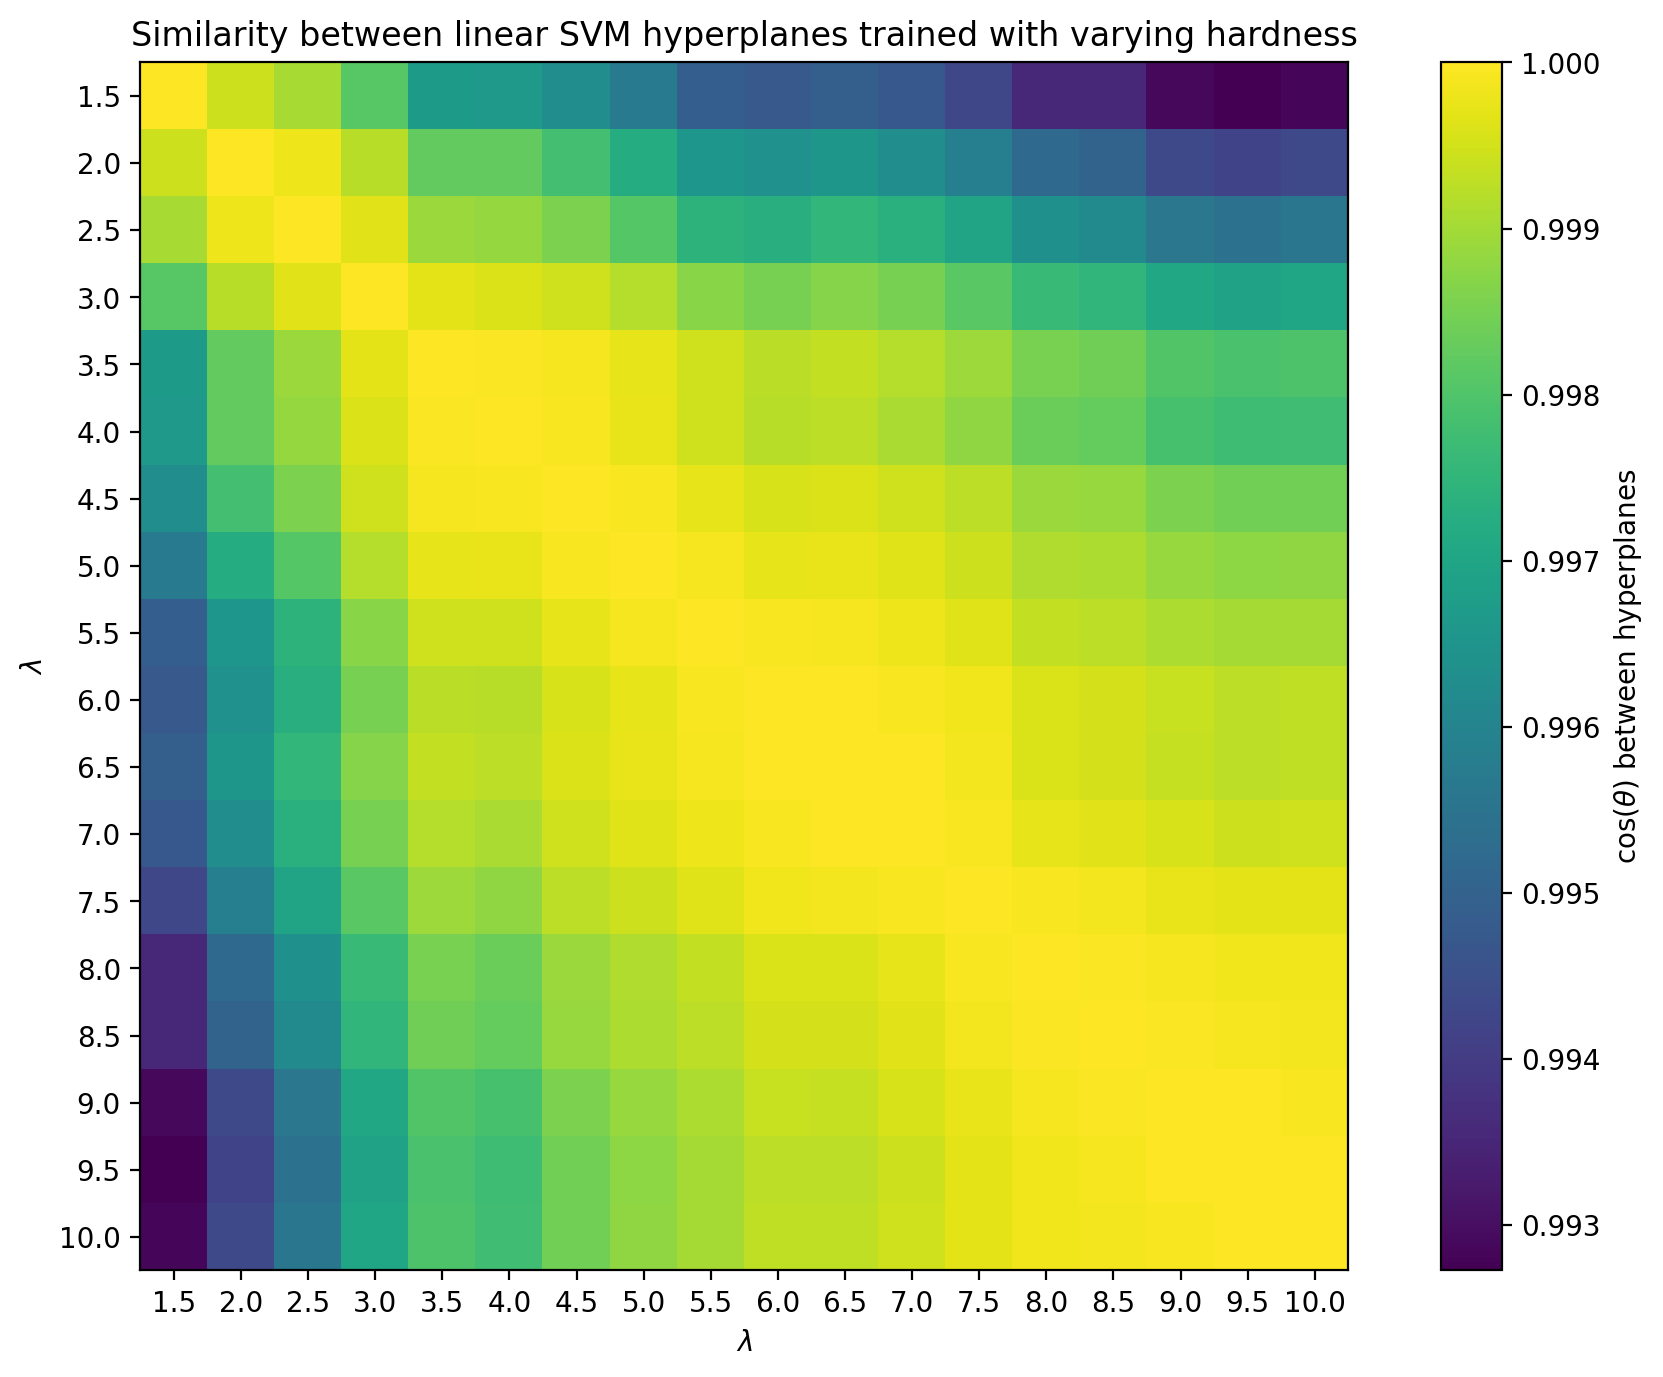

In [82]:
fig, ax = plt.subplots(figsize=(12,8), dpi=200)

plt.title("Similarity between linear SVM hyperplanes trained with varying hardness", size=12)
plt.imshow(angle_matrix[2:,2:])
plt.xlabel('$\lambda$')
plt.ylabel('$\lambda$')
plt.colorbar(label=r"cos($\theta$) between hyperplanes")

# set ticks followed by setting labels

ax.set_xticks(range(18))
ax.set_xticklabels(np.linspace(1.5,10,18).round(2))

ax.set_yticks(range(18))
ax.set_yticklabels(np.linspace(1.5,10,18).round(2))

plt.show()

The matrix is unsurprisingly symmetric with ones on the diagonal and rather pretty. We see generally more cosine similarity between closer values of $\lambda$, as is to be expected - the $\lambda$ penalises violations of the hyperplane, and so the closer the $\lambda$, the more similar the optimal hyperplane after SGD is carried out.

We will now examine a larger range of $\lambda$ to identify any interesting properties.

In [83]:
angle_matrix1 = get_angle_between_svm_hyperplanes(X_train_SVM_aug, y_train_SVM, np.logspace(1, 6, 40))

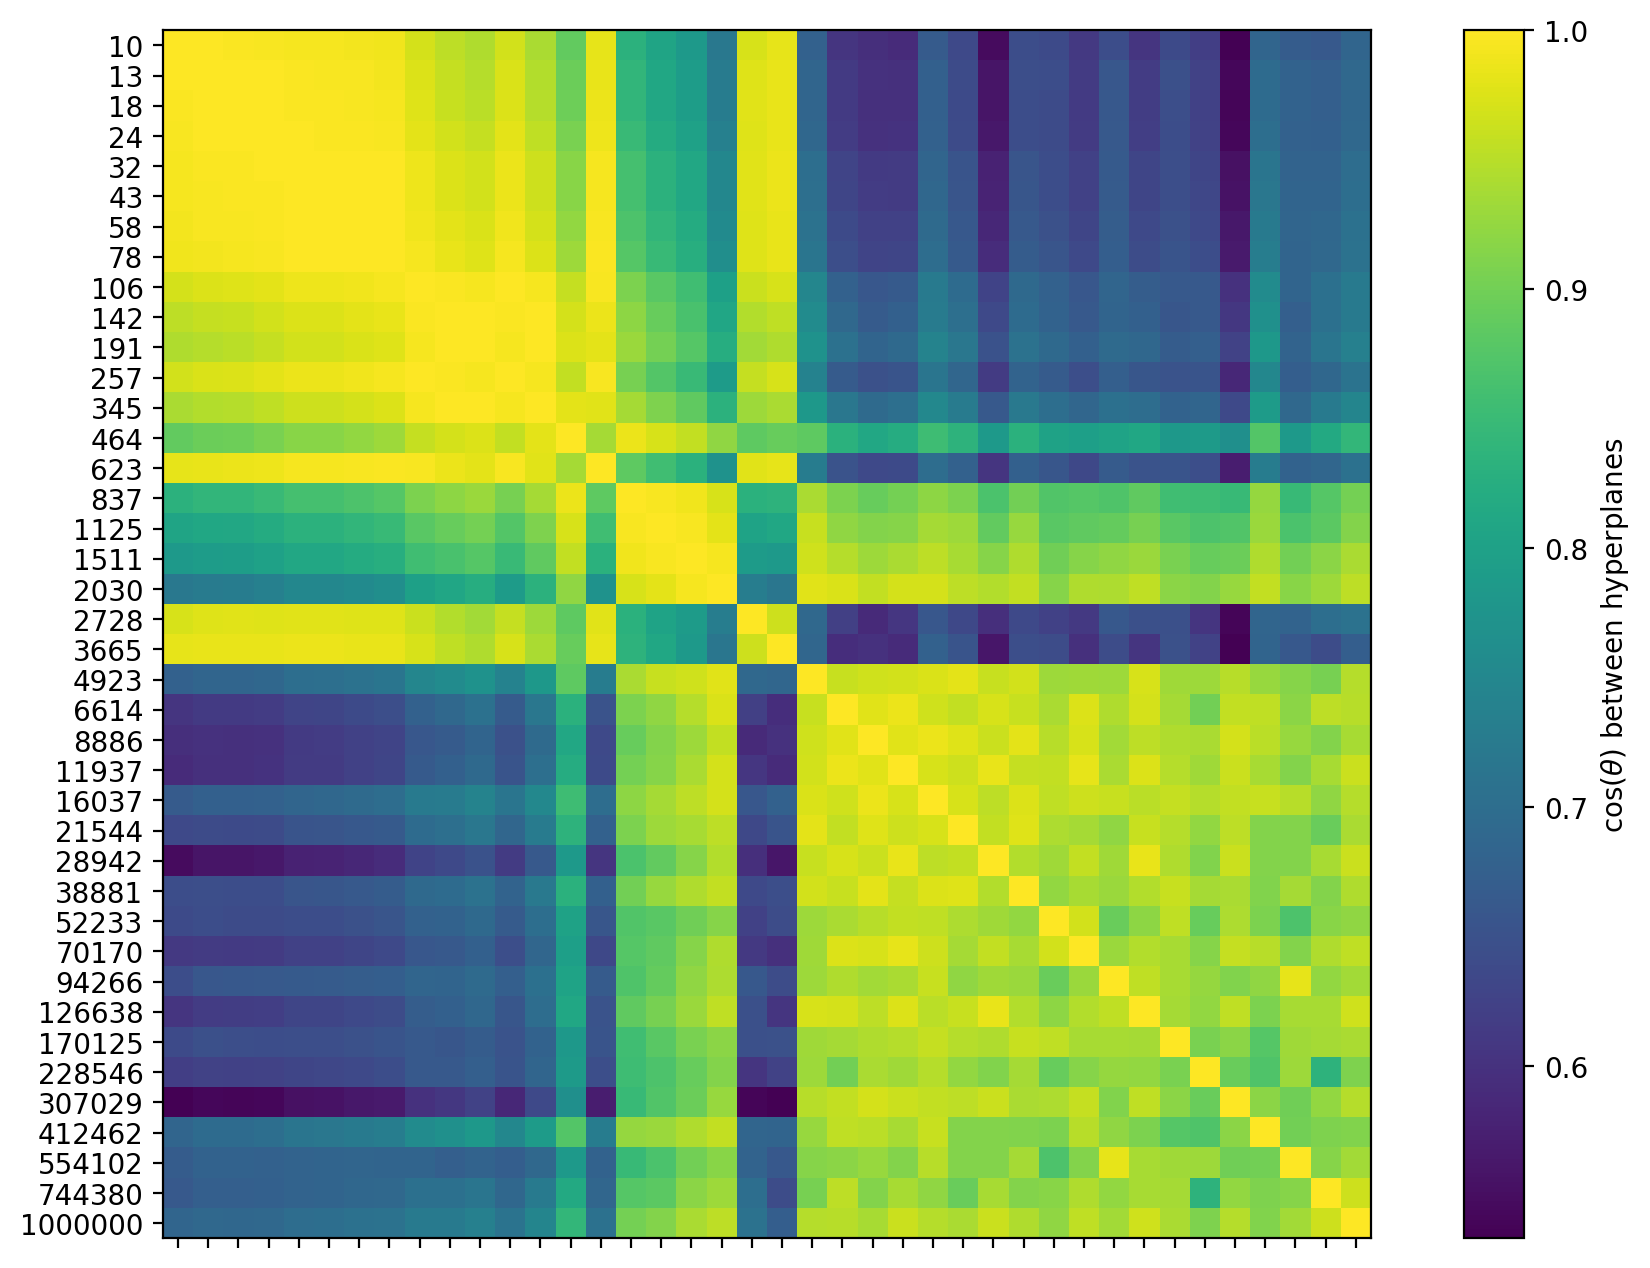

In [84]:
fig, ax = plt.subplots(figsize=(12,8), dpi=200)
plt.imshow(angle_matrix1)
plt.colorbar(label=r"cos($\theta$) between hyperplanes")

# set ticks followed by setting labels

ax.set_xticks(range(40))
ax.set_xticklabels([] * 40)

ax.set_yticks(range(40))
ax.set_yticklabels([int(i) for i in np.logspace(1, 6, 40)])
#ax.set_yticklabels(np.logspace(1, 6, 40))

plt.show()

The results are similar to above, however for $\lambda=623$ and $\lambda=2728$ the hyperplane has a striking similarity to the smaller values of $\lambda$. This is likely due to random chance from the randomness of the folds used in $t$-fold cross-validation.



<div id="2.2.3"/>

### 2.2.3

We will now evaluate our model using metrics from the confusion matrix.

In [85]:
w_best = sgd(X_train_SVM_aug, y_train_SVM.astype(float), max_iterations=2000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=best_lam_svm, print_outcome=False)

as_bool = lambda y: True if y == 1 else False

def confusion_matrix_SVM(w, X_test, y_test):
    """
    Build confusion matrix on validation data X_test for SVM.
    
        Parameters:
            fw (numpy.ndarray) normal hyperplane
            X_test: (pandas.Dataframe) testing sample features, of shape (N, D).
            y_test: (numpy.ndarray) testing sample outcomes of shape (N,)
            
        Returns:
            (pandas.crosstab): actual vs predicted outcome sample probabilities, of shape (2,2).
    """
    y_pred = pd.Series(np.sign(X_test @ w), name='Predicted')
    y_test = pd.Series(y_test, name='Actual')
    return pd.crosstab(y_test, y_pred)

def svm_metrics(w, X_test, y_test):
    """
    Calculates various metrics upon which to evaluate the linear SVM
    
        Parameters:
            w (numpy.ndarray): normal hyperplane vector
            X_test (numpy.ndarray): test features
            y_test (numpy.ndarray): test outcomes
            
        Returns:
            accuracy (float): accuracy of the SVM
            precision (float): precision of the SVM
            recall (float): recall of the SVM
            f_score (float): F-statistic of the SVM
    """
    #Make SVM predictions on data
    y_preds = np.sign(X_test @ w)
    #Convert back to boolean for easy
    y_test = np.array([as_bool(y) for y in y_test])
    y_preds = np.array([as_bool(y) for y in y_preds])
    
    #calculate accuracy
    accuracy = np.mean(y_preds==y_test)
    
    tp = np.sum(y_test & y_preds)
    # true negatives
    tn = np.sum((~y_test) & (~y_preds))
    # false positives
    fp = np.sum((~y_test) & y_preds)
    # false negatives
    fn = np.sum(y_test & (~y_preds))
    #true pos rate
    tpr = tp / (tp + fn)
    #false pos rate
    fpr = fp / (tn + fp)
    
    #calculate metrics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = (2 * tp) / (2 * tp + fp + fn)
    
    return accuracy, precision, recall, f_score

acc_svm_optimal, prec_svm_optimal, rec_svm_optimal, f_svm_optimal = svm_metrics(w_best, X_test_SVM_aug, y_test_SVM.astype(float))

print (f"The out-of-sample accuracy for lambda = {best_lam_svm:.2f} is {acc_svm_optimal:.3f}")
print (f"The out-of-sample precision for lambda = {best_lam_svm:.2f} is {prec_svm_optimal:.3f}")
print (f"The out-of-sample recall for lambda = {best_lam_svm:.2f} is {rec_svm_optimal:.3f}")
print (f"The out-of-sample F-statistic for lambda = {best_lam_svm:.2f} is {f_svm_optimal:.3f}")


The out-of-sample accuracy for lambda = 58.78 is 0.923
The out-of-sample precision for lambda = 58.78 is 0.818
The out-of-sample recall for lambda = 58.78 is 0.562
The out-of-sample F-statistic for lambda = 58.78 is 0.667


In [86]:
confusion_matrix_SVM(w_best, X_train_SVM_aug, y_train_SVM.astype(float))

Predicted,-1.0,1.0
Actual,,
-1.0,224,5
1.0,15,29


In [87]:
confusion_matrix_SVM(w_best, X_test_SVM_aug, y_test_SVM.astype(float))

Predicted,-1.0,1.0
Actual,,
-1.0,99,2
1.0,7,9


We see a slightly lower out-of-sample accuracy on our linear SVM compared to the Random Forest classifier trained previously. Precision is very high, indicating our model does not frequently misclassify non-diabetics.


<div id="2.2.4"/>

### 2.2.4

We implement a soft-margin kernelised SVM classifier by minimising the loss function

$$
\frac{1}{2} \textbf{u}^T \textbf{Ku} + \lambda
\sum_{i=1}^N \text{max} \{0,1-y_i(\textbf{K}^{(i)}\textbf{u} + b)\}
$$

with respect to $\textbf{u}$ and $b$. The kernel is the sigmoid

$$
[\textbf{K}]_{ij}=k(\textbf{x}^{(i)},\textbf{x}^{(j)})=\tanh (\sigma(\textbf{x}^{(i)}.\textbf{x}^{(j)})  + 1)
$$

We will again use a stochastic gradient descent with the update rule

$$
(\textbf{u}^{(i+1)}, b^{(i+1)}) = (\textbf{u}^{(i)}, b^{(i)}) - \eta \nabla_{(\textbf{u}, b)}\mathcal{L}(\textbf{u}^{(i)}, b^{(i)} \mid \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where the gradient of the kernelised SVM cost function is given by

$$\begin{align}
\nabla_\textbf{u} \mathcal{L}(\textbf{u}, b) &= \textbf{Ku} - \lambda \sum_{i=1}^k a_i y_i \textbf{K}^{(i)}\\
\nabla_b \mathcal{L}(\textbf{u}, b) &= - \lambda \sum_{i=1}^k a_i y_i
\end{align}$$

where $$a_i=\begin{cases}
        1 & \text{if } 1-y_i(\textbf{K}^{(i)}\textbf{u} + b) >0\\
        0 & \text{otherwise}
    \end{cases}$$

In [92]:
def kernel_matrix(X1,X2,sigma):
    """Returns the sigmoid kernel of vectors X1 and X2 with σ=sigma"""
    return np.tanh(sigma * (X1 @ X2.T) + 1)

def compute_cost_kernel(u, K, y, regul_strength=10,intercept=0):
    """
    Computes the cost function of kernelised SVM
    
        Parameters:
            u ((numpy.ndarray): the normal vector of the higher dimensional hyperplane
            K ((numpy.ndarray): the kernel matrix of X_train
            y ((numpy.ndarray): the true training outcomes y
            regul_strength (float): the strength of regularisation
            intercept (float): the intercept of the higher dimensional hyperplane
        
        Returns:
            (float): the value of the cost function
    """
    #Define hinge loss
    distances = 1 - y * (K @ u + intercept) 
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean()

    #Calculate cost
    return 0.5 * np.dot(u,K@u) + hinge

def calculate_cost_gradient_kernel(u, K_batch, y_batch, regul_strength=10,intercept=0):
    """
    Computes the gradient of the cost of kernelised SVM on batch sample
    
        Parameters:
            u (numpy.ndarray): the normal higher dimensional hyperplane vector
            K_batch (numpy.ndarray): the kernal matrix of the batch of data
            y_batch (numpy.ndarray): the true outputs of the batch of data
            regul_strength (numpy.ndarray): the strength of regularistaion
            intercept (float): the intecept of the higher dimensional hyperplane
        
        Returns:
            dw (float): the gradients of the components of w
            db (float): the gradient of the intercept term b
    """
    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array
    
    distance = 1 - (y_batch * (K_batch @ u + intercept))
    dw = np.zeros(len(u))
    d_intercept = 0

    # define the gradient with the hinge loss #
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = K_batch @ u
            db = 0 #independent of u^t K u
        else:
            di = K_batch @ u - (regul_strength * y_batch[ind] * K_batch[ind])
            db = - regul_strength * y_batch[ind]
        dw += di
        d_intercept += db
    return dw / len(y_batch), d_intercept / len(y_batch)

def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=10, print_outcome=False):
    """
    Implement a stochastic gradient descent to minimise the kernelised SVM cost function
    
        Parameters:
            X ((numpy.ndarray): the training set predictors
            y ((numpy.ndarray): the training set labels
            batch_size (int): the size of the batches at each iteration
            max_iterations (int): the maximum number of iterations of the SGD
            stop_criterion (float): the convergence criterion on the cost function
            learning_rate (float): the learning rate of SGD algorithm
            regul_strength (float): the hardness λ
            print_outcome (bool): indicates whether to update on progress
            
        Returns:
            u ((numpy.ndarray): the optimised higher dimensional hyperplane normal
            b ((numpy.ndarray): the optimised intercept term of the hyperplane
    """
    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    intercept=0
    
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        for ki, yi in zip(K_b, y_b):
            ascent, db = calculate_cost_gradient_kernel(u, ki, yi, regul_strength, intercept) 
            u -= (learning_rate * ascent)
            intercept -= (learning_rate * db)
        
        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_kernel(u, K, y, regul_strength, intercept)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                print (f"intercept is {intercept}")
                return u, intercept
            
            prev_cost = cost
            nth += 1
    print (f"intercept is {intercept}")
    return u, intercept

We will now iterate through $\sigma=0.01,0.1,1,2$ and optimise our kernelised SVM. We notice that if we keep the same learning rate, we end up with `NaN`s for some precisions and recalls as the model predicts everything as non-diabetic, so we increase our learning rate to $10^{-3}$

In [100]:
np.random.seed(69)

reg = 10

sigmas = [0.01, 0.1, 1, 2]

svm_nonlinear_metrics_train = {s: (0,0,0) for s in sigmas}
svm_nonlinear_metrics_test = {s: (0,0,0) for s in sigmas}

confusion_matrix_trains = {s: None for s in sigmas}
confusion_matrix_tests = {s: None for s in sigmas}

for sigma in sigmas:

    print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X_train_SVM, X_train_SVM, sigma)

    u, b = sgd_kernel(K_train, y_train_SVM.astype(float), batch_size=128, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-3, regul_strength=reg, print_outcome=False)
    
    def confusion_matrix_SVM_kernelised(u, X, y_test, sigma, intercept):
        """
        Build confusion matrix on validation data X_test for SVM.
        
            Parameters:
                fw (numpy.ndarray) normal hyperplane
                X_test: (pandas.Dataframe) testing sample features, of shape (N, D).
                y_test: (numpy.ndarray) testing sample outcomes of shape (N,)
                
            Returns:
                (pandas.crosstab): actual vs predicted outcome sample probabilities, of shape (2,2).
        """
        K_test = kernel_matrix(X,X_train_SVM, sigma)

        y_preds = pd.Series(np.sign(K_test @ u + intercept), name="Predicted")
        y_test = pd.Series(y_test, name='Actual')
        return pd.crosstab(y_test, y_preds)
    
    
    def svm_nonlinear_score(u, X, y_test, sigma, intercept):
        ##Kernel of train and test data
        K_test = kernel_matrix(X,X_train_SVM, sigma)
        
        ## The 
        y_preds = np.sign(K_test @ u + intercept)
        y_test = np.array([as_bool(y) for y in y_test])
        y_preds = np.array([as_bool(y) for y in y_preds])
    
        #calculate accuracy
        accuracy = np.mean(y_preds == y_test)
    
        tp = np.sum(y_test & y_preds)
        # true negatives
        tn = np.sum((~y_test) & (~y_preds))
        # false positives
        fp = np.sum((~y_test) & y_preds)
        # false negatives
        fn = np.sum(y_test & (~y_preds))
        #true pos rate
        tpr = tp / (tp + fn)
        #false pos rate
        fpr = fp / (tn + fp)
        #calculate metrics
        if tp + fp: #Was previously raising runtime error for σ=0.01
            precision = tp / (tp + fp)
        else:
            precision = 0
        recall = tp / (tp + fn)
        f_score = (2 * tp) / (2 * tp + fp + fn)
        return accuracy, precision, recall, f_score
    svm_nonlinear_metrics_train[sigma] = svm_nonlinear_score(u, X_train_SVM, y_train_SVM.astype(float), sigma, b)
    svm_nonlinear_metrics_test[sigma] = svm_nonlinear_score(u, X_test_SVM, y_test_SVM.astype(float), sigma, b)
    confusion_matrix_trains[sigma] = confusion_matrix_SVM_kernelised(u, X_train_SVM, y_train_SVM.astype(float), sigma, b)
    confusion_matrix_tests[sigma] = confusion_matrix_SVM_kernelised(u, X_test_SVM, y_test_SVM.astype(float), sigma, b)
    
    #print("Accuracy on training set: {}".format(svm_nonlinear_score(u, X_train_SVM, y_train_SVM.astype(float), sigma, b)))
    #print("Accuracy on test set: {}".format(svm_nonlinear_score(u, X_test_SVM, y_test_SVM.astype(float), sigma, b)))

For sigma = 0.01
intercept is -1.9000000000000012
For sigma = 0.1
intercept is -3.3899999999999717
For sigma = 1
intercept is -6.699999999999902
For sigma = 2
intercept is -5.129999999999935


<div id="2.2.5" />

### 2.2.5

We will now compare the accuracy, precision and F-score of the kernelised SVMs trained with hardness $\sigma=0.01,0.1,1,2$. We also include weighted and unweighted Random Forest for completeness We display this in a table below:

In [101]:
summary_data1 = [svm_nonlinear_metrics_test[s] for s in sigmas]
linear_data = pd.DataFrame(np.reshape([acc_svm_optimal, prec_svm_optimal, rec_svm_optimal, f_svm_optimal], (1,-1)), ["Linear SVM"], ['Accuracy', 'Precision','Recall', 'F-score'])
summary = pd.DataFrame(summary_data1, [f"$\sigma={s}$" for s in sigmas], ['Accuracy', 'Precision','Recall', 'F-score'])
out = pd.concat([summary, rf_scores_df, linear_data])
out.style.highlight_max(color = 'lightgreen', axis = 0)
out

,Accuracy,Precision,Recall,F-score
$\sigma=0.01$,0.931624,0.833333,0.6250,0.714286
$\sigma=0.1$,0.923077,0.769231,0.6250,0.689655
$\sigma=1$,0.803419,0.360000,0.5625,0.439024
$\sigma=2$,0.897436,0.611111,0.6875,0.647059
Unweighted RF,0.931624,0.833333,0.6250,0.714286
Weighted RF,0.905983,0.631579,0.7500,0.685714
Linear SVM,0.923077,0.818182,0.5625,0.666667


For $\sigma=0.01$ we see a markedly improved performance compared to the soft-margin linear SVM. In fact, this SVM performs the same as the optimal unbalanced Random Forest.

This suggests that our data is not particularly linearly separable. Projection to a higher dimension with the sigmoid kernel improves predictive performance significantly.

We see similar performance with $\sigma=0.1$. In terms of recall and F-score, the weighted RF performs better than all the other models, however is less precise. 

When it comes to selecting which model is the<b> best</b>, it depends on our criteria. 

If we seek to identify as many diabetics as possible whilst not being too worried about misclassifying non-diabetics, then we would opt for the model with the highest recall, which is the Weighted RF.

However, if we want our model to predict diabetes without giving false positives, we would place more emphasis on improving precision, and so go for the kernelised SVM with $\sigma=0.01$ or the Unweighed RF. Choosing between these two is a matter of preference and subject to further tuning, however it must be said that selecting the hyperparameters for the SVM is orders of magnitude lower in time complexity than the grid-search for Random Forest tuning.

In order to further optimise our kernelised SVM, we would consider tuning the regulatory strength parameter $\lambda$, the batch size used in SGD, and the stop criteria in SGD including `max_iterations` and tolerance for the proportional change in `prev_cost`. It would also be useful to consider other kernels, for example Gaussian or Polynomial, which may provide better predictive performance.